In [43]:
import pandas as pd
import json
import random
from shapely import wkt, Point
import time
from collections import defaultdict
from shapely.geometry import Point, Polygon, MultiPolygon
import shapely.wkt as wkt
import numpy as np
import csv

In [44]:
# read sample data
with open('grouped_stats_nested_v2.json', 'r') as file:
    data = json.load(file)

In [45]:
h3 = pd.read_csv('../../../data/raw/scrape/population_phnom_penh.csv')

In [46]:
h3.head()

h3  population  \
0  886586a6ebfffff       255.0   
1  886586a6ddfffff      1337.0   
2  886586a6dbfffff       125.0   
3  886586a6d9fffff       764.0   
4  886586a6d7fffff       323.0   

                                            geometry  index_right  Shape_Leng  \
0  MULTIPOLYGON (((104.97555292017218 11.70869197...          466    0.209855   
1  MULTIPOLYGON (((104.95959051419976 11.68686180...          466    0.209855   
2  MULTIPOLYGON (((104.94522418806201 11.68053577...          466    0.209855   
3  MULTIPOLYGON (((104.95426989678246 11.67958437...          466    0.209855   
4  MULTIPOLYGON (((104.94681957690541 11.69604271...          466    0.209855   

   Shape_Area    ADM3_EN ADM3_PCODE ADM3_REF  ADM3ALT1EN  ADM3ALT2EN  \
0    0.001835  Kaoh Dach   KH121004      NaN         NaN         NaN   
1    0.001835  Kaoh Dach   KH121004      NaN         NaN         NaN   
2    0.001835  Kaoh Dach   KH121004      NaN         NaN         NaN   
3    0.001835  Kaoh Dach   KH121004      NaN         NaN         NaN   
4    0.001835  Kaoh Dach   KH121004      NaN         NaN         NaN   

           ADM2_EN ADM2_PCODE     ADM1_EN ADM1_PCODE   ADM0_EN ADM0_PCODE  \
0  Chraoy Chongvar     KH1210  Phnom Penh       KH12  Cambodia         KH   
1  Chraoy Chongvar     KH1210  Phnom Penh       KH12  Cambodia         KH   
2  Chraoy Chongvar     KH1210  Phnom Penh       KH12  Cambodia         KH   
3  Chraoy Chongvar     KH1210  Phnom Penh       KH12  Cambodia         KH   
4  Chraoy Chongvar     KH1210  Phnom Penh       KH12  Cambodia         KH   

         date     validOn  
0  2014-10-14  2018-10-04  
1  2014-10-14  2018-10-04  
2  2014-10-14  2018-10-04  
3  2014-10-14  2018-10-04  
4  2014-10-14  2018-10-04

In [47]:
# Precompute triangulation for each polygon
def precompute_triangulation(polygon):
    """Triangulate polygon and return triangles with their area weights"""
    if polygon.geom_type == 'MultiPolygon':
        polygon = polygon.geoms[0]
    
    # Use convex hull for better performance with complex shapes
    convex_poly = polygon.convex_hull
    min_x, min_y, max_x, max_y = convex_poly.bounds
    
    # Use representative point as fallback
    rep_point = convex_poly.representative_point()
    return [(min_x, min_y, max_x, max_y), rep_point]

def generate_random_lat_lon_point_in_polygon(triangulation_data):
    """Generate random point using precomputed triangulation"""
    bounds, rep_point = triangulation_data
    min_x, min_y, max_x, max_y = bounds
    
    # Try up to 50 times before using representative point
    for _ in range(50):
        lon = random.uniform(min_x, max_x)
        lat = random.uniform(min_y, max_y)
        point = Point(lon, lat)
        return lon, lat  # Return first point in bounds
    
    # Fallback to representative point if no point found
    return rep_point.x, rep_point.y

def generate_price_per_m2(min_val, max_val, generated_prices, tolerance=0.01):
    """
    Generate unique price_per_m2 that avoids extremes but allows values near the mean.
    Handles case where min = max by generating values around that point.
    """
    # Handle case where min = max
    if min_val == max_val:
        # Generate values around the min/max point
        center = min_val
        # Determine range based on the value magnitude
        if center > 1000:
            variation = center * 0.15  # ±15% variation
        elif center > 100:
            variation = center * 0.20  # ±20% variation
        else:
            variation = center * 0.30  # ±30% variation for small values
        
        # Set new min and max with variation
        min_val = max(0, center - variation)
        max_val = center + variation
    
    # Handle other edge cases
    if max_val <= min_val:
        return round(min_val, 2)
    
    total_range = max_val - min_val
    if total_range < 0.01:
        return round((min_val + max_val) / 2, 2)
    
    # Calculate buffers
    edge_buffer = total_range * 0.10  # 10% buffer at edges
    mean = (min_val + max_val) / 2.0
    
    # Define safe bands with center allowance
    band1 = (min_val + edge_buffer, mean * 0.95)  # Lower band
    band2 = (mean * 0.95, mean * 1.05)           # Center band (near mean)
    band3 = (mean * 1.05, max_val - edge_buffer)  # Upper band
    
    # Collect valid ranges
    valid_ranges = []
    weights = []
    
    # Add bands if they have positive size
    if band1[0] < band1[1]:
        valid_ranges.append(band1)
        weights.append(0.3)  # Lower weight for lower band
    if band2[0] < band2[1]:
        valid_ranges.append(band2)
        weights.append(0.4)  # Higher weight for center band
    if band3[0] < band3[1]:
        valid_ranges.append(band3)
        weights.append(0.3)  # Lower weight for upper band
    
    # If no valid ranges, use full middle 80%
    if not valid_ranges:
        valid_ranges = [(min_val + edge_buffer, max_val - edge_buffer)]
        weights = [1.0]
    
    # Normalize weights
    total_weight = sum(weights)
    normalized_weights = [w / total_weight for w in weights]
    
    # Generate candidate price
    for attempt in range(100):  # Max 100 attempts
        # Select a band based on weights
        rand_val = random.random()
        cumulative = 0
        selected_range = None
        
        for i, weight in enumerate(normalized_weights):
            cumulative += weight
            if rand_val <= cumulative:
                selected_range = valid_ranges[i]
                break
        
        # Generate candidate price in selected range
        candidate = random.uniform(selected_range[0], selected_range[1])
        rounded_candidate = round(candidate, 2)
        
        # Check if sufficiently different from existing prices
        is_unique = True
        for existing in generated_prices:
            # Calculate relative difference
            rel_diff = abs(rounded_candidate - existing) / total_range
            if rel_diff < tolerance:
                is_unique = False
                break
        
        if is_unique:
            return rounded_candidate
    
    # Fallback if uniqueness can't be achieved - use simple random in safe zone
    return round(random.uniform(min_val + edge_buffer, max_val - edge_buffer), 2)
# Precomputation phase
print("Precomputing geometry optimizations...")
start_time = time.time()

# Create geometry map and triangulation cache
h3_geometry_map = h3.set_index('h3')['geometry'].to_dict()
h3_triangulation_map = {}
for h_id, geom_str in h3_geometry_map.items():
    try:
        geom = wkt.loads(str(geom_str))
        h3_triangulation_map[h_id] = precompute_triangulation(geom)
    except Exception as e:
        # Fallback to a default point if geometry fails
        h3_triangulation_map[h_id] = ((0, 0, 1, 1), Point(0.5, 0.5))
        print(f"Error processing h_id {h_id}: {e}")

# Precompute land area choices (30-120 sqm in 2 sqm increments)
area_choices = [num for num in range(30, 121) if num % 2 == 0]


Precomputing geometry optimizations...


In [48]:
# Flatten the JSON structure for direct sampling
print("Flattening JSON structure...")
flat_records = []
for subdiv, localities in data.items():
    for locality, streets in localities.items():
        for street, h_ids_data in streets.items():
            for h_id, metrics in h_ids_data.items():
                flat_records.append({
                    'address_subdivision': subdiv,
                    'address_locality': locality,
                    'address_line_2': street,
                    'h_id': h_id,
                    'metrics': metrics
                })


Flattening JSON structure...


In [49]:
# %%
# Initialize data structures for sampling
print("Starting data generation...")
start_time = time.time()

csv_data = []
h_id_counts = defaultdict(int)  # Track usage per h_id
price_tracker = defaultdict(set)  # Track generated prices per category
n = 10000  # Target number of samples

# Create shuffled list of available records
available_records = flat_records.copy()
random.shuffle(available_records)

# Sampling loop
records_generated = 0
while records_generated < n:
    if not available_records:
        # Refresh available records
        available_records = [
            r for r in flat_records 
            if h_id_counts.get(r['h_id'], 0) < 40
        ]
        
        if not available_records:
            print("Warning: No more valid records available")
            break
            
        random.shuffle(available_records)
        print(f"Refreshed available records: {len(available_records)} options")
    
    # Get next record
    record = available_records.pop()
    h_id = record['h_id']
    
    # Skip if h_id has reached its limit
    if h_id_counts.get(h_id, 0) >= 40:
        continue
        
    # Get precomputed geometry
    triangulation_data = h3_triangulation_map.get(h_id)
    if not triangulation_data:
        continue
        
    # Generate coordinates
    try:
        random_lon, random_lat = generate_random_lat_lon_point_in_polygon(triangulation_data)
    except Exception as e:
        print(f"Coordinate generation failed for h_id {h_id}: {e}")
        continue
        
    # Create unique key for price tracking
    price_key = (h_id)
    
    # Generate unique price
    min_price = record['metrics']['min']
    max_price = record['metrics']['max']
    
    try:
        random_price_per_m2 = generate_price_per_m2(
            min_price, 
            max_price, 
            price_tracker[price_key]
        )
        # Track generated price
        price_tracker[price_key].add(random_price_per_m2)
    except Exception as e:
        print(f"Price generation failed for {price_key}: {e}")
        continue
        
    # Generate land area
    random_land_area = random.choice(area_choices)
    
    # Create final record
    final_record = {
        'address_subdivision': record['address_subdivision'],
        'address_locality': record['address_locality'],
        'address_line_2': record['address_line_2'],
        'h_id': h_id,
        'price_per_m2': random_price_per_m2,
        'land_area': random_land_area,
        'price': random_price_per_m2 * random_land_area,
        'longitude': random_lon,
        'latitude': random_lat,
    }
    
    # Append to results
    csv_data.append(final_record)
    
    # Update counters
    h_id_counts[h_id] += 1
    records_generated += 1
    
    # Print progress
    if records_generated % 100 == 0:
        elapsed = time.time() - start_time
        rate = records_generated / elapsed if elapsed > 0 else 0
        print(f"Generated {records_generated}/{n} rows ({rate:.1f} rows/sec)")
        print(f"Unique h_ids: {len(h_id_counts)}, Unique prices: {sum(len(s) for s in price_tracker.values())}")

# Final output
print(f"\nData generation completed in {time.time()-start_time:.2f} seconds")
print(f"Total records: {len(csv_data)}")
print(f"Unique h_ids used: {len(h_id_counts)}")
print(f"Unique price categories: {len(price_tracker)}")

Starting data generation...
Generated 100/10000 rows (12288.8 rows/sec)
Unique h_ids: 82, Unique prices: 100
Generated 200/10000 rows (24577.7 rows/sec)
Unique h_ids: 142, Unique prices: 200
Generated 300/10000 rows (36866.5 rows/sec)
Unique h_ids: 190, Unique prices: 300
Generated 400/10000 rows (49155.4 rows/sec)
Unique h_ids: 222, Unique prices: 400
Generated 500/10000 rows (61444.2 rows/sec)
Unique h_ids: 247, Unique prices: 500
Refreshed available records: 518 options
Generated 600/10000 rows (29978.9 rows/sec)
Unique h_ids: 250, Unique prices: 600
Generated 700/10000 rows (28297.3 rows/sec)
Unique h_ids: 250, Unique prices: 700
Generated 800/10000 rows (28832.5 rows/sec)
Unique h_ids: 250, Unique prices: 800
Generated 900/10000 rows (30253.9 rows/sec)
Unique h_ids: 250, Unique prices: 900
Generated 1000/10000 rows (30804.9 rows/sec)
Unique h_ids: 250, Unique prices: 1000
Refreshed available records: 518 options


Generated 1100/10000 rows (29164.3 rows/sec)
Unique h_ids: 250, Unique prices: 1100
Generated 1200/10000 rows (29129.0 rows/sec)
Unique h_ids: 250, Unique prices: 1200
Generated 1300/10000 rows (30072.7 rows/sec)
Unique h_ids: 250, Unique prices: 1300
Generated 1400/10000 rows (30974.8 rows/sec)
Unique h_ids: 250, Unique prices: 1400
Generated 1500/10000 rows (31561.9 rows/sec)
Unique h_ids: 250, Unique prices: 1500
Refreshed available records: 518 options
Generated 1600/10000 rows (30375.8 rows/sec)
Unique h_ids: 250, Unique prices: 1600
Generated 1700/10000 rows (29996.1 rows/sec)
Unique h_ids: 250, Unique prices: 1700
Generated 1800/10000 rows (29666.8 rows/sec)
Unique h_ids: 250, Unique prices: 1800
Generated 1900/10000 rows (29948.1 rows/sec)
Unique h_ids: 250, Unique prices: 1900
Generated 2000/10000 rows (30561.3 rows/sec)
Unique h_ids: 250, Unique prices: 2000
Refreshed available records: 507 options
Generated 2100/10000 rows (31128.5 rows/sec)
Unique h_ids: 250, Unique prices:

In [50]:
df = pd.DataFrame(csv_data)

In [51]:
df

address_subdivision address_locality    address_line_2             h_id  \
0             Phnom Penh      Chbar Ampov        Preaek Pra  8865846a59fffff   
1             Phnom Penh      Chamkar Mon       Tonle Basak  8865846ae1fffff   
2             Phnom Penh        Mean Chey  Stueng Mean Chey  8865846ad1fffff   
3             Phnom Penh      Pur SenChey        Chaom Chau  88658461a1fffff   
4             Phnom Penh        Mean Chey      Boeng Tumpun  8865846ad5fffff   
...                  ...              ...               ...              ...   
9995          Phnom Penh  Chraoy Chongvar       Preaek Lieb  88658469d5fffff   
9996          Phnom Penh          Dangkao        Cheung Aek  8865846067fffff   
9997          Phnom Penh  Chraoy Chongvar         Bak Kaeng  886586a691fffff   
9998          Phnom Penh          Dangkao    Preaek Kampues  8865846005fffff   
9999          Phnom Penh         Saensokh  Phnom Penh Thmei  8865846f25fffff   

      price_per_m2  land_area      price   longitude   latitude  
0          2471.51         66  163119.66  104.967388  11.513522  
1          2234.87         80  178789.60  104.927932  11.557310  
2          2385.72         44  104971.68  104.901617  11.530884  
3          2005.10         32   64163.20  104.877972  11.529098  
4          1048.19         40   41927.60  104.905288  11.536313  
...            ...        ...        ...         ...        ...  
9995       3966.55         60  237993.00  104.913136  11.643104  
9996       1617.14         44   71154.16  104.917383  11.461337  
9997        734.85         40   29394.00  104.929070  11.704599  
9998        341.92         82   28037.44  104.901623  11.455297  
9999        489.80        106   51918.80  104.854835  11.590836  

[10000 rows x 9 columns]

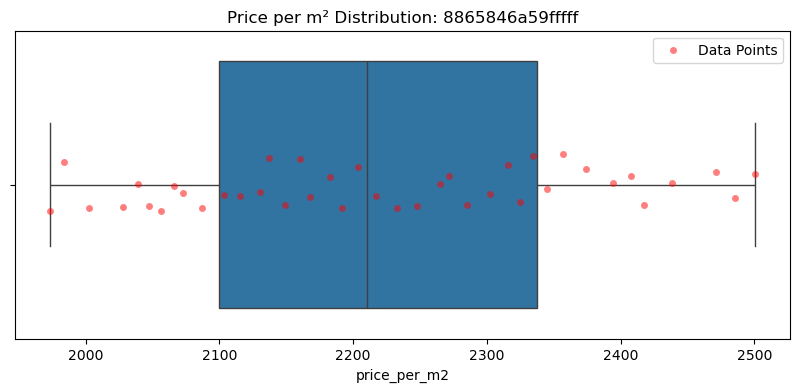

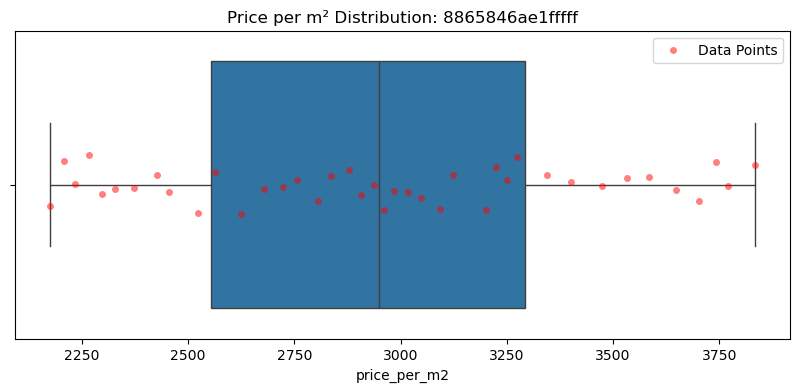

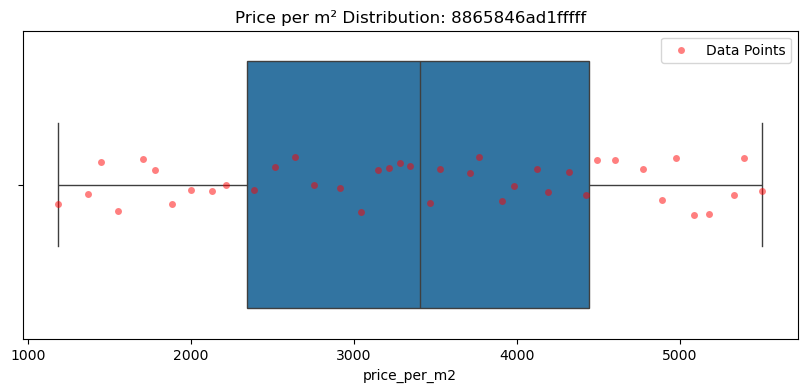

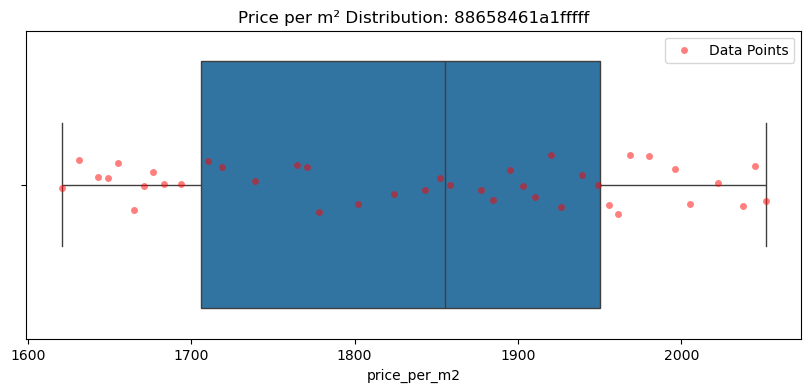

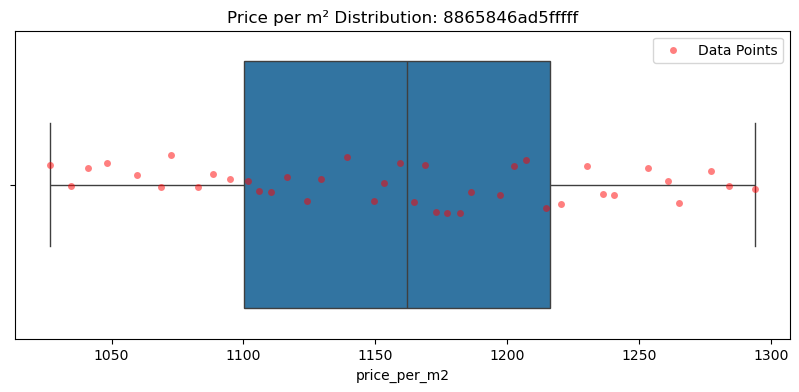

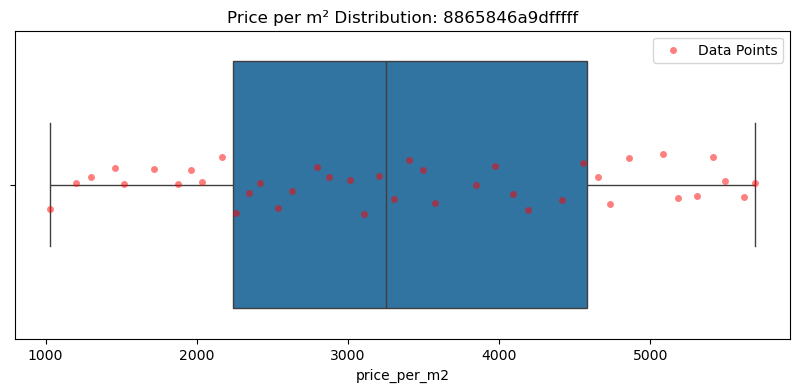

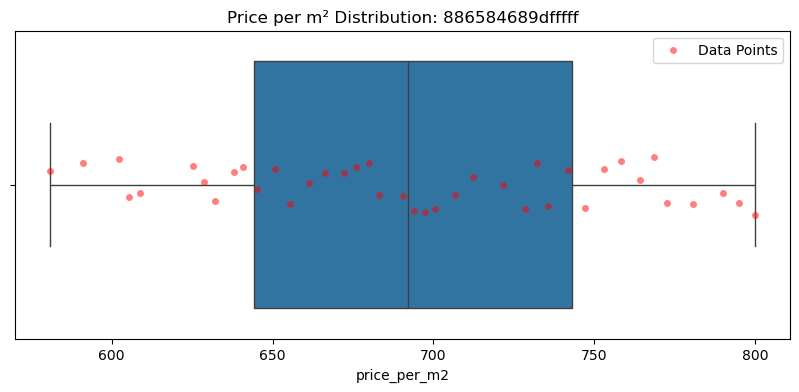

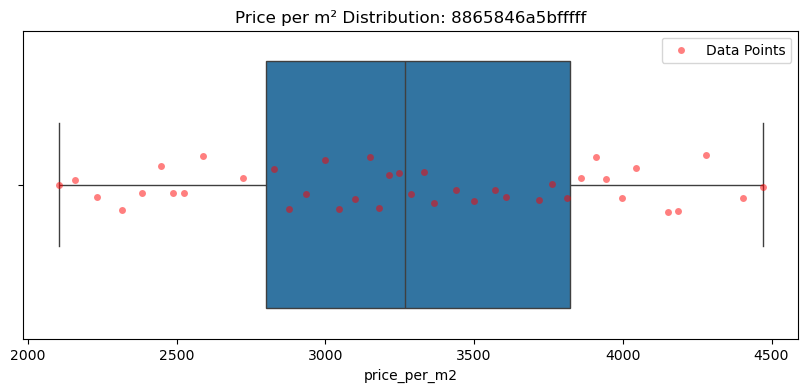

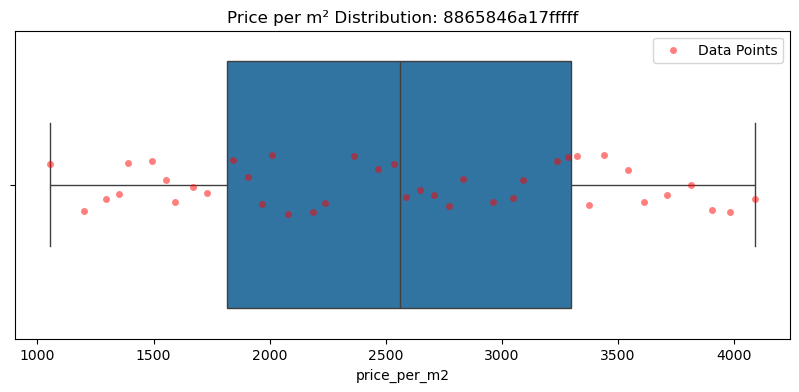

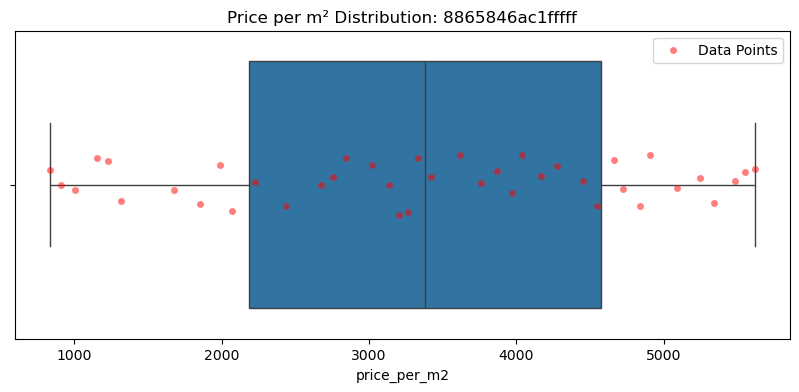

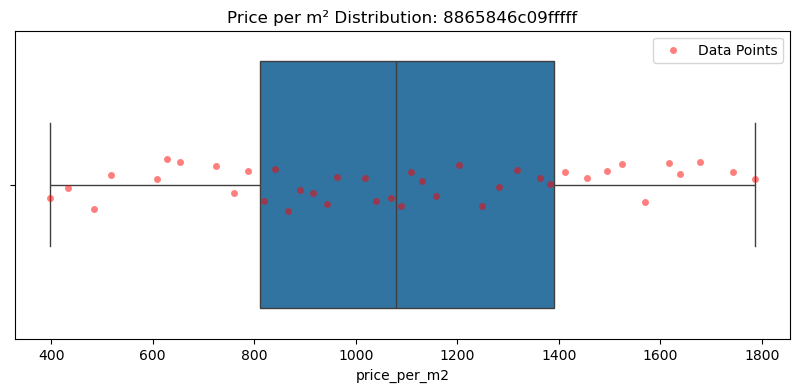

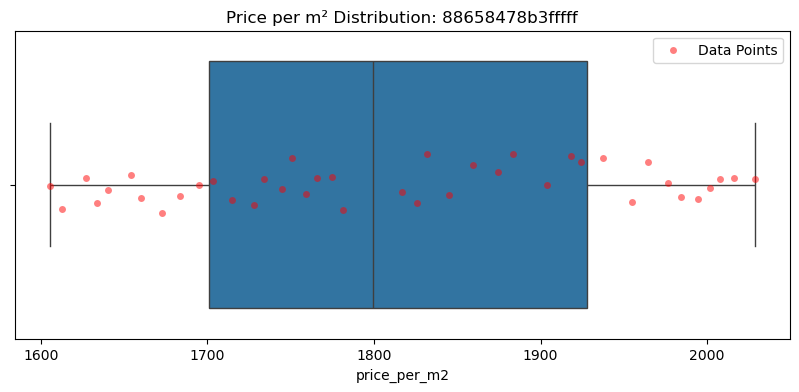

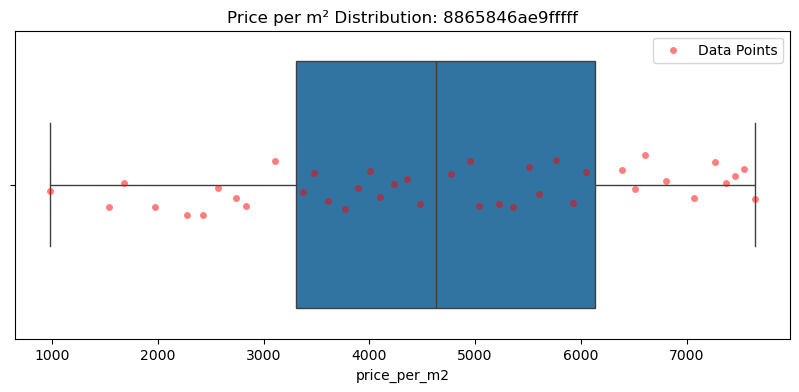

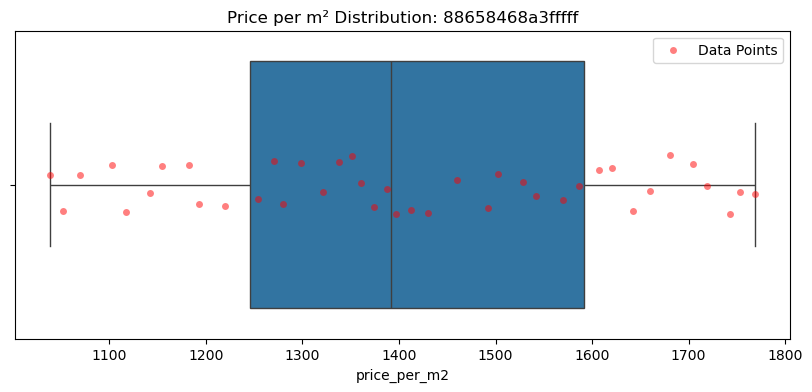

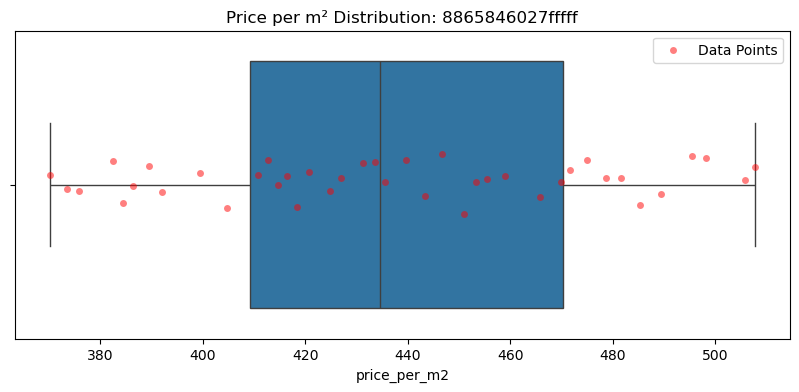

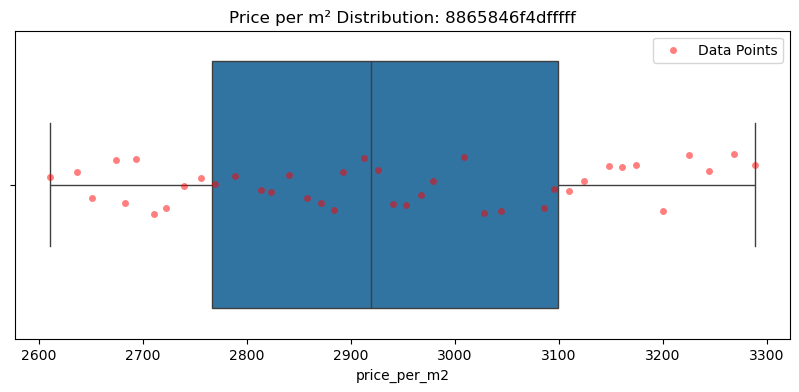

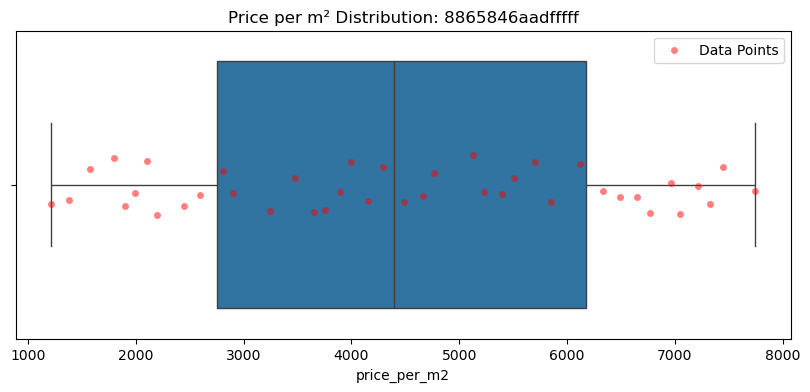

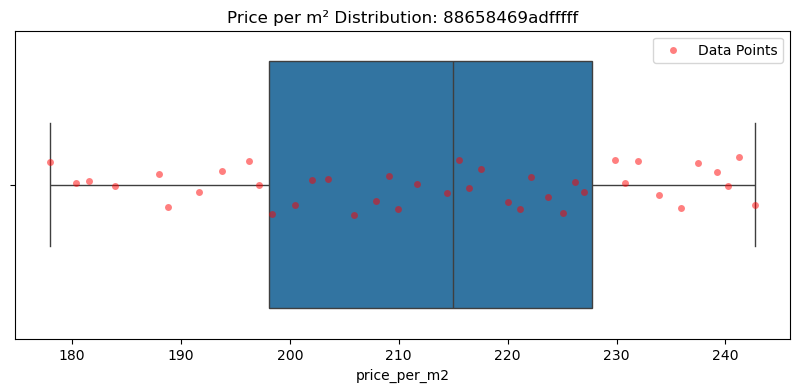

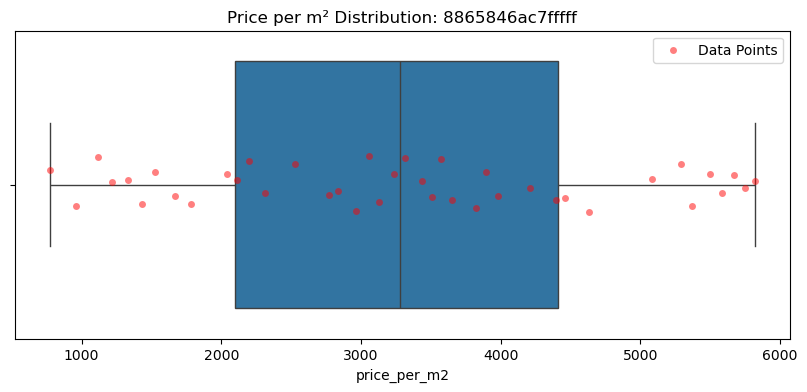

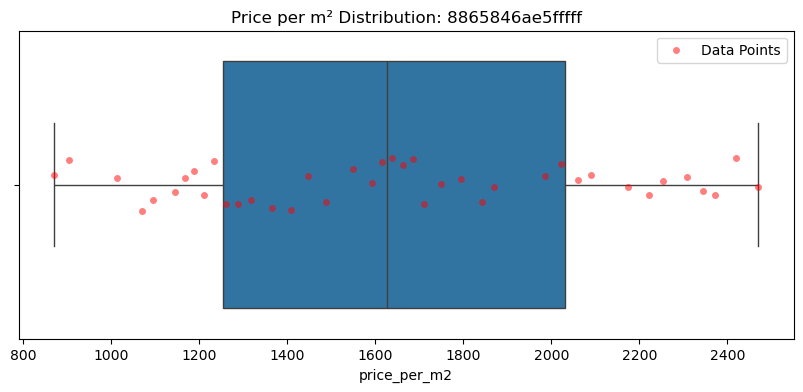

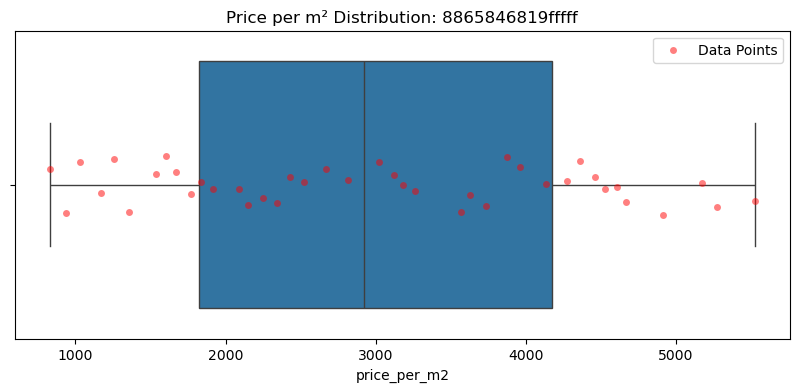

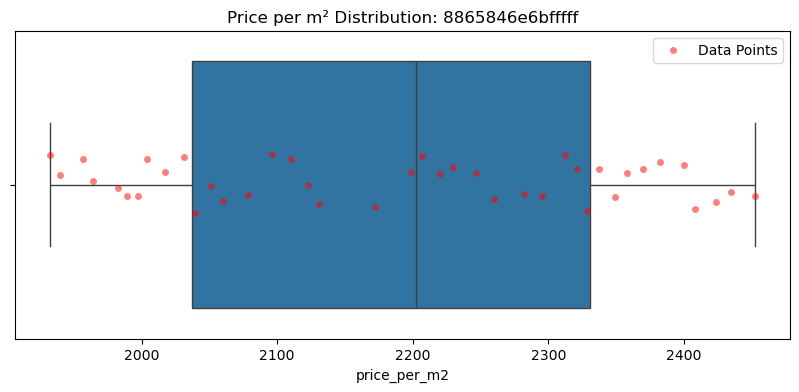

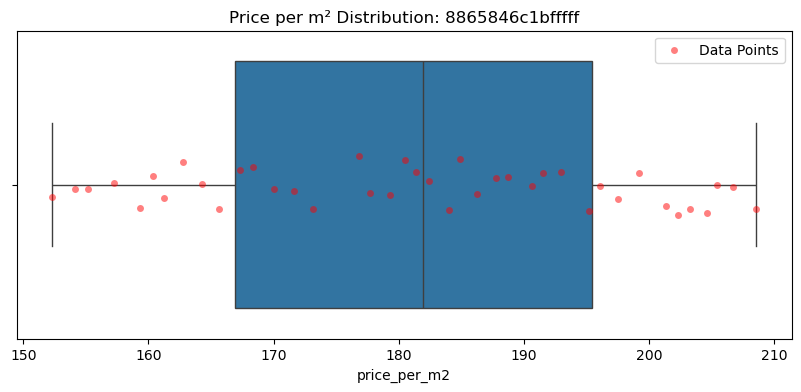

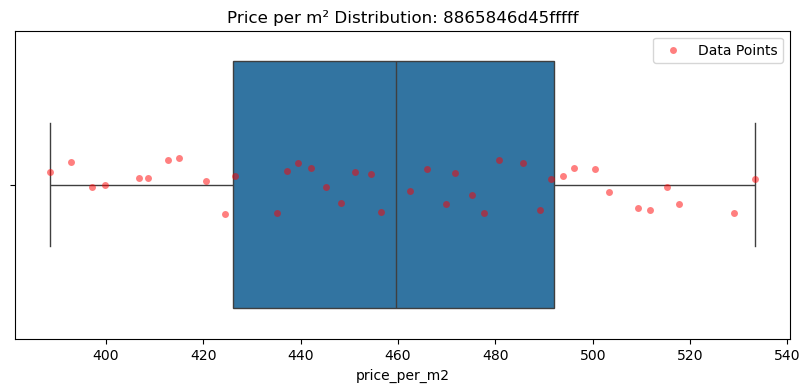

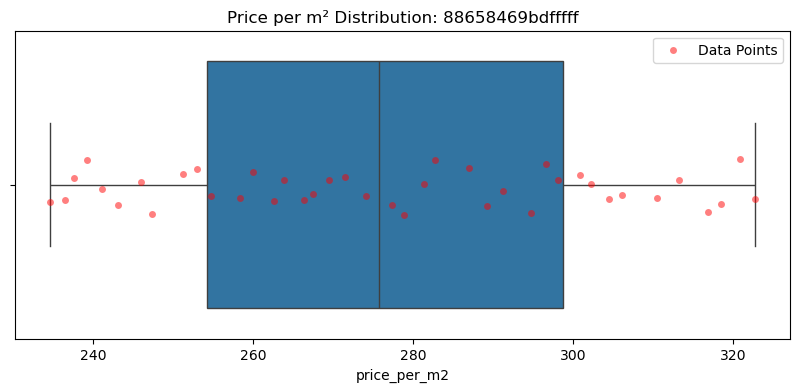

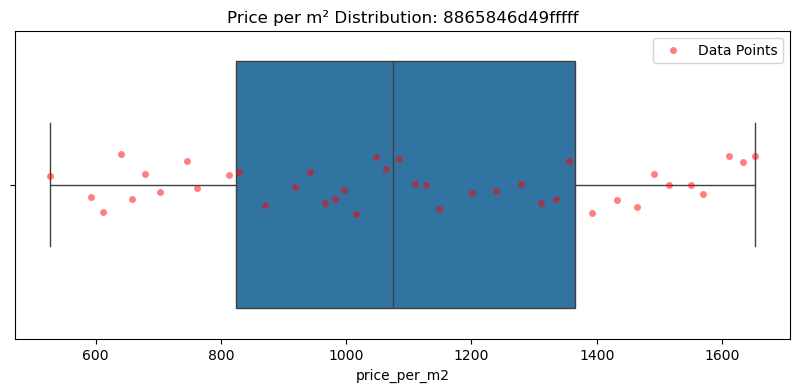

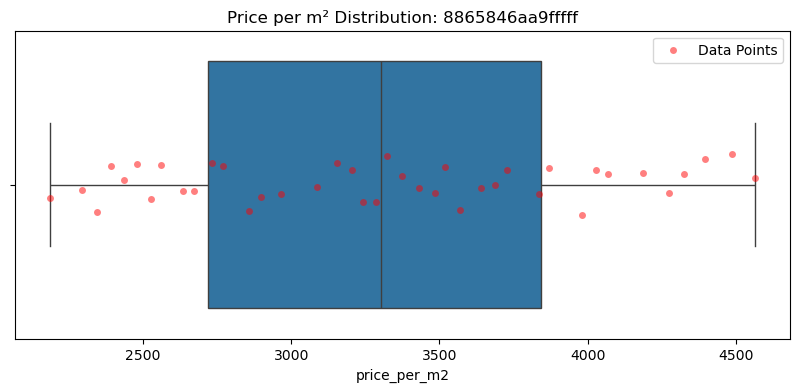

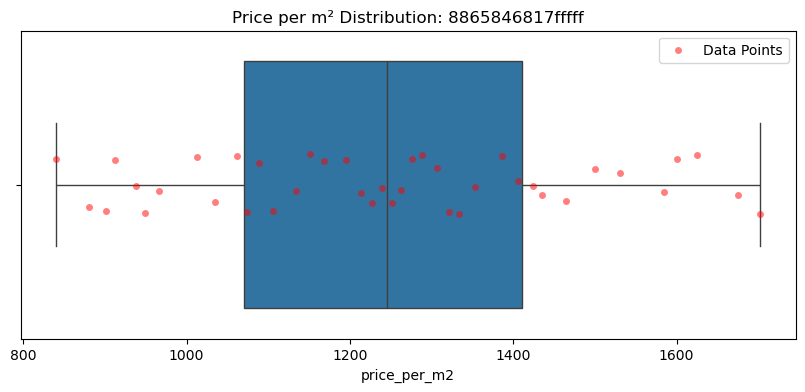

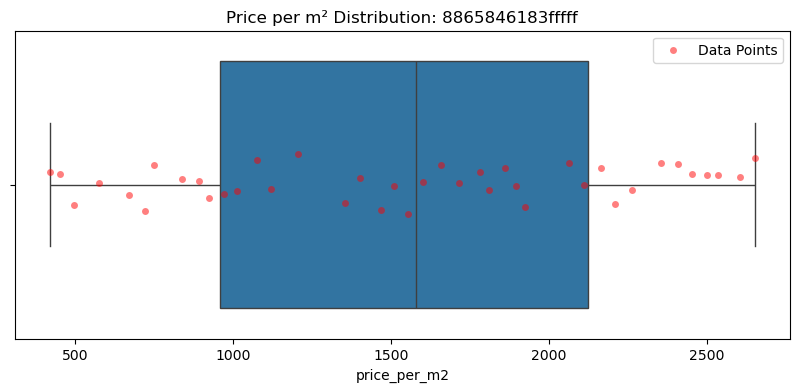

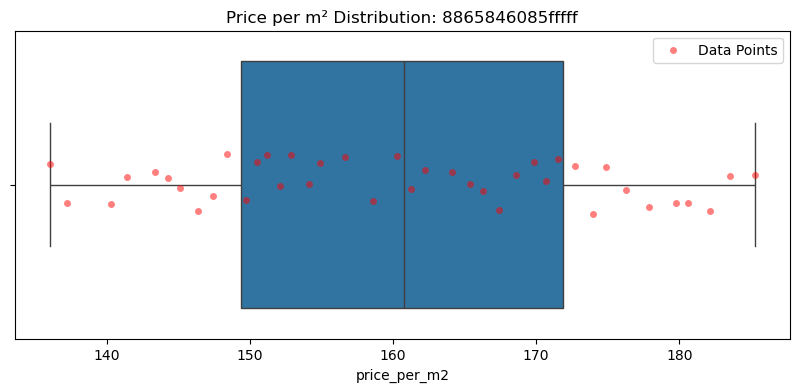

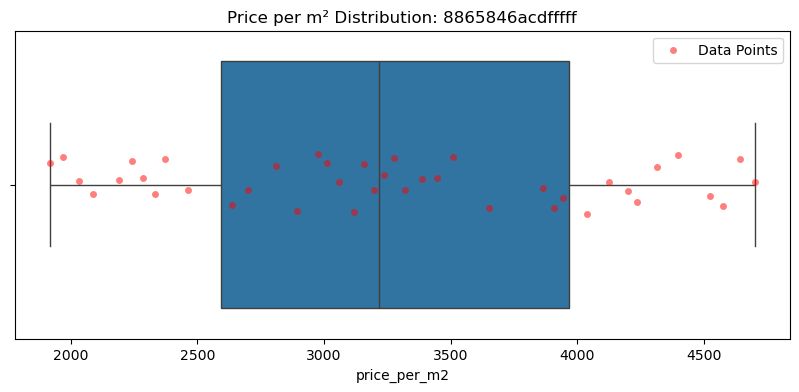

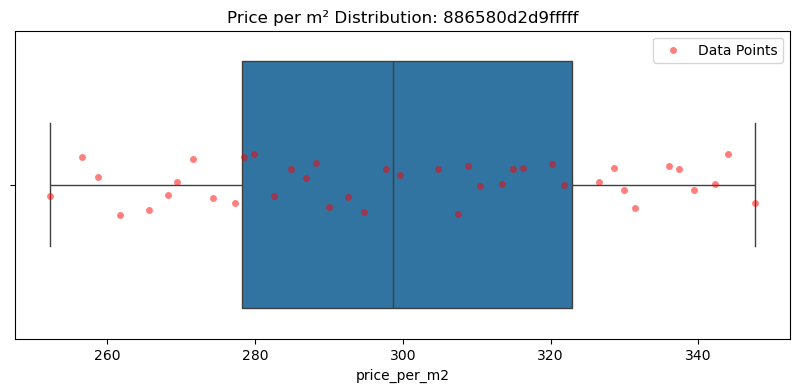

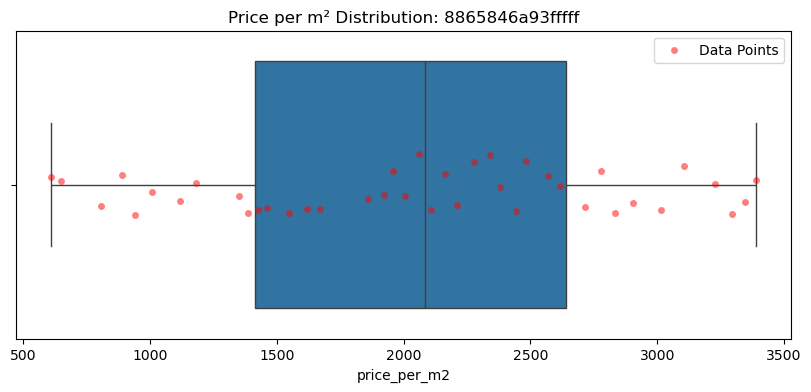

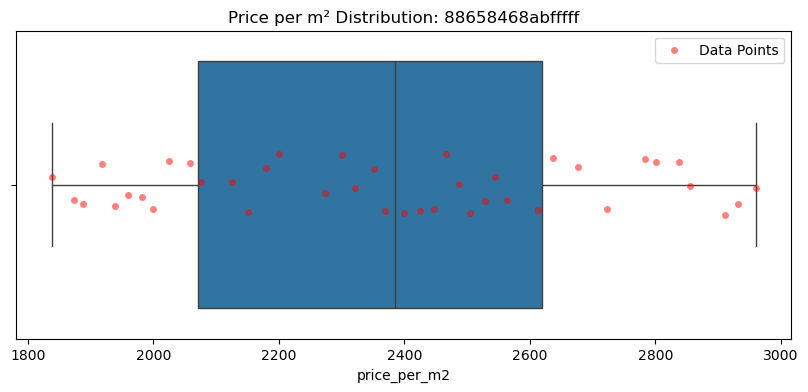

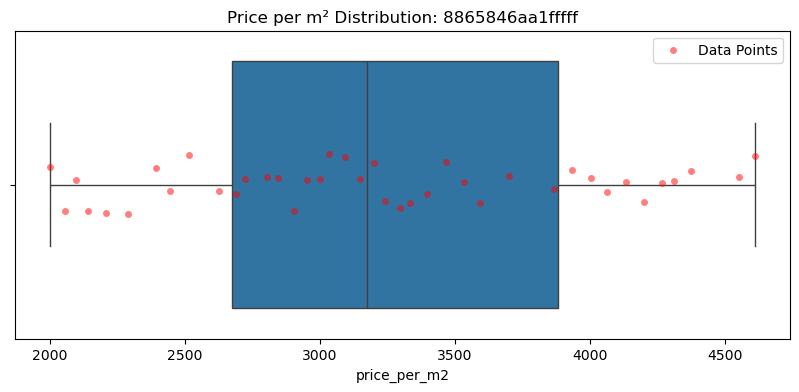

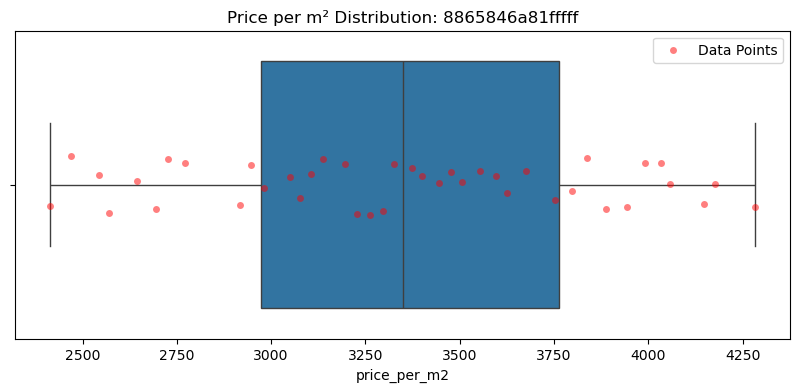

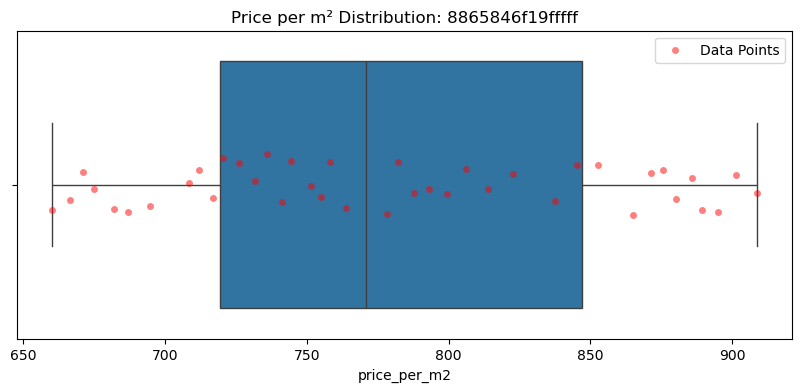

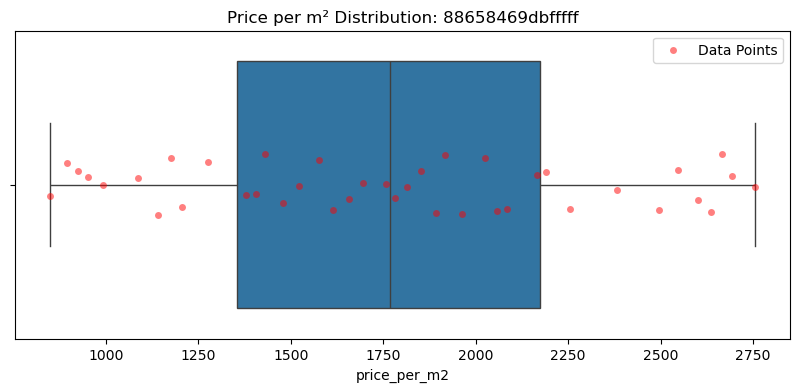

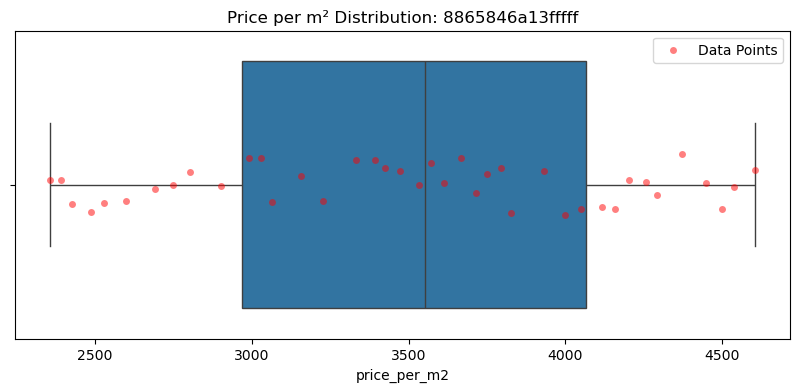

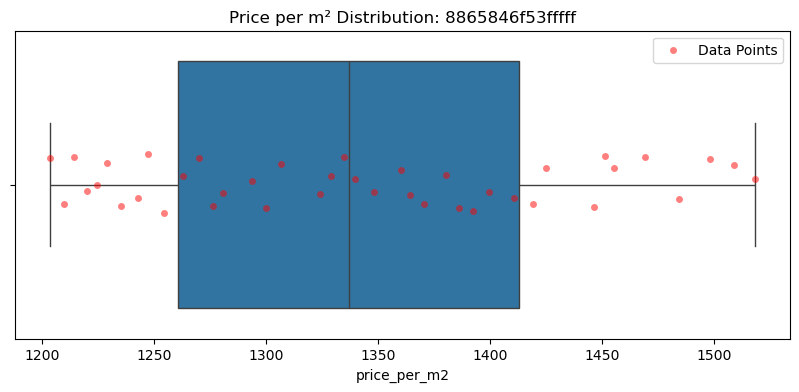

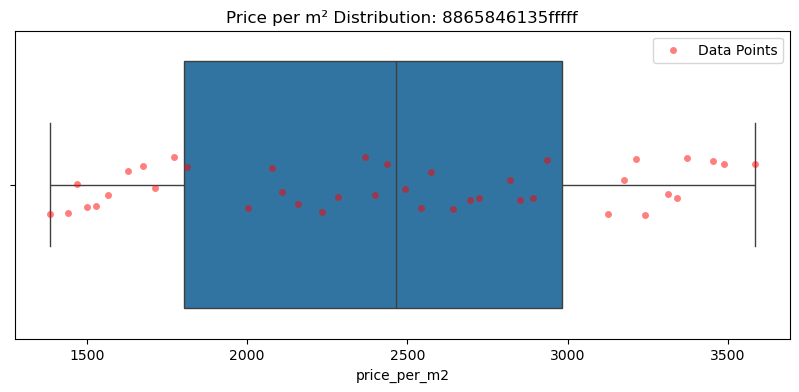

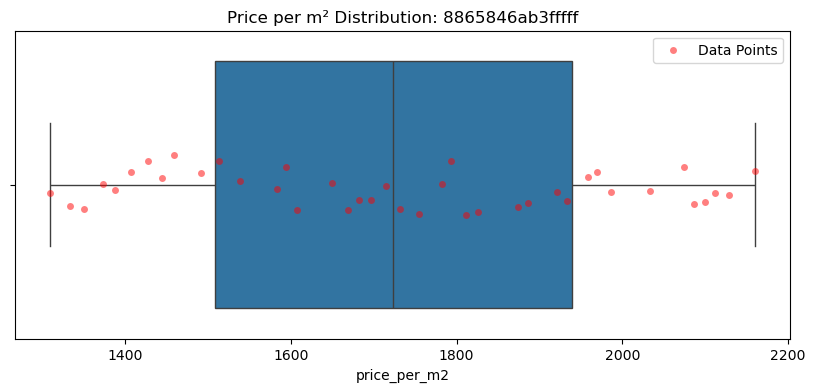

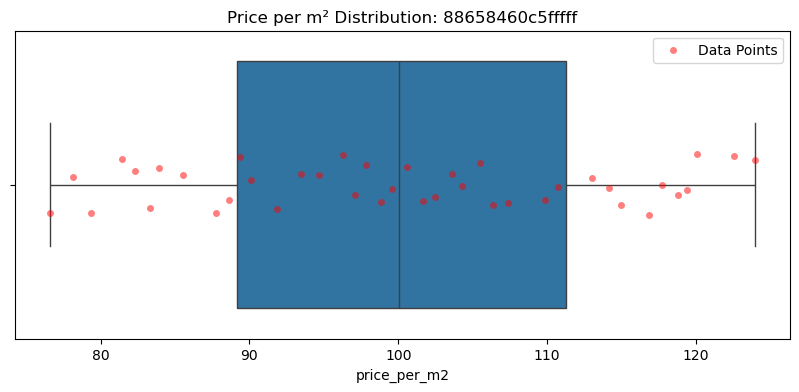

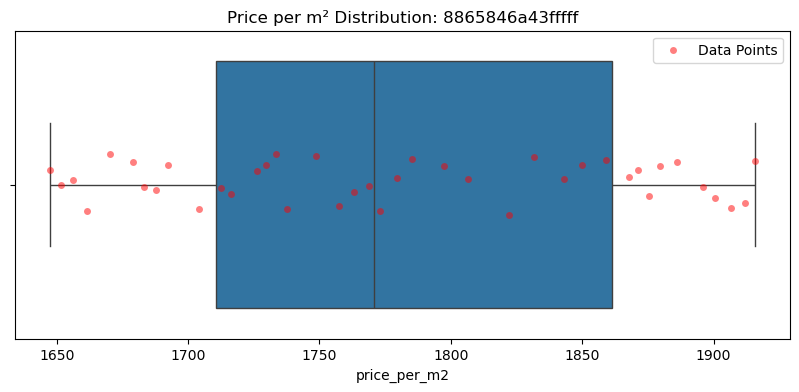

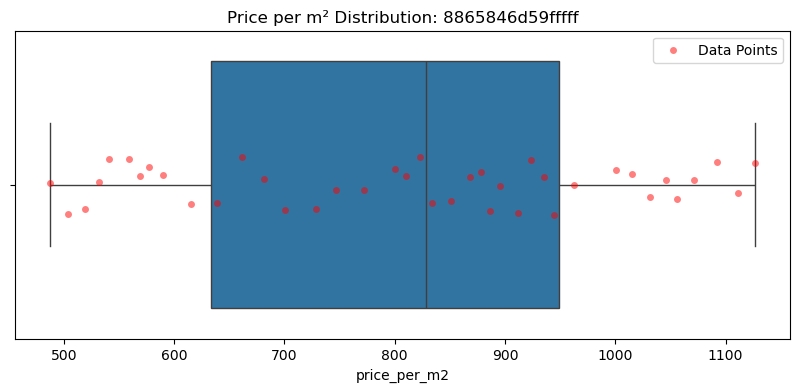

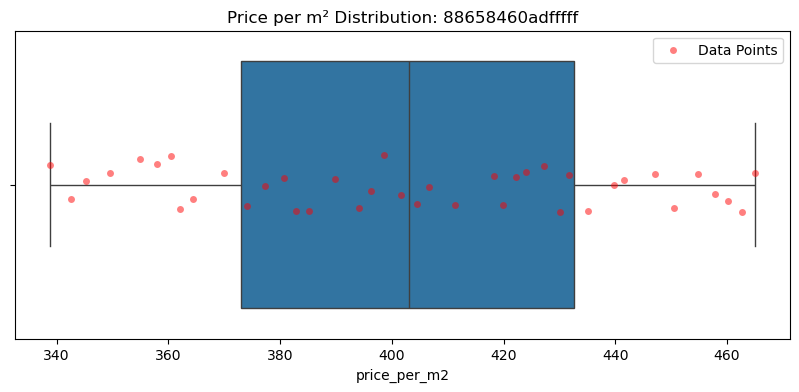

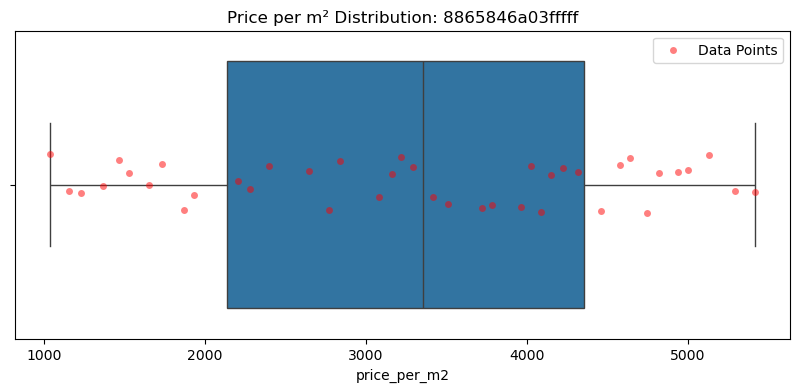

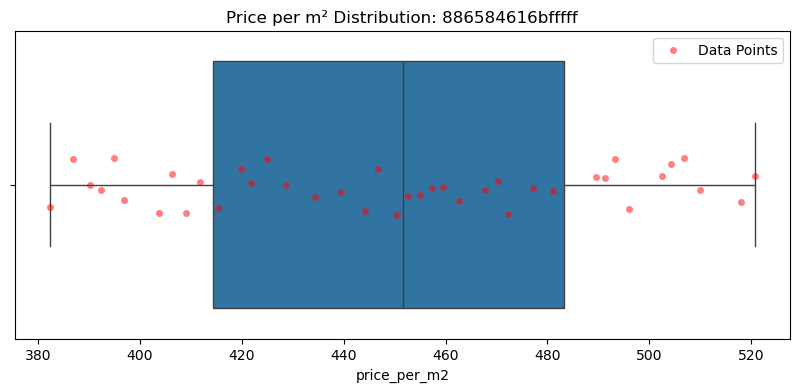

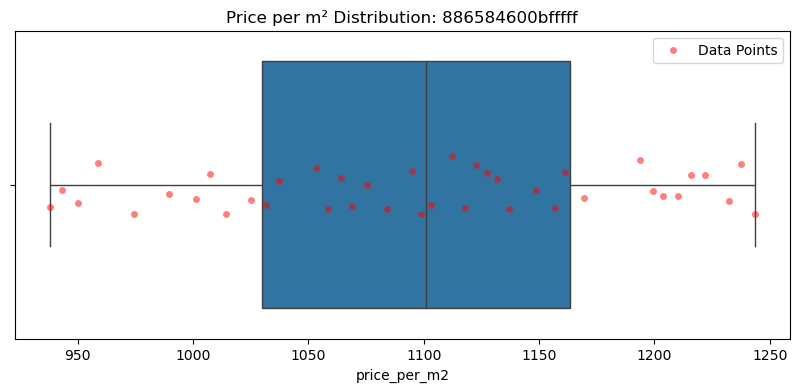

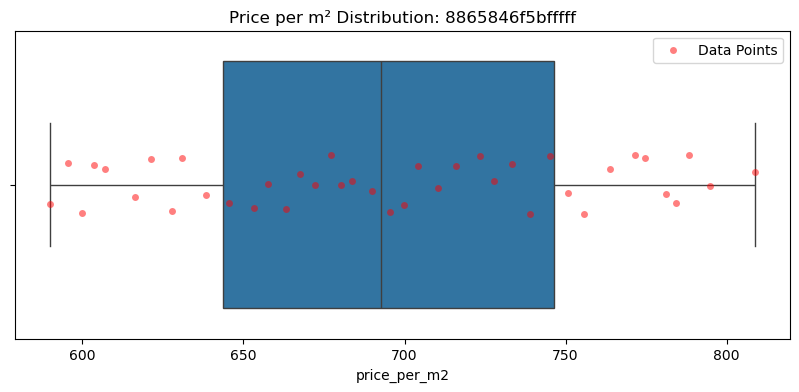

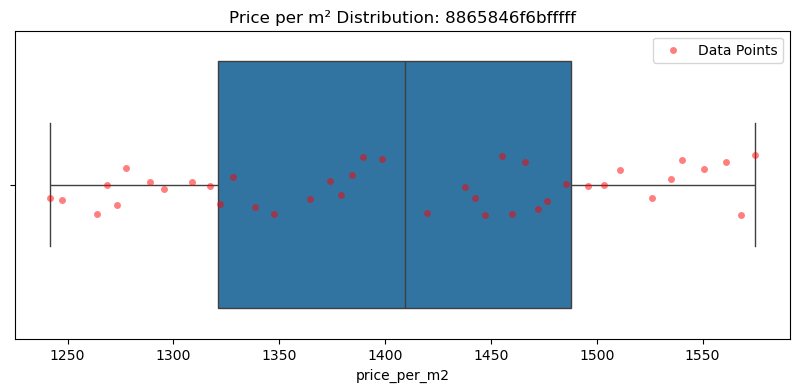

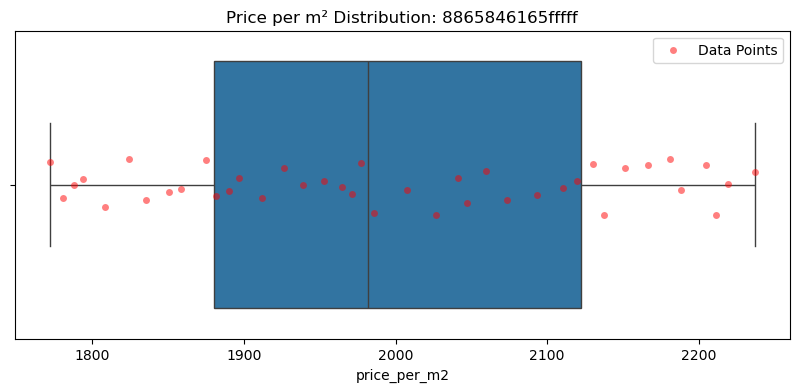

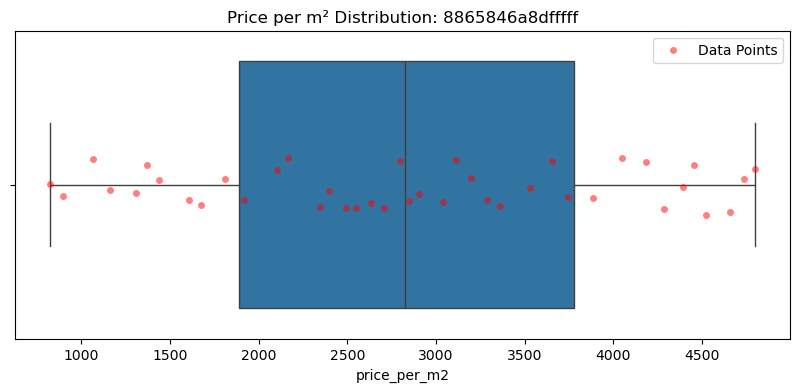

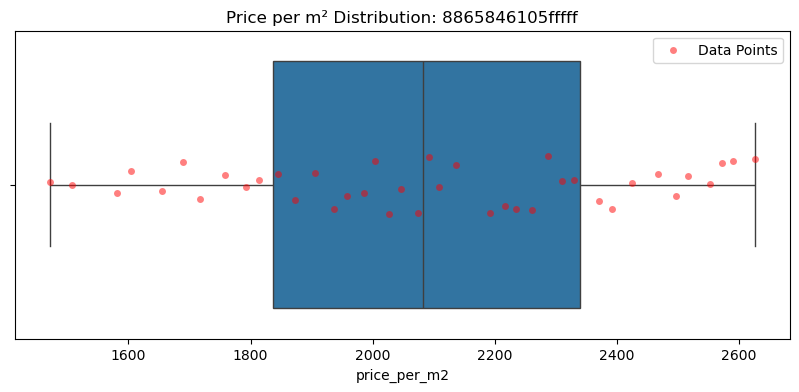

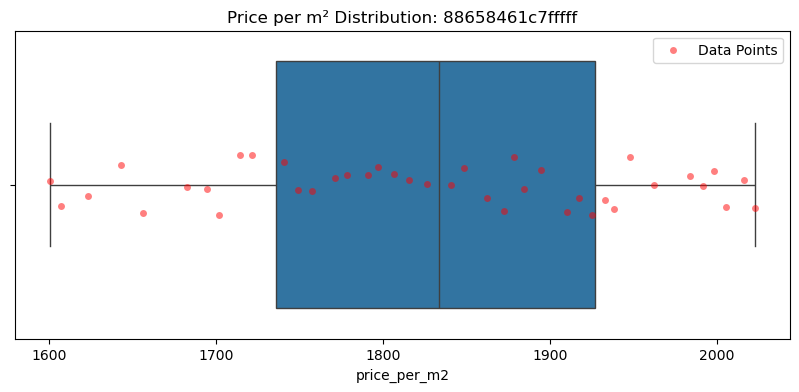

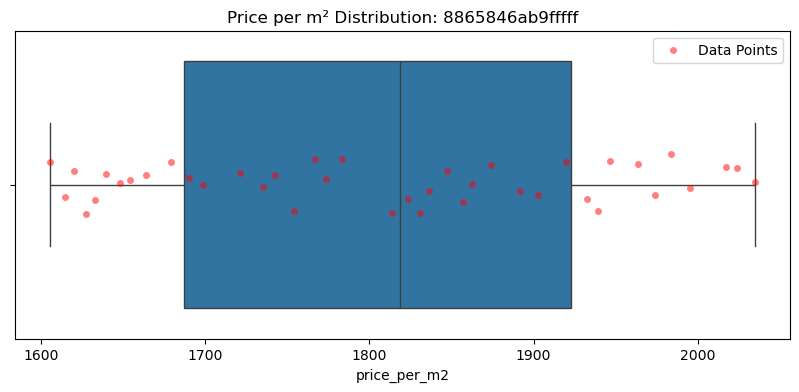

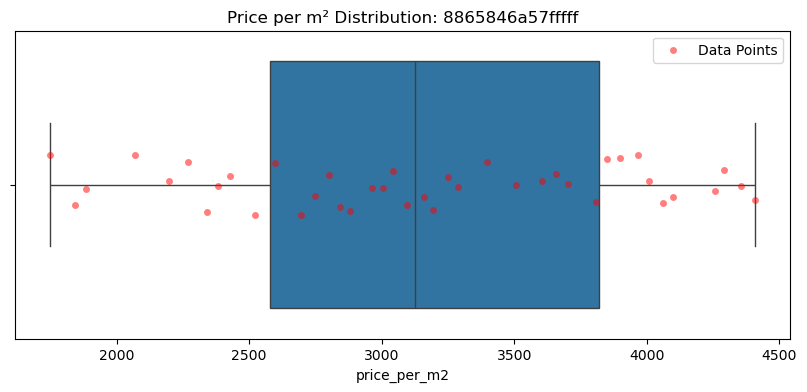

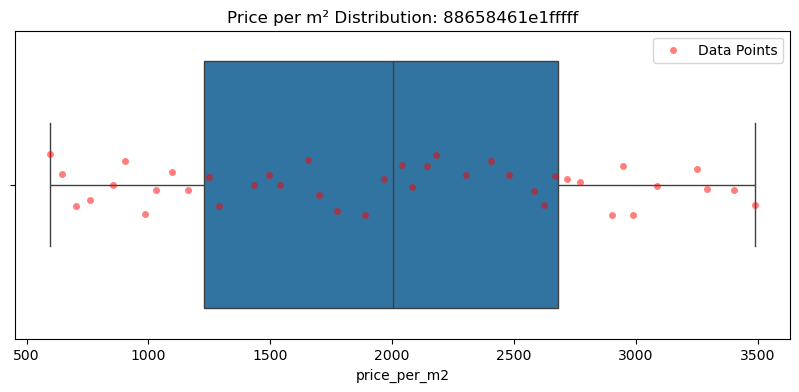

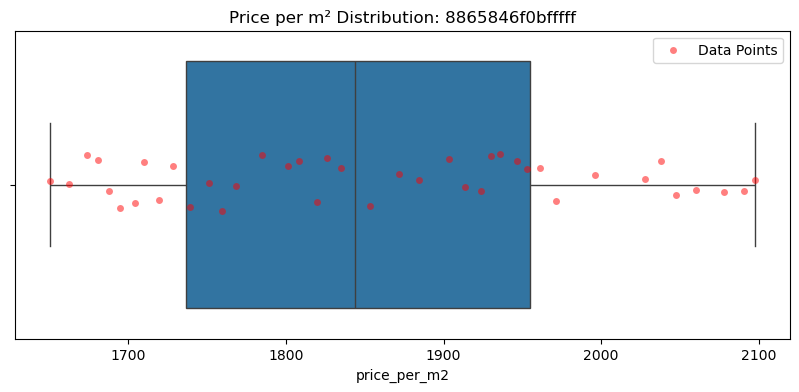

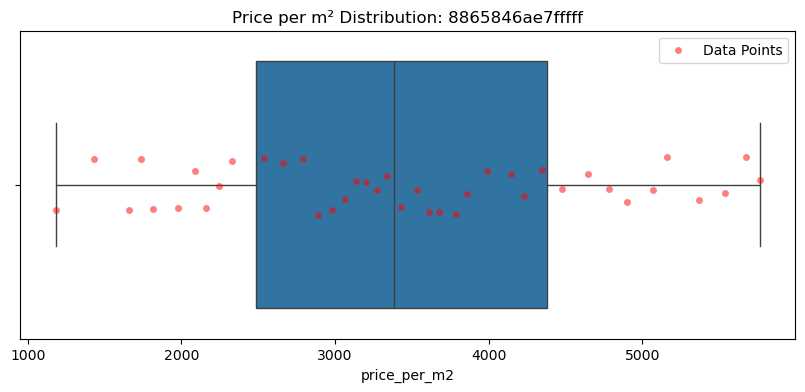

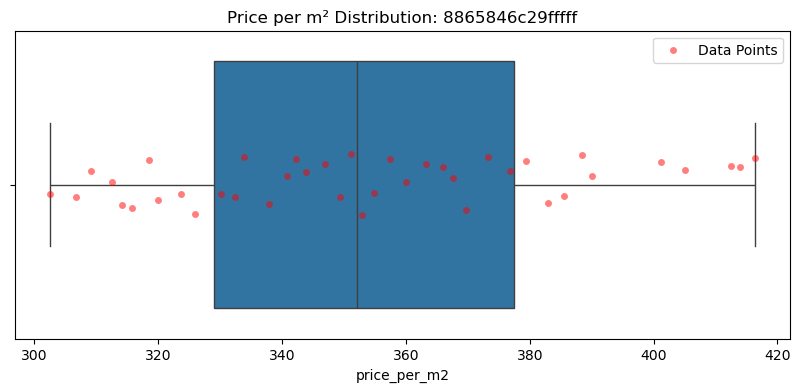

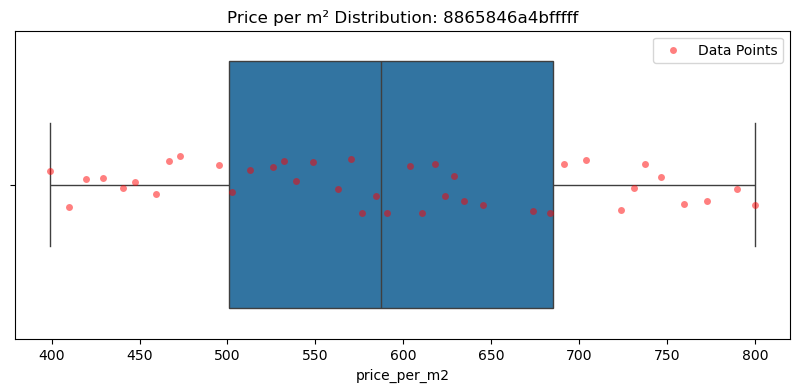

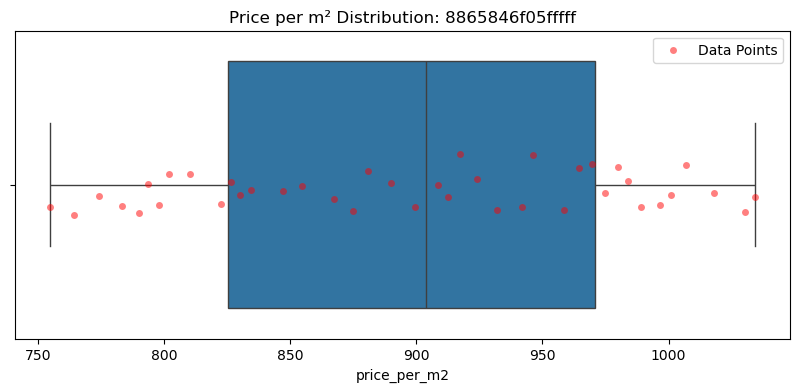

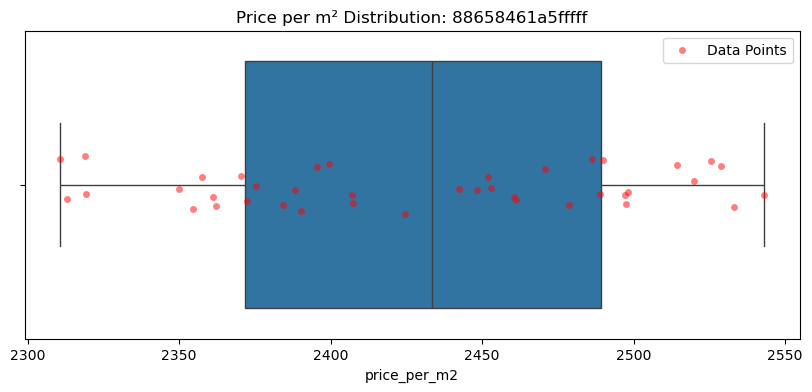

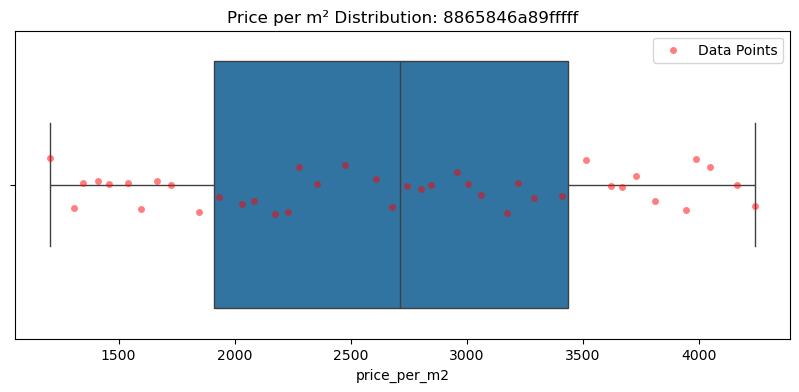

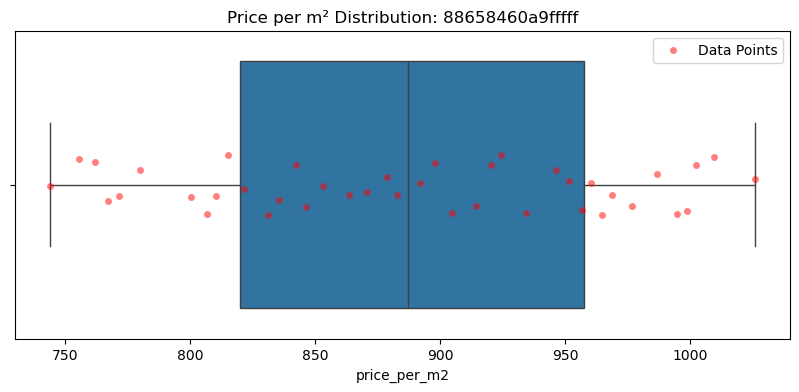

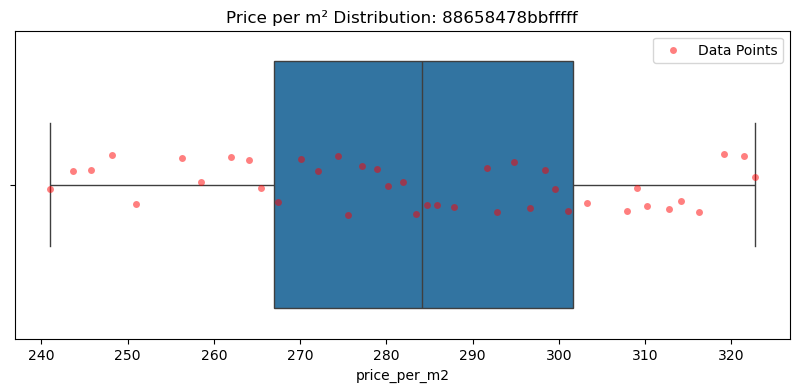

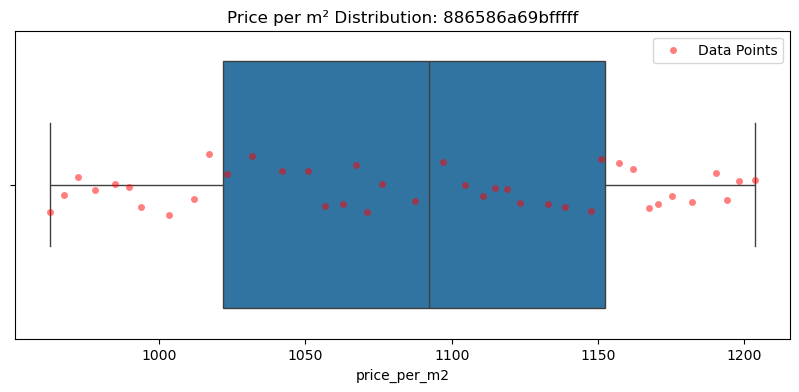

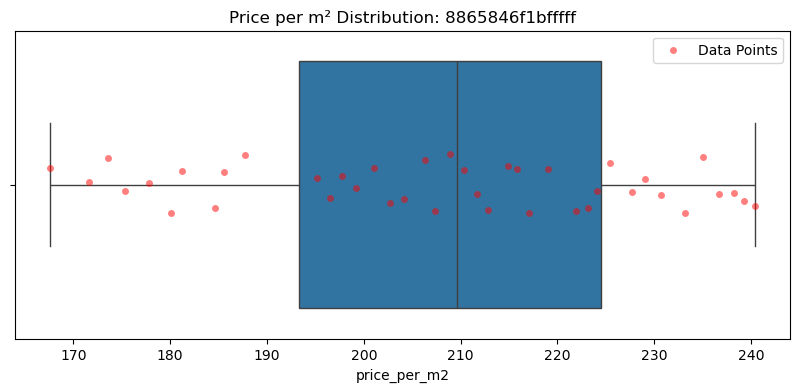

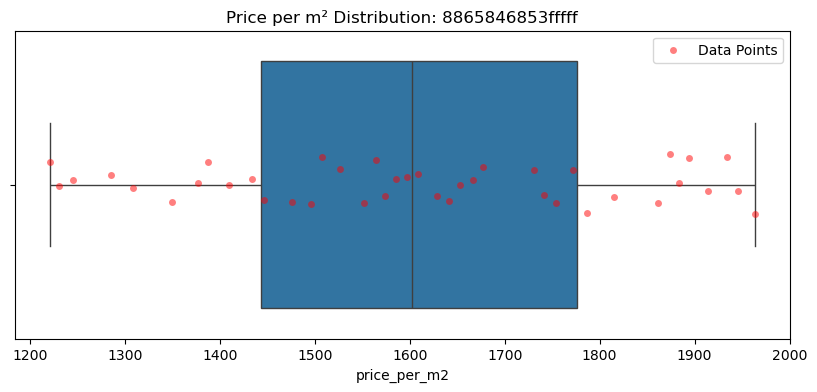

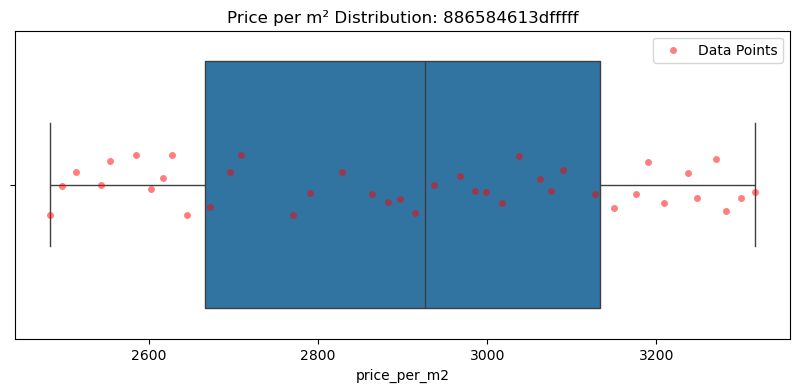

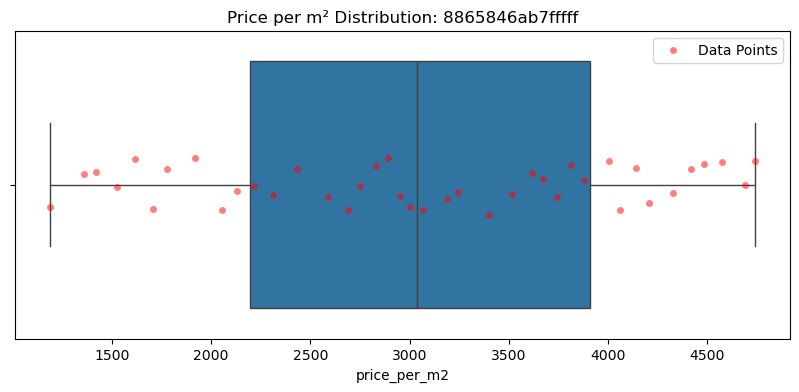

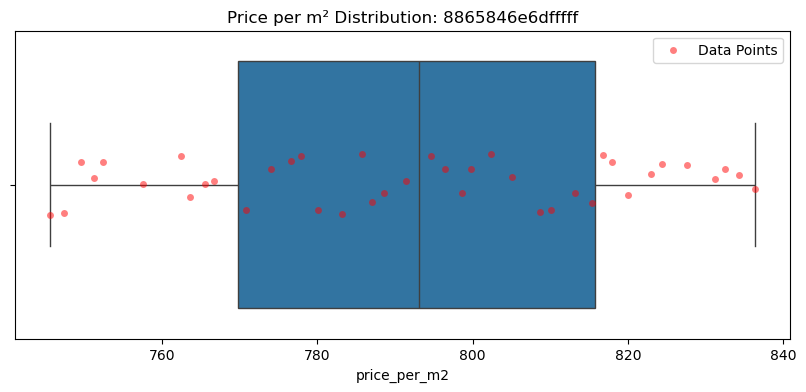

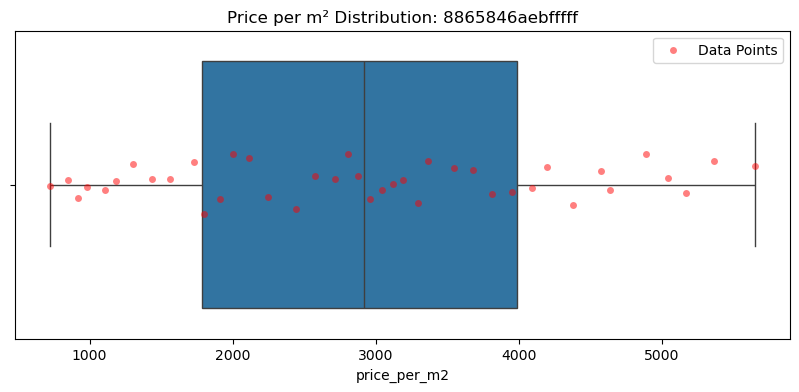

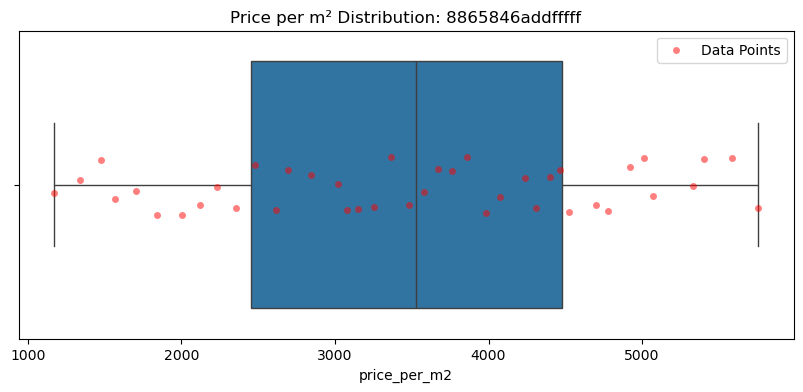

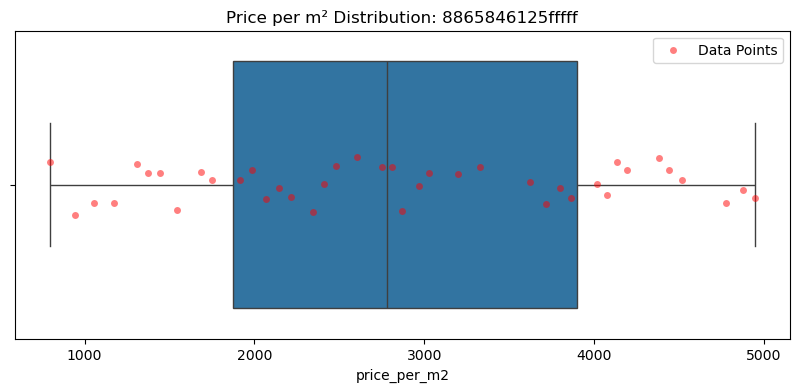

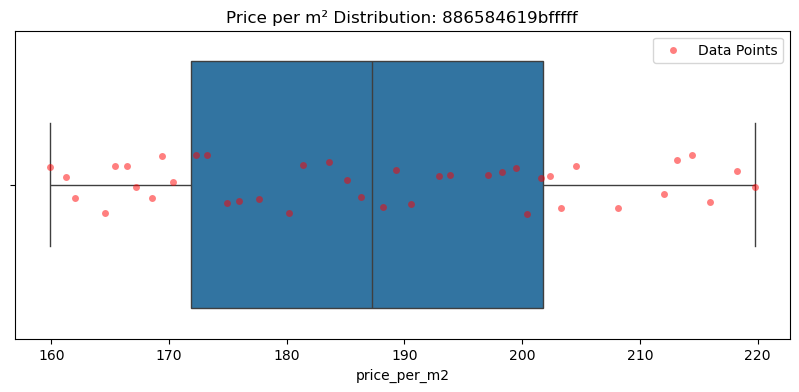

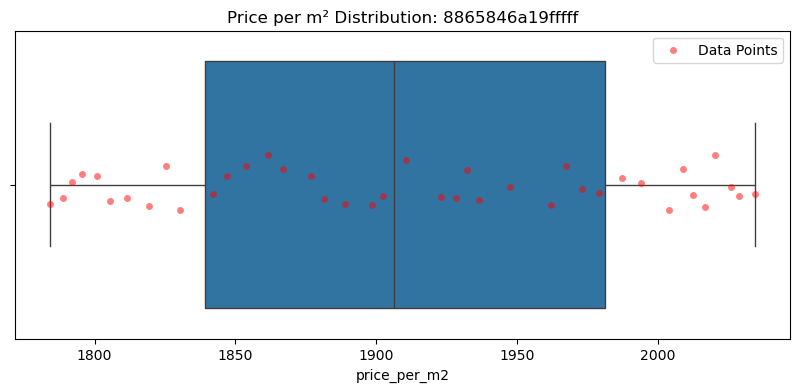

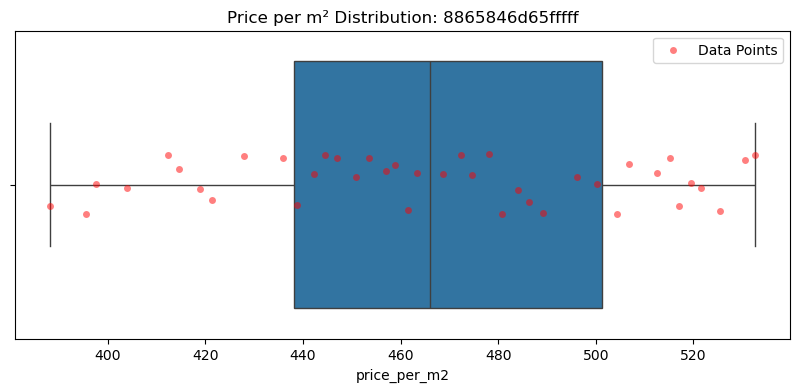

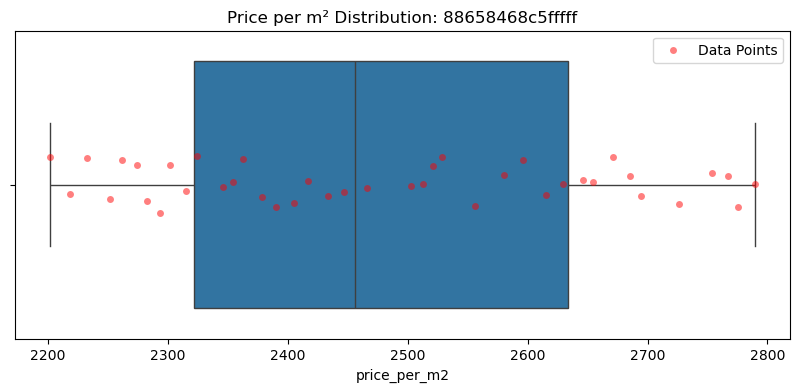

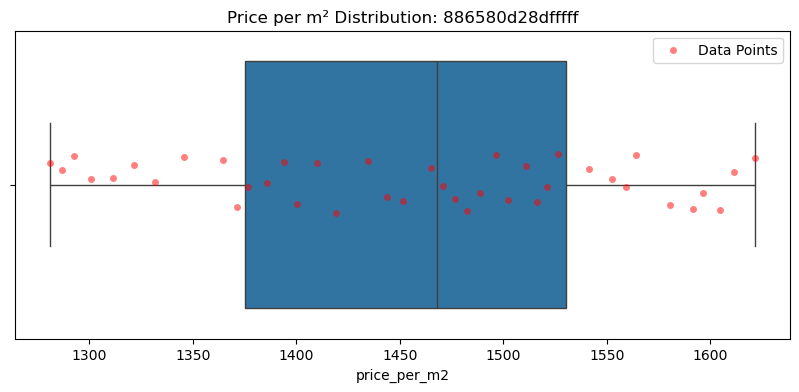

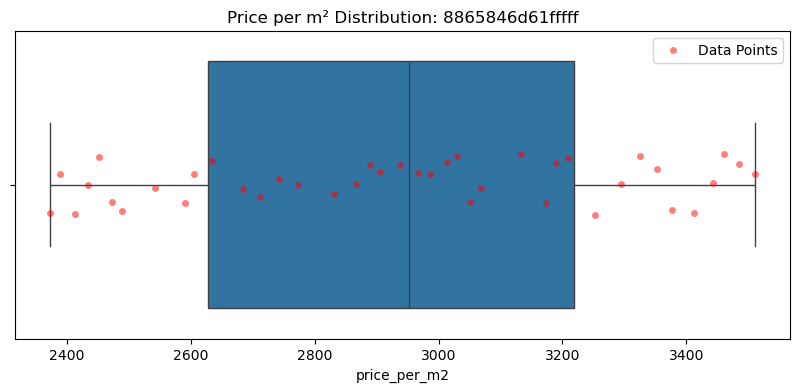

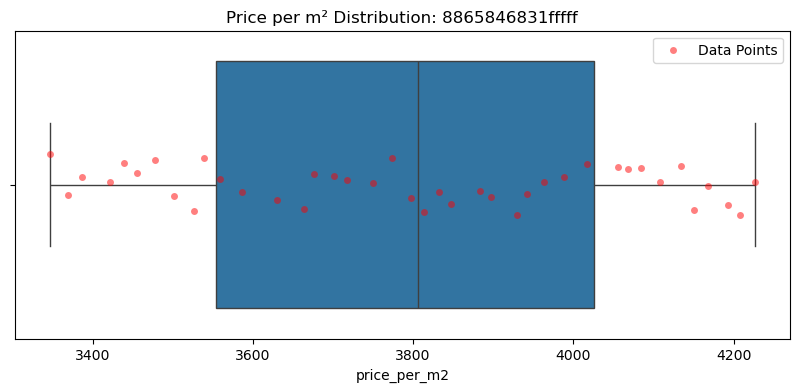

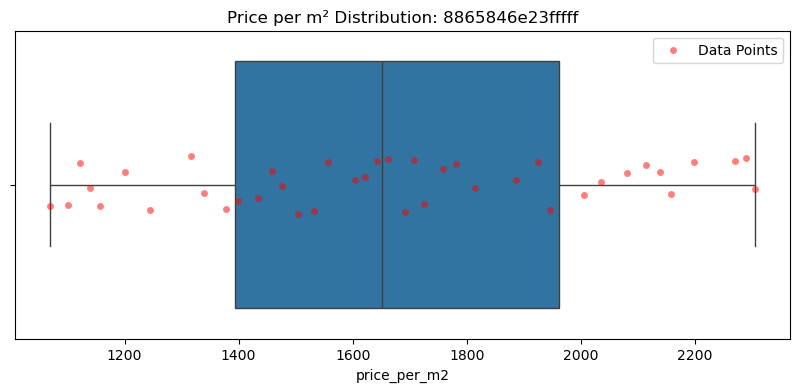

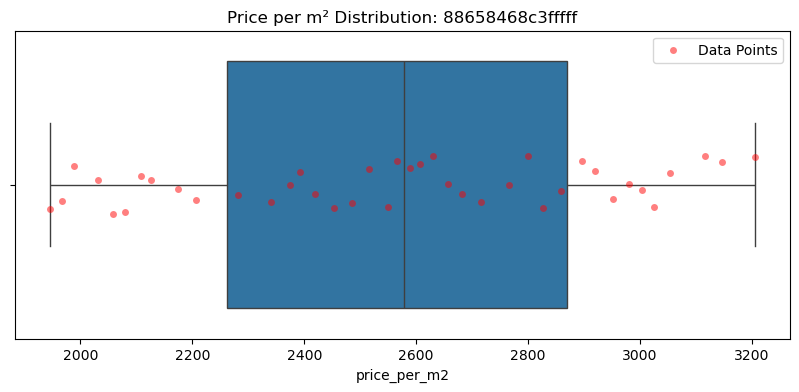

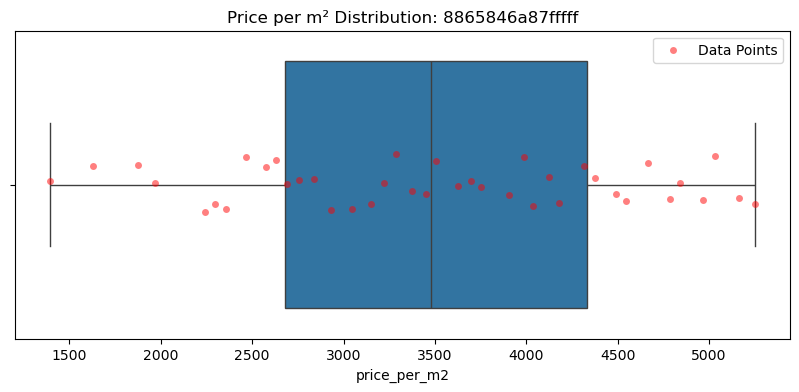

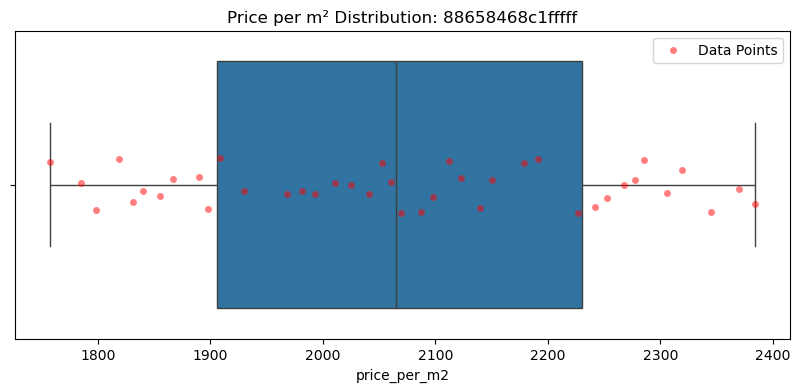

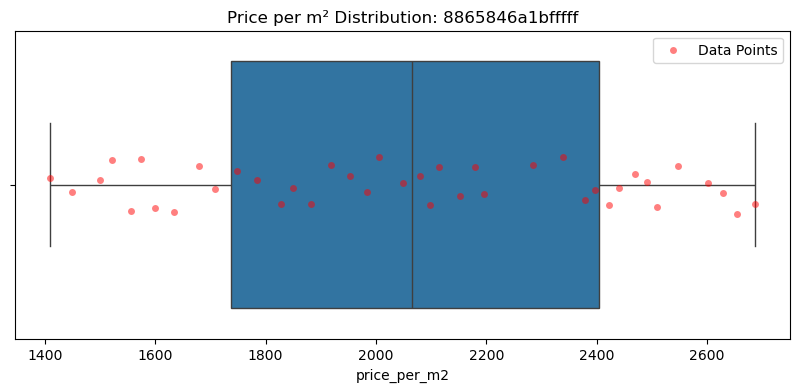

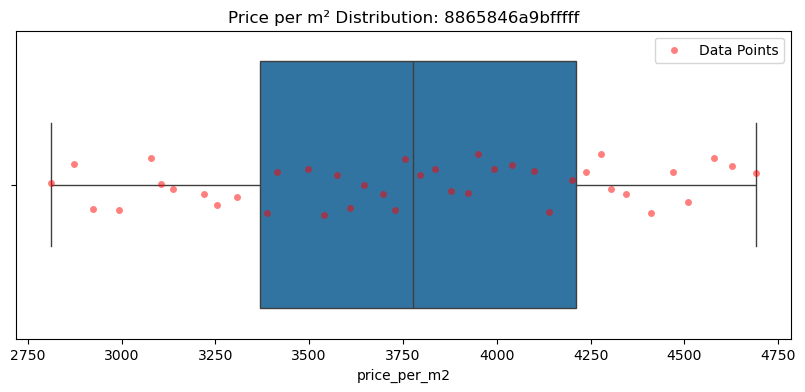

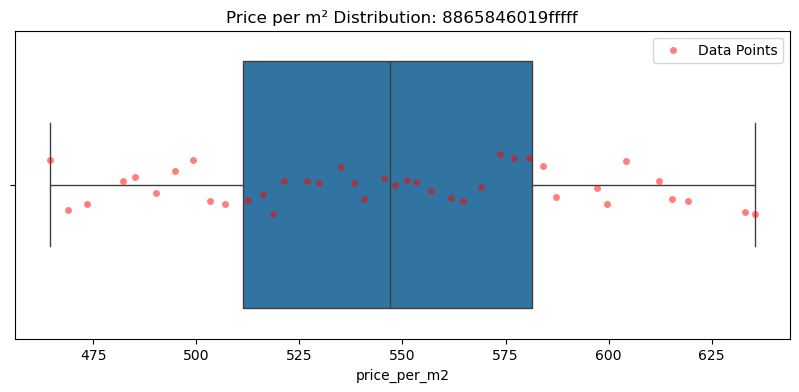

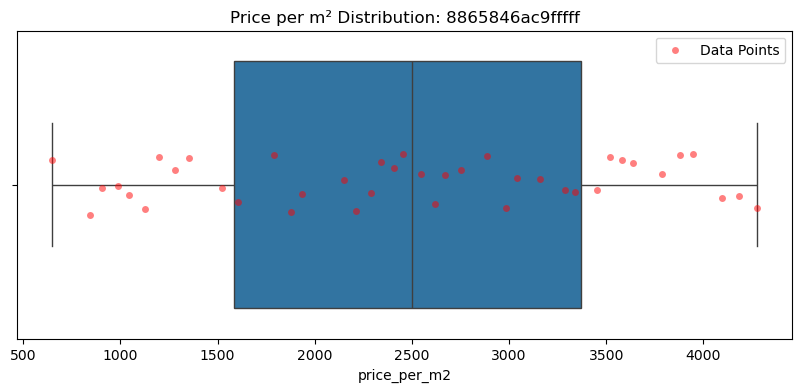

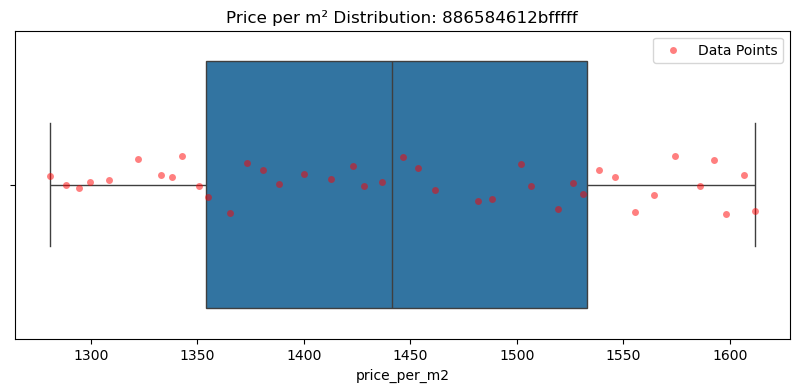

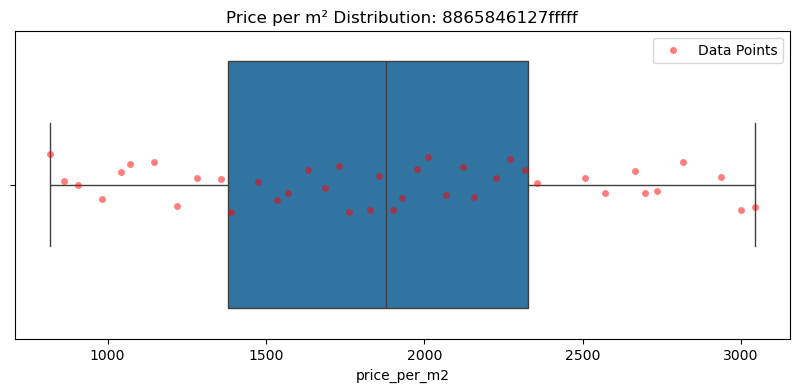

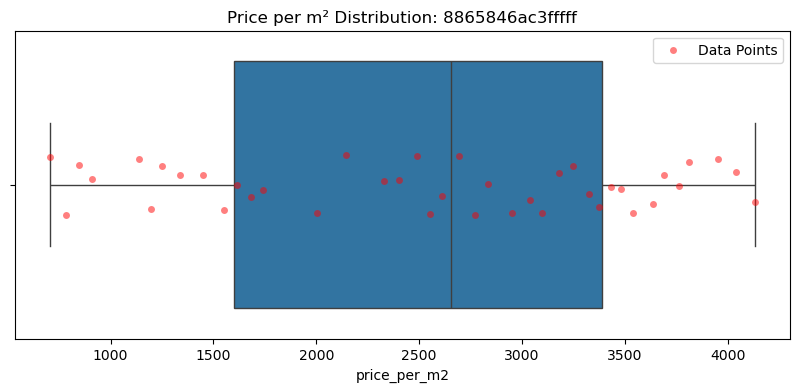

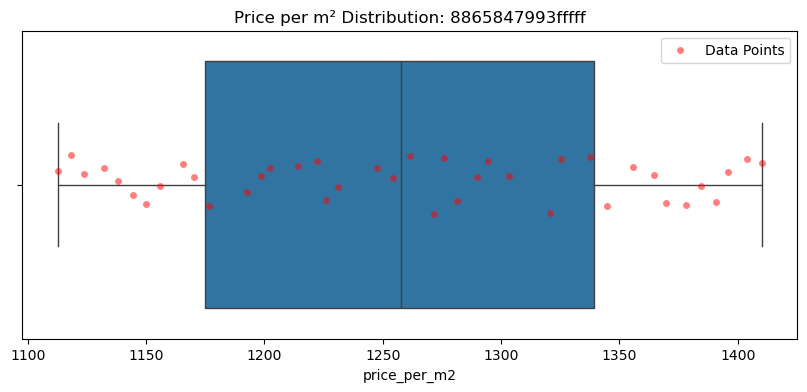

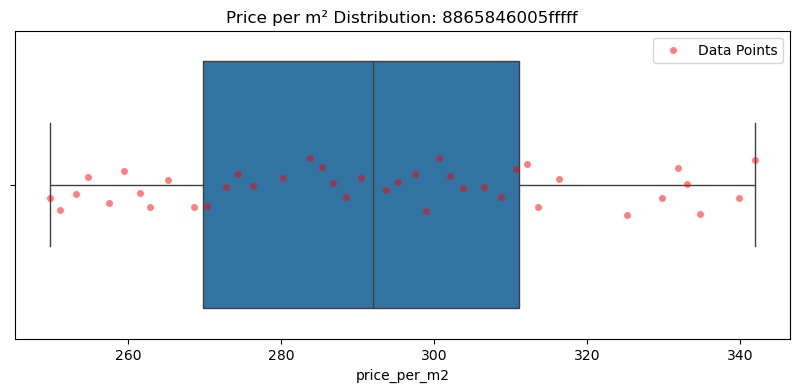

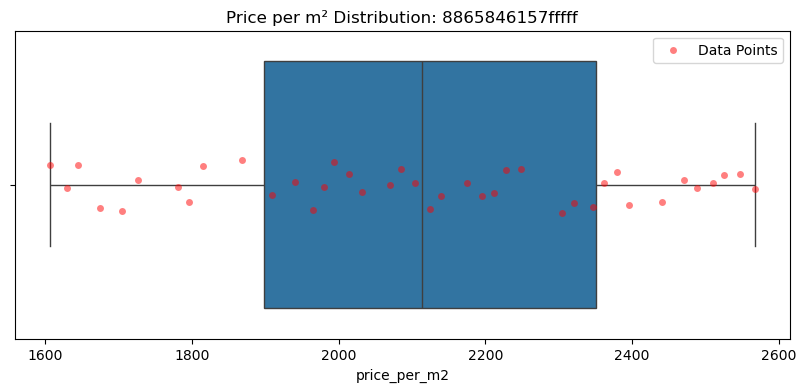

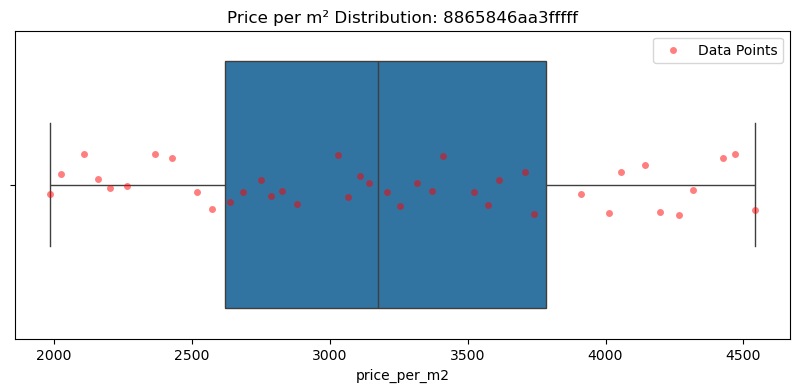

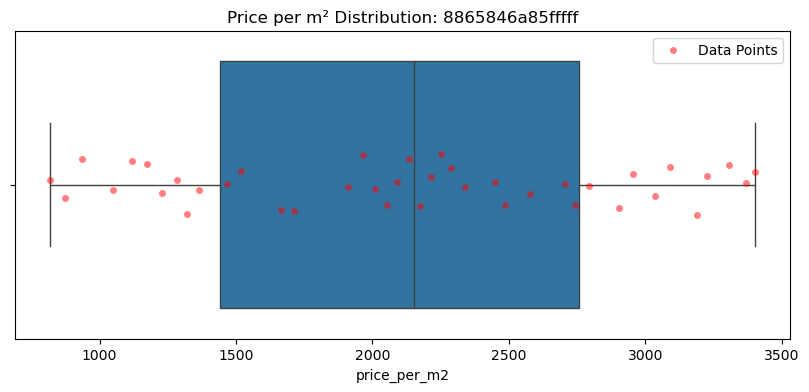

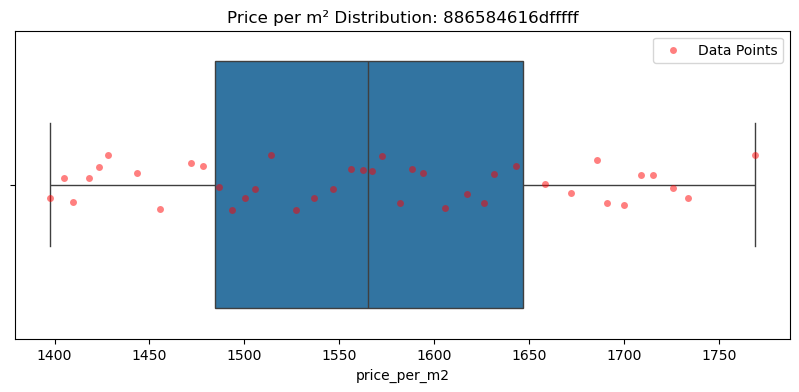

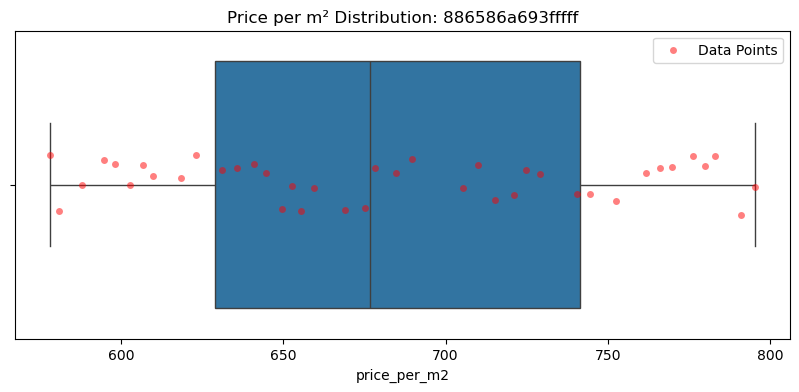

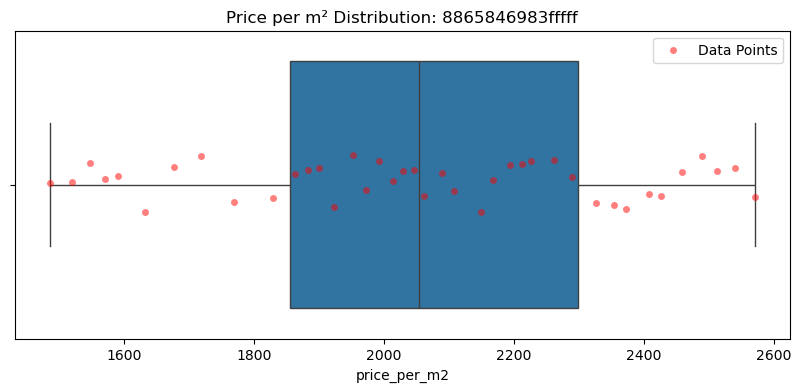

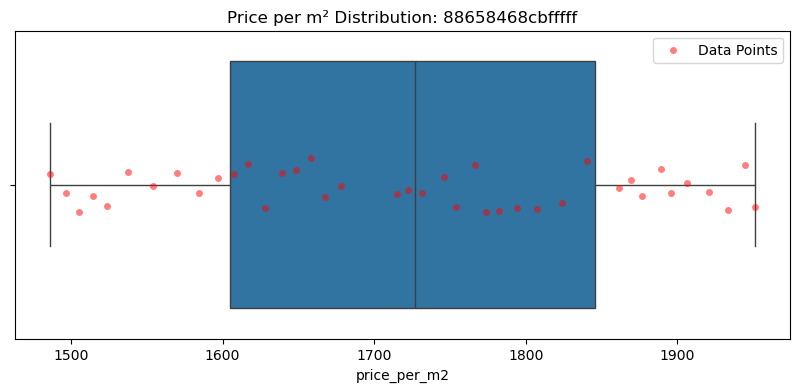

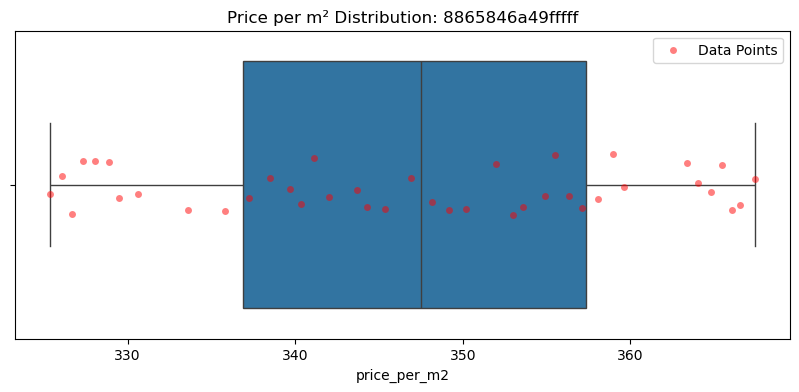

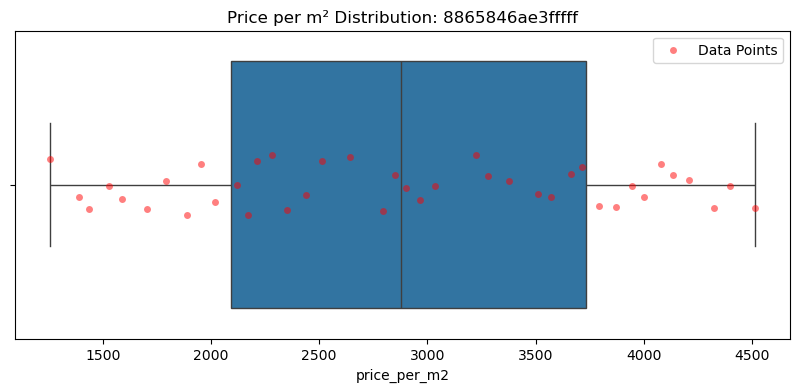

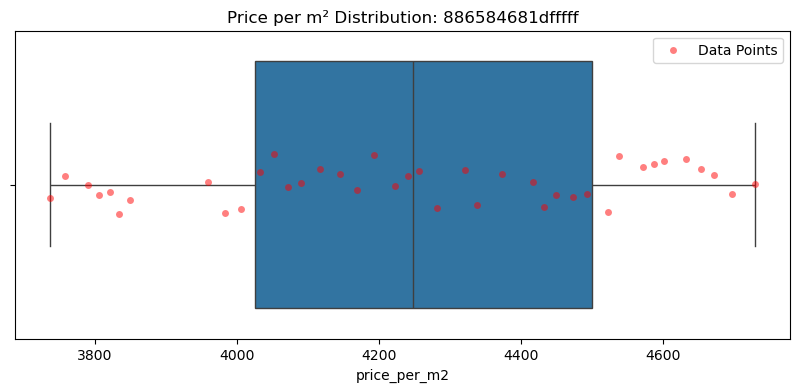

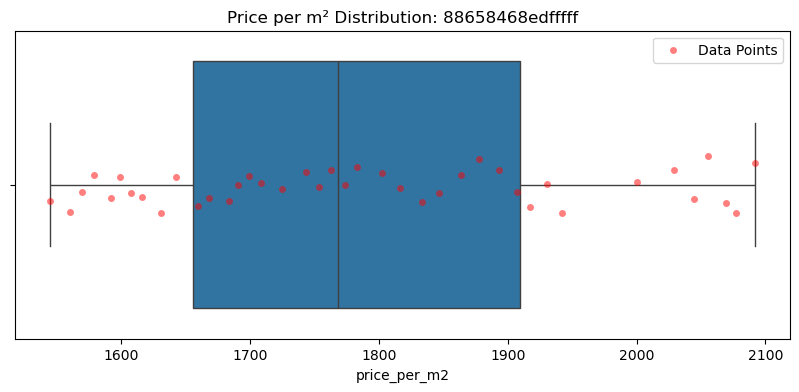

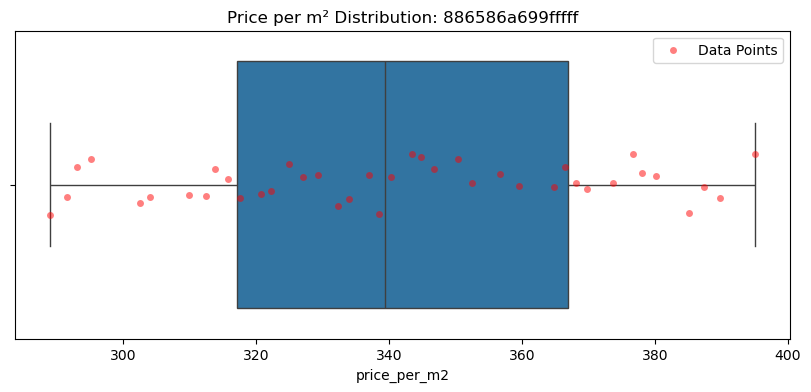

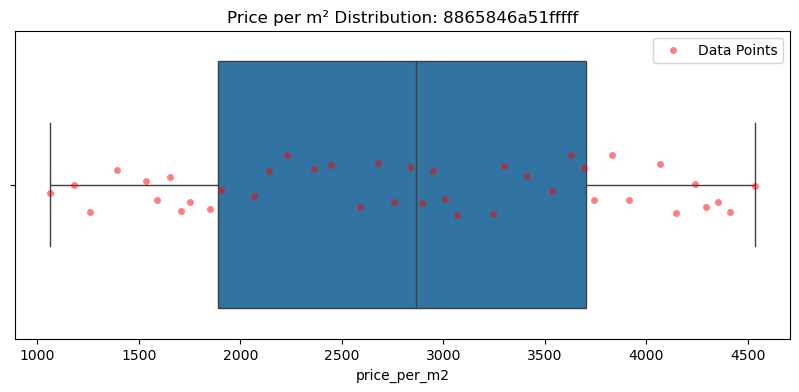

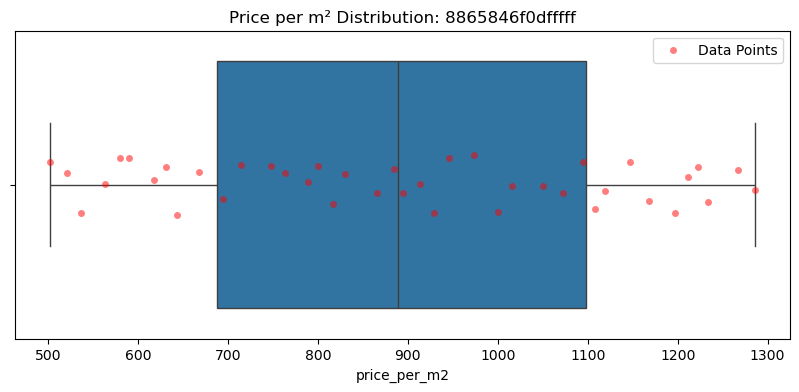

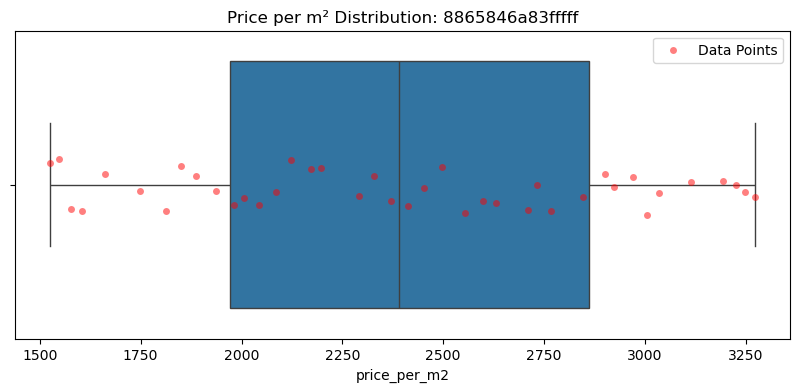

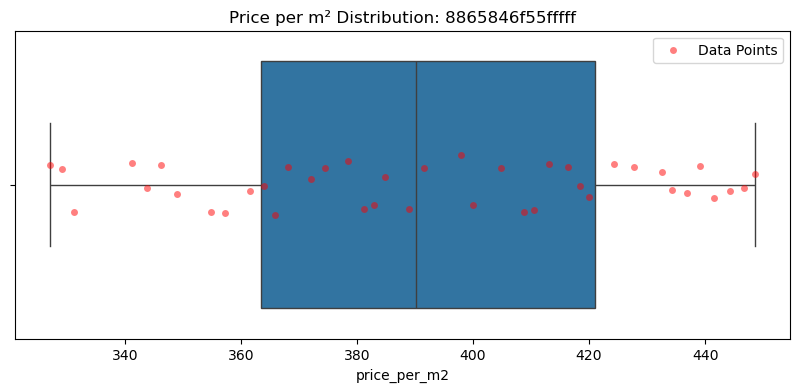

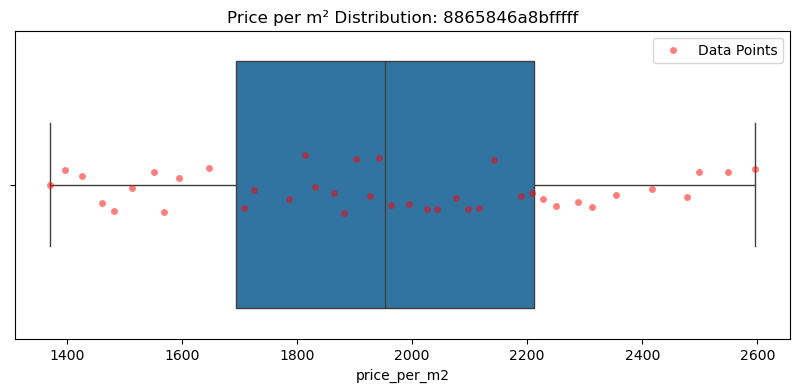

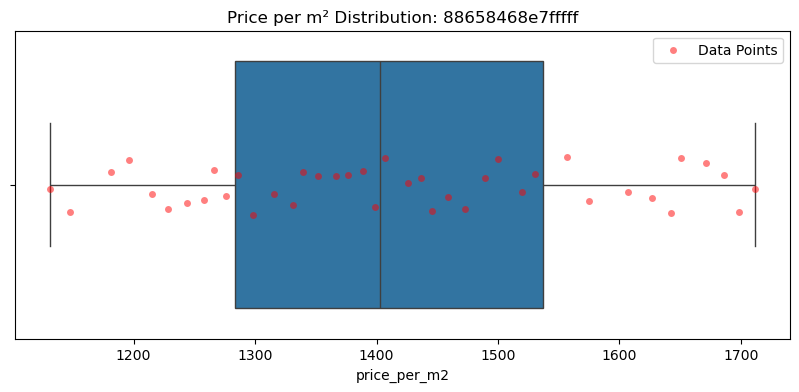

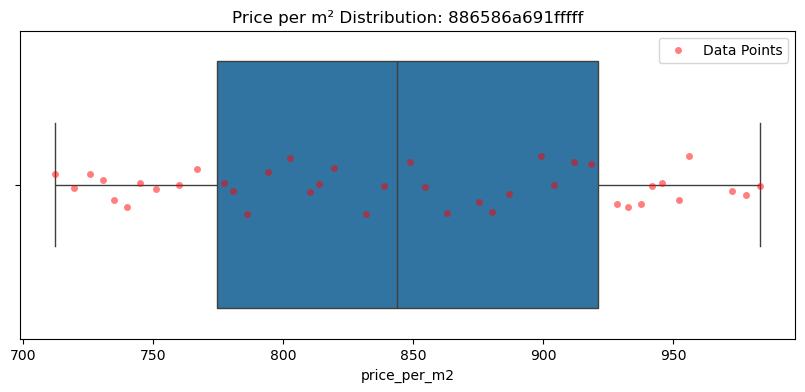

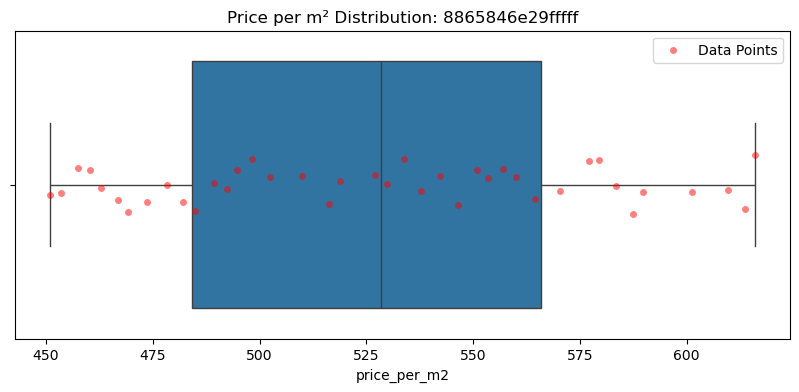

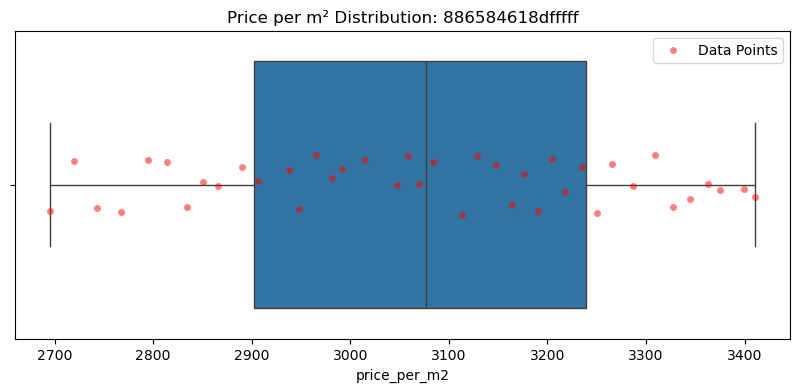

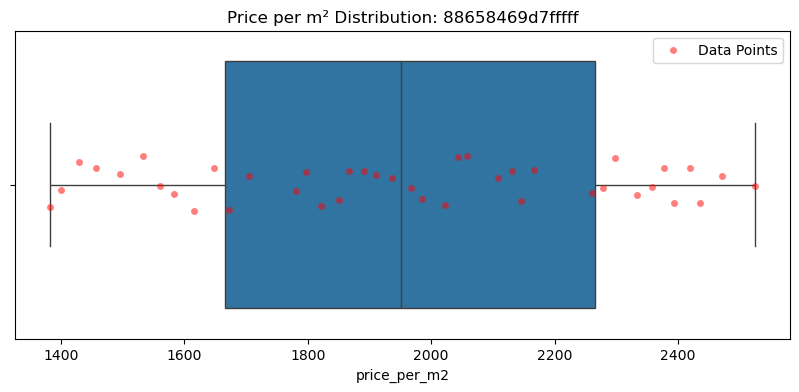

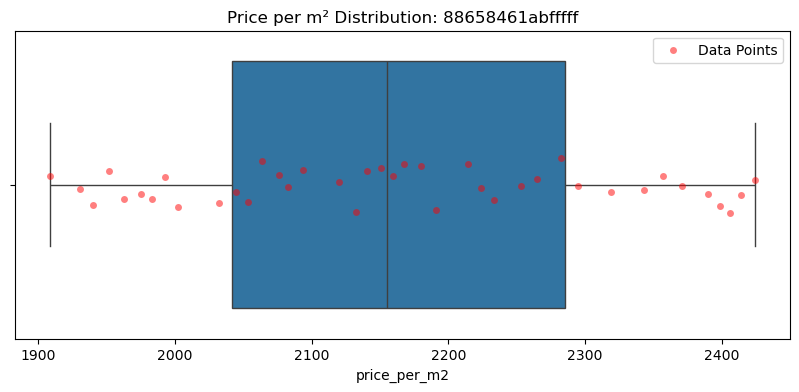

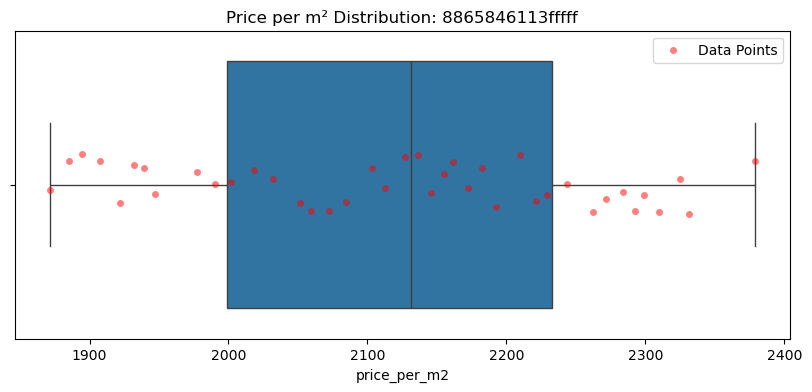

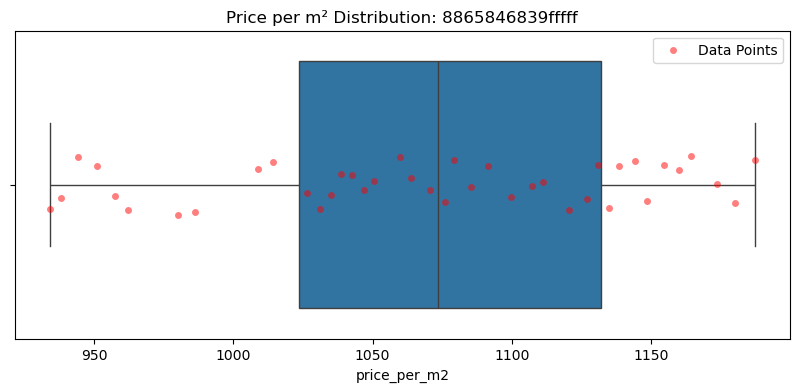

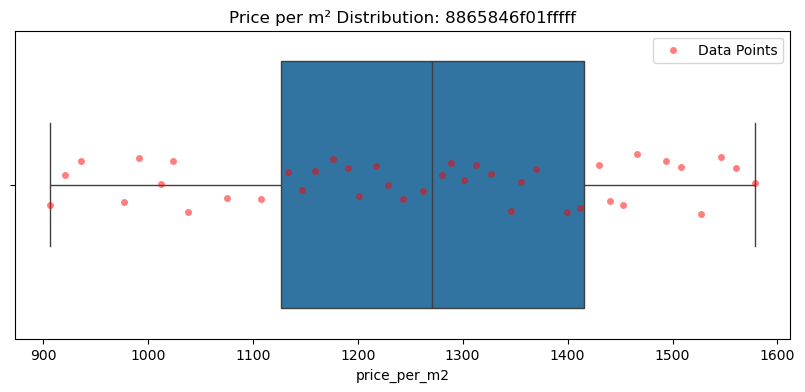

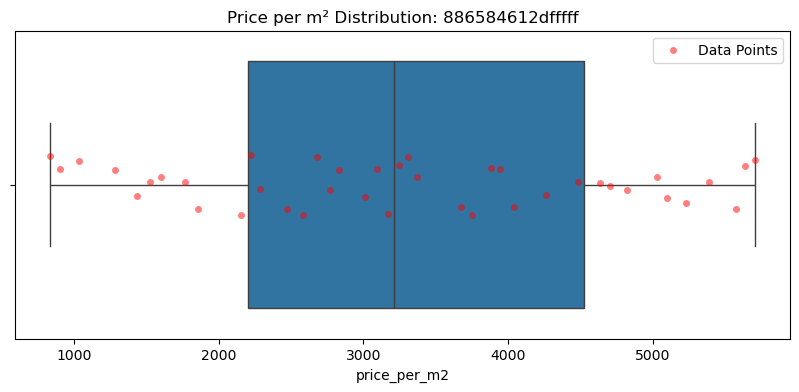

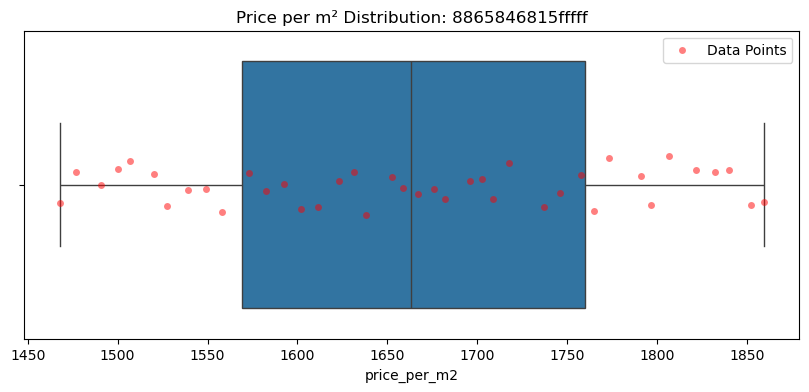

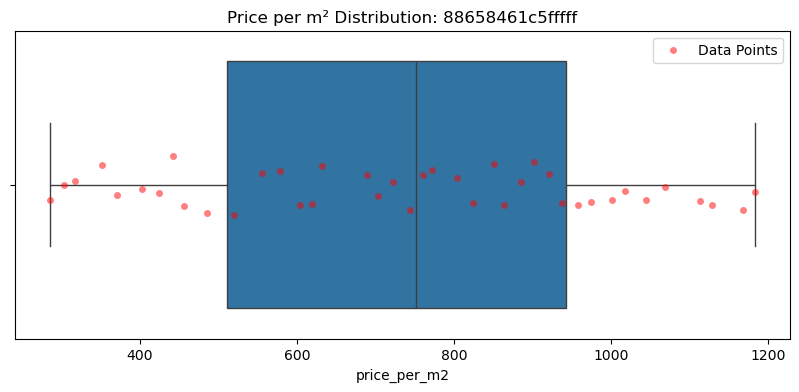

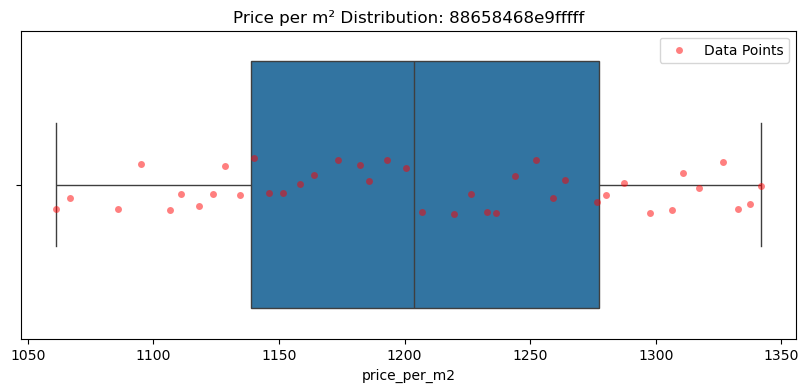

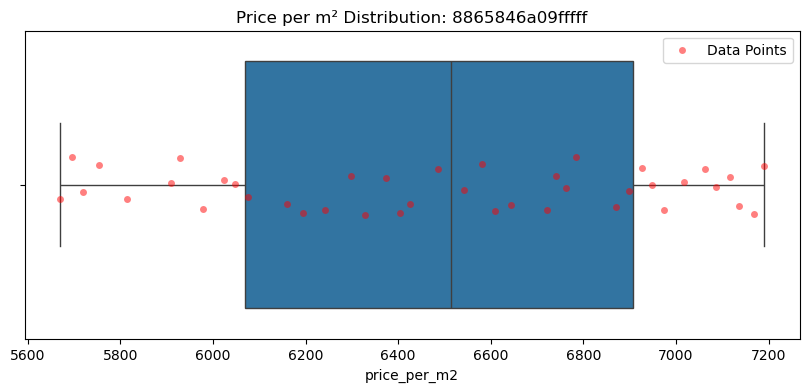

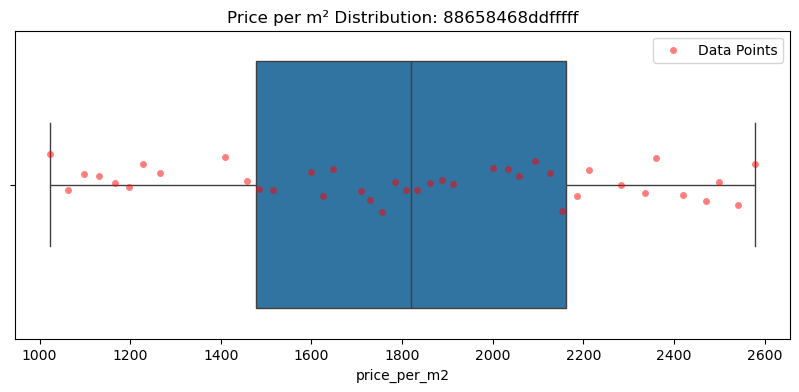

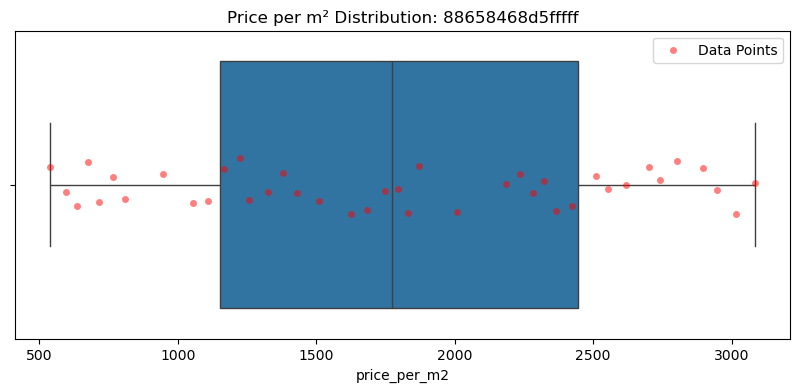

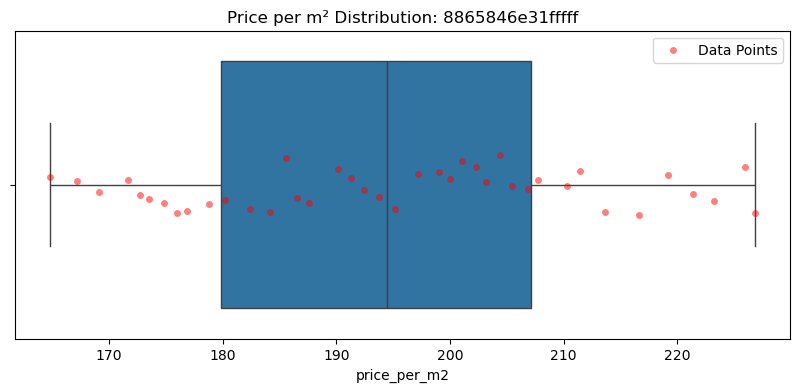

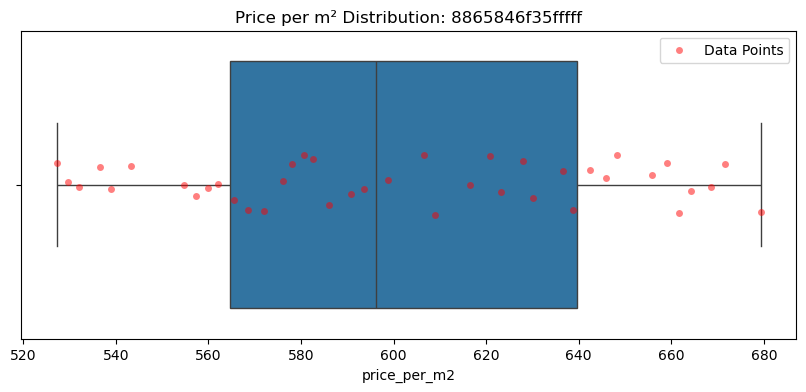

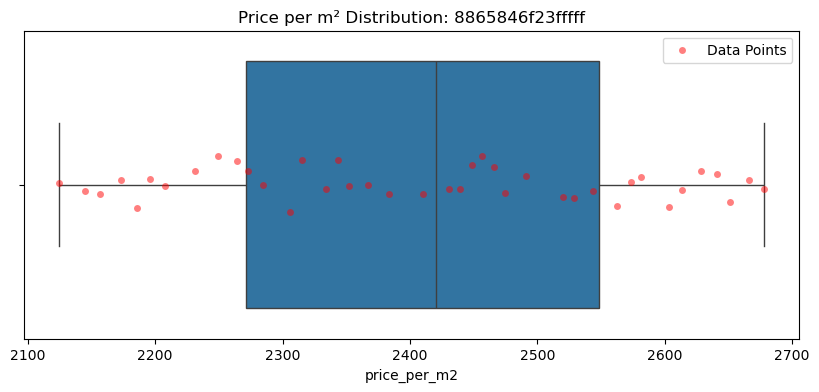

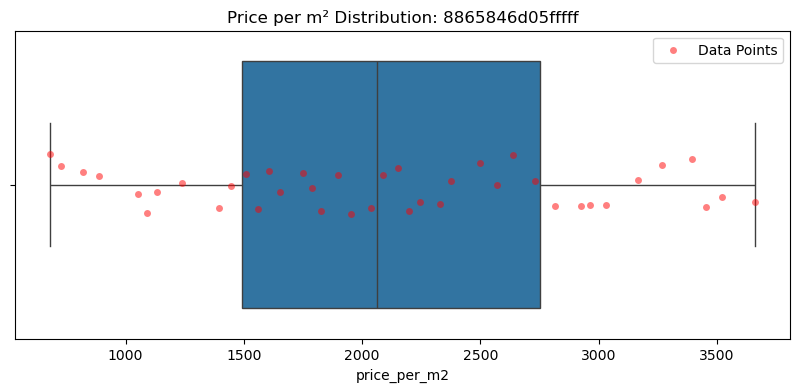

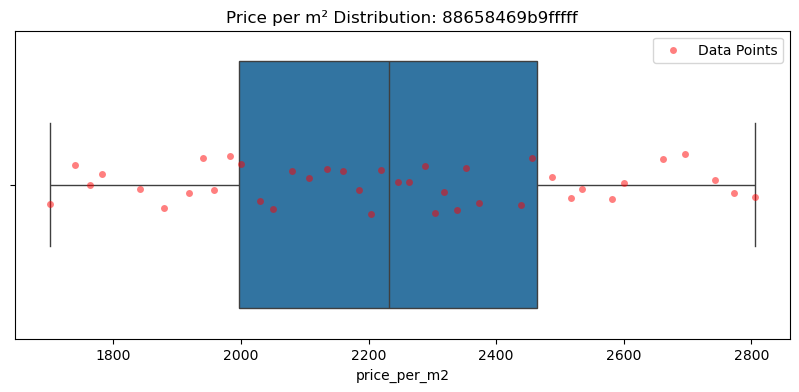

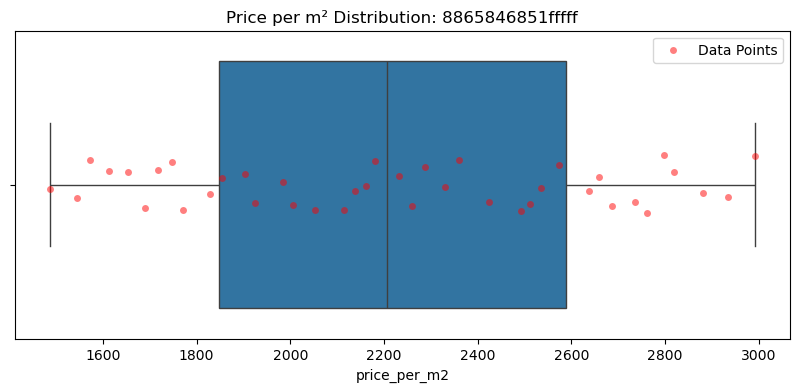

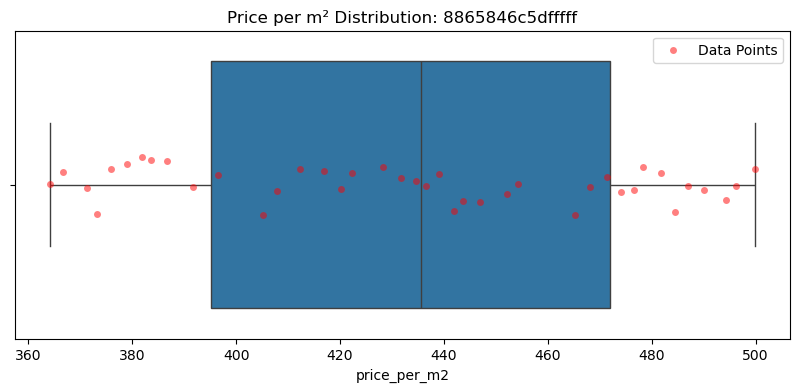

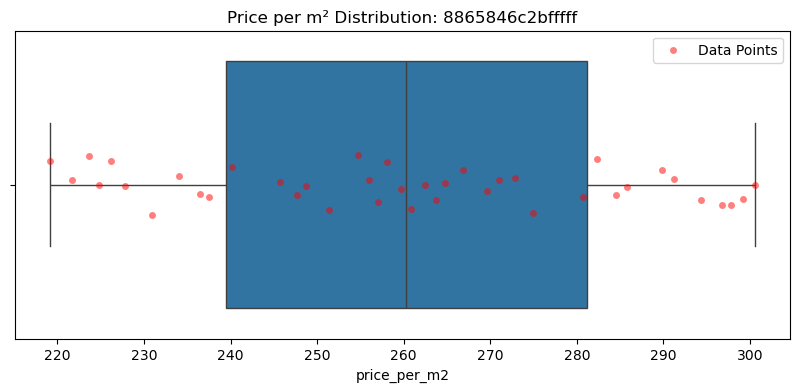

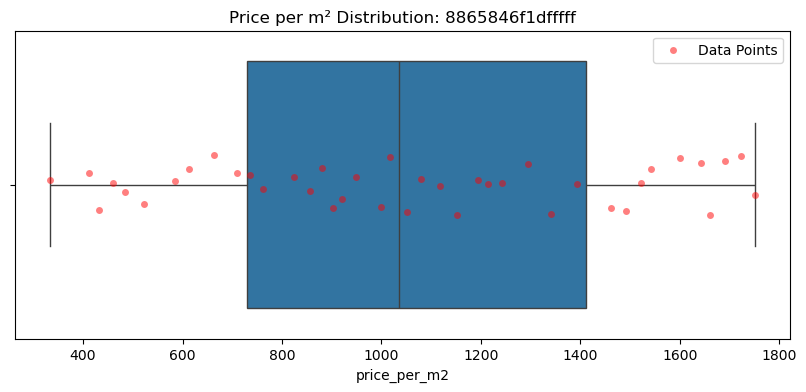

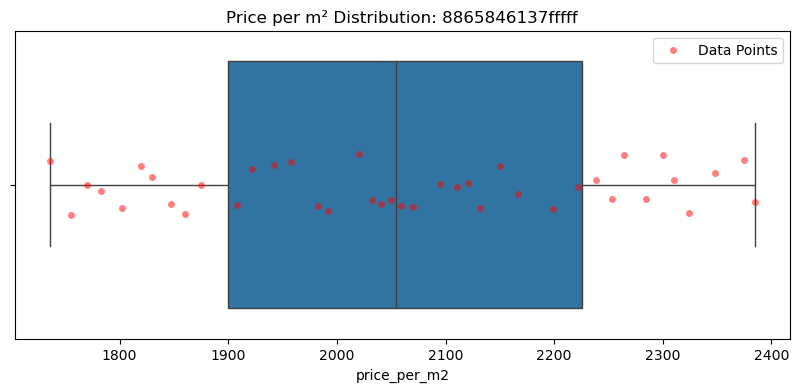

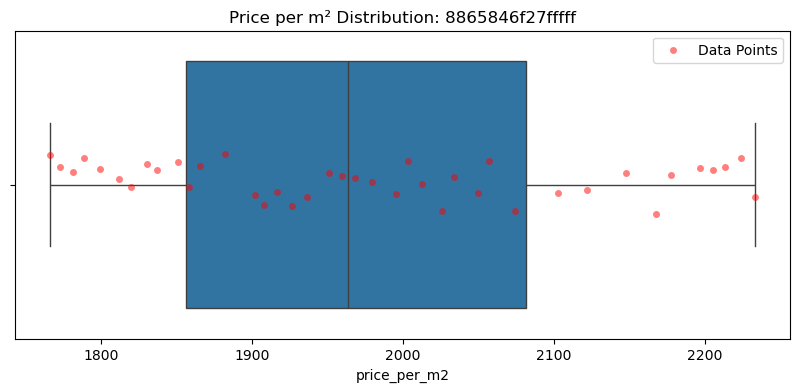

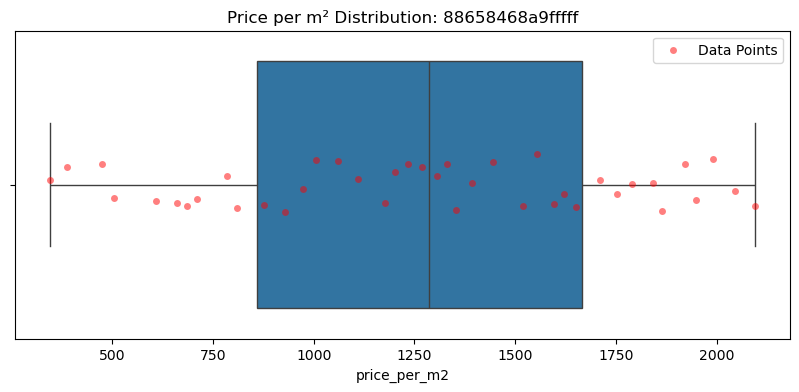

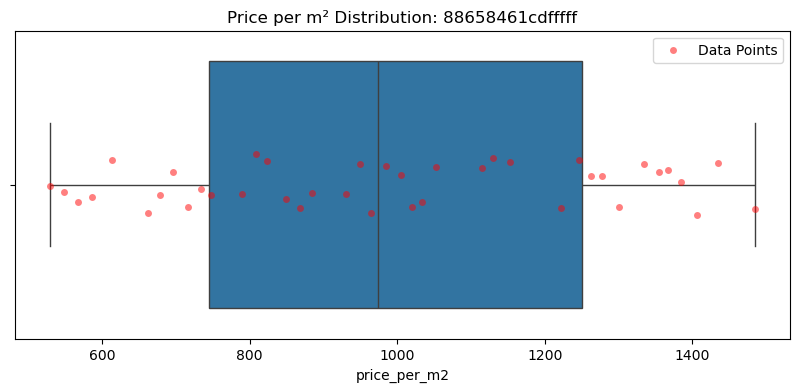

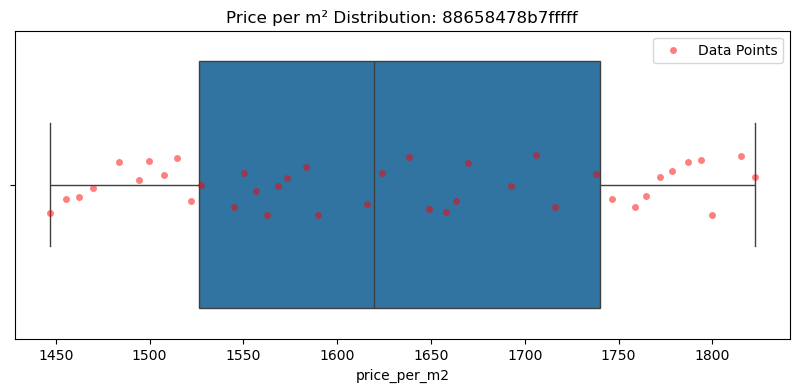

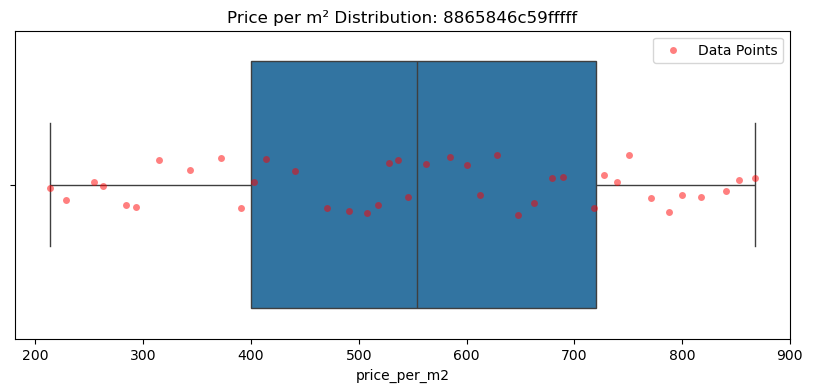

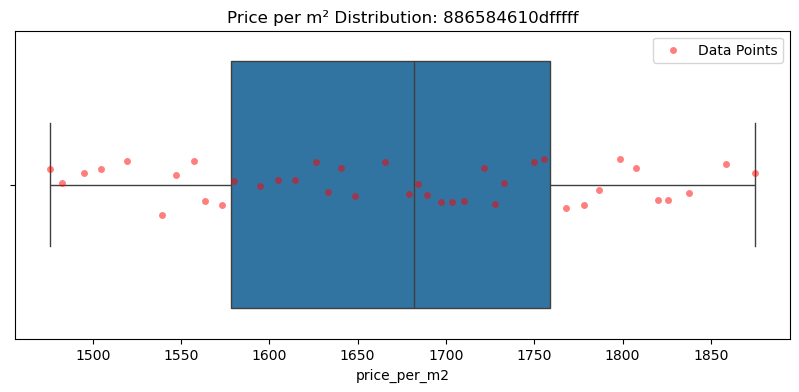

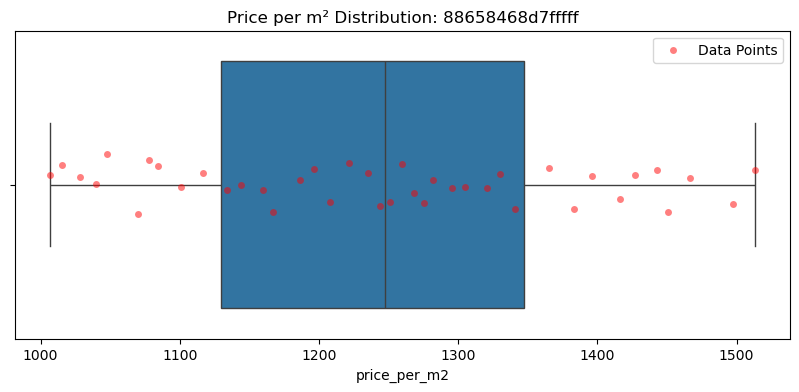

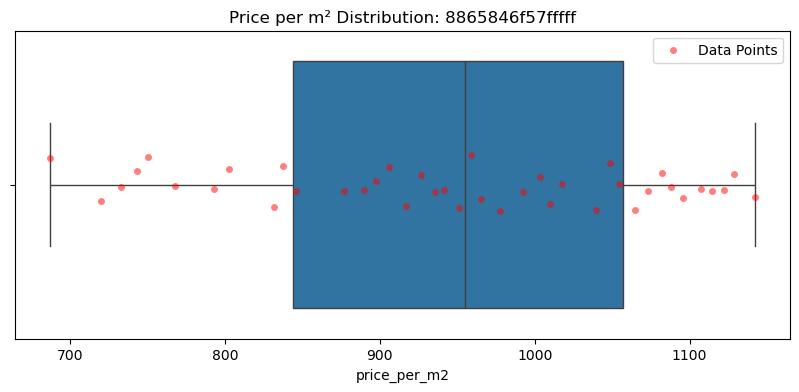

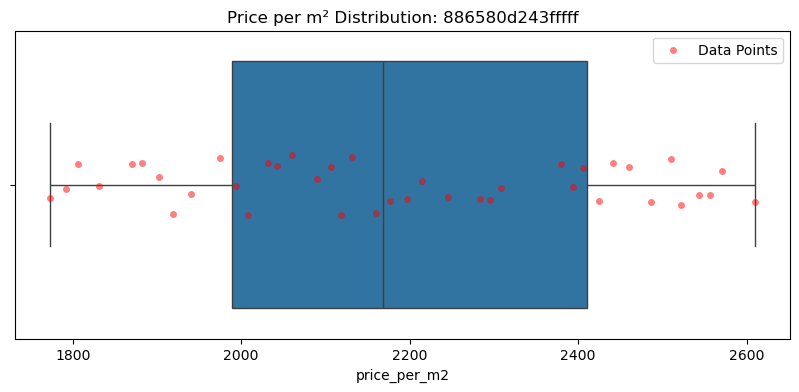

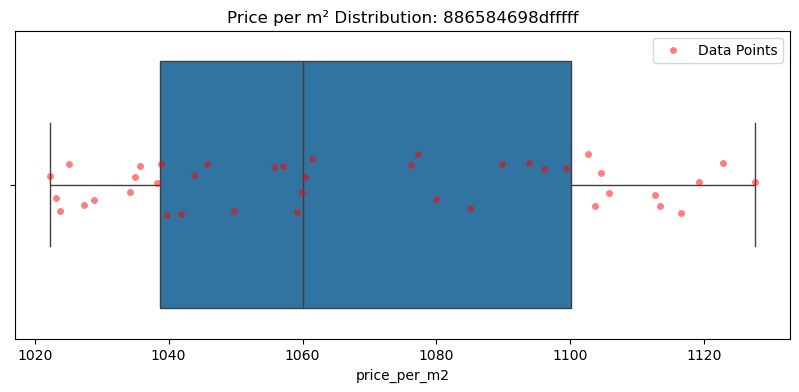

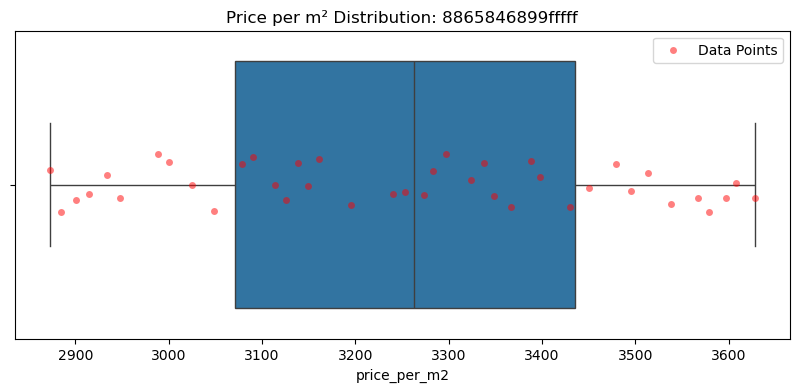

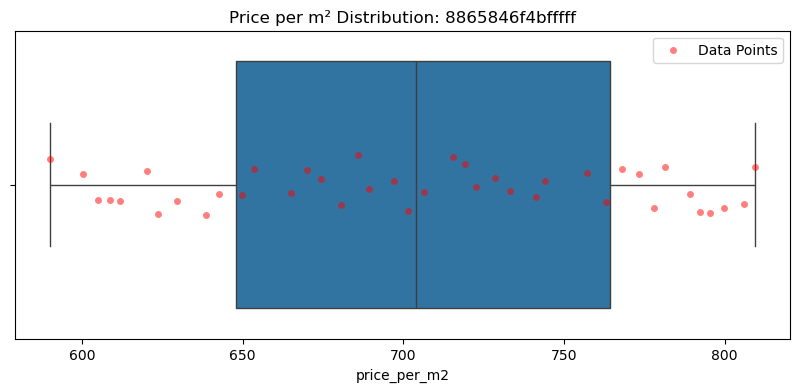

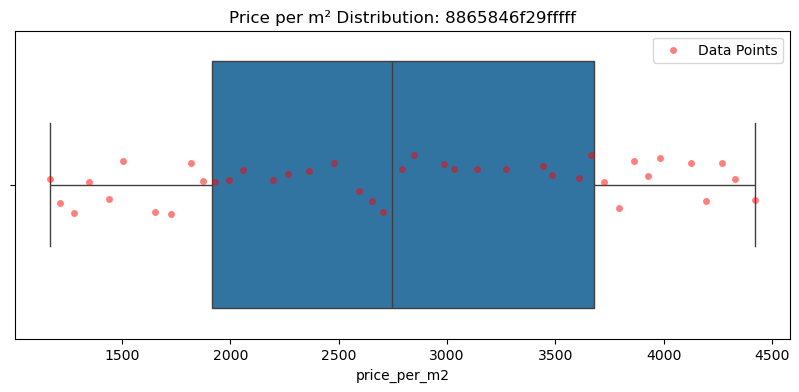

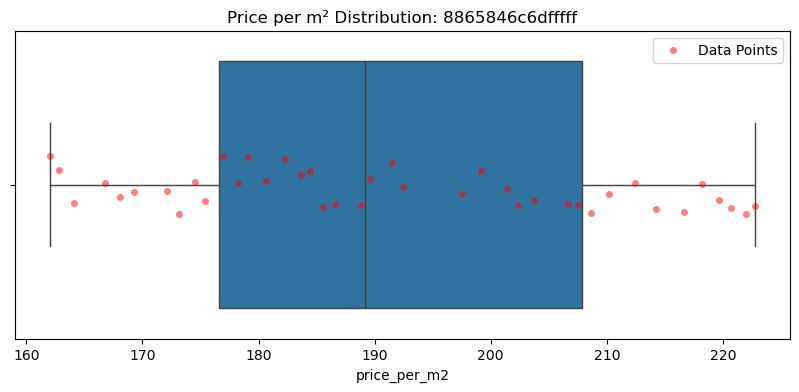

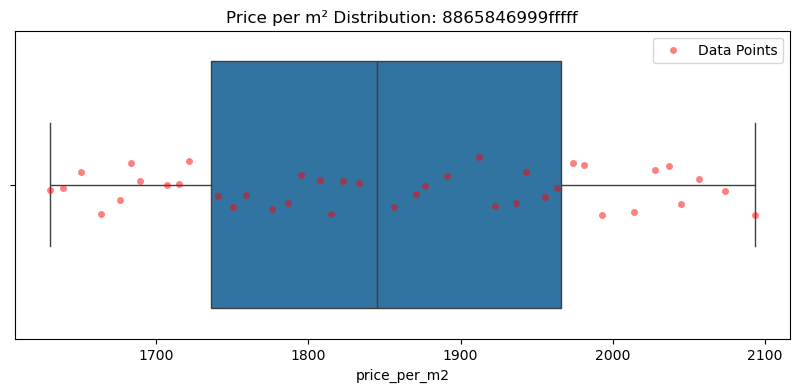

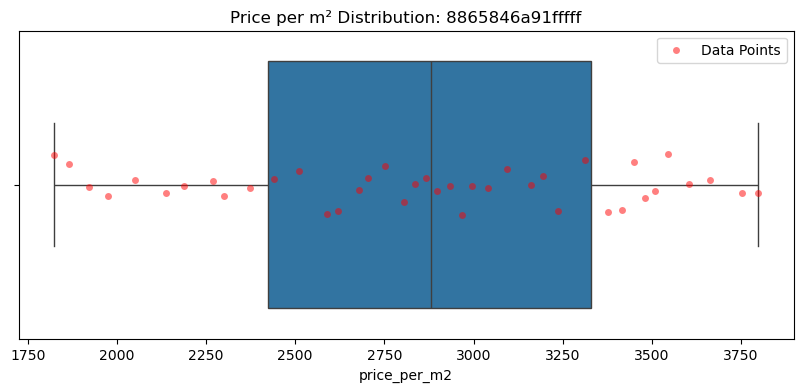

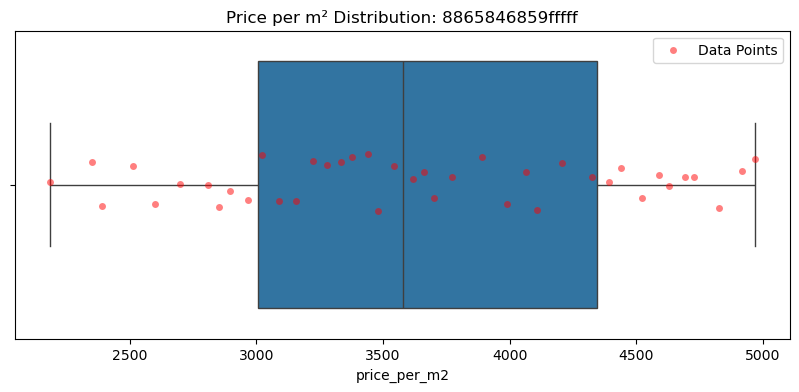

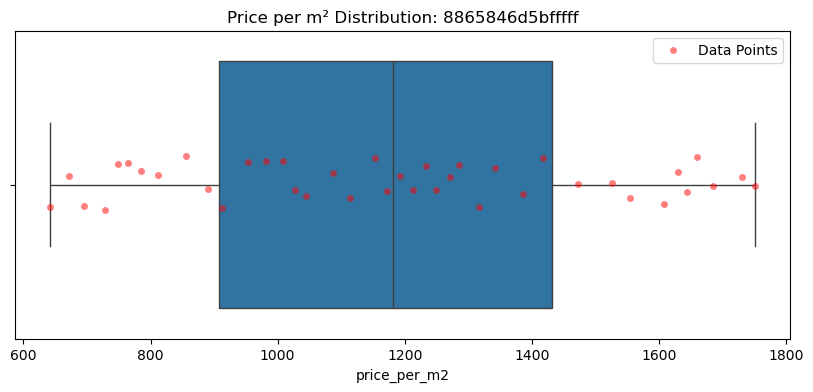

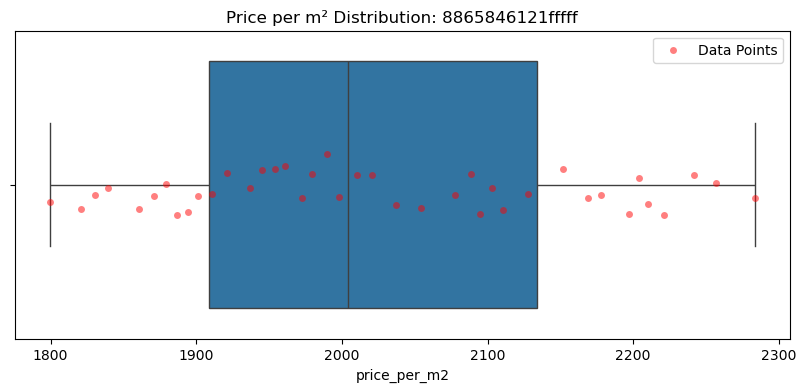

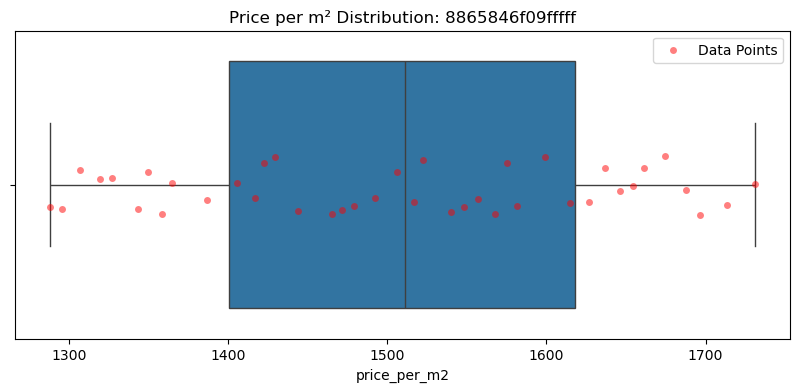

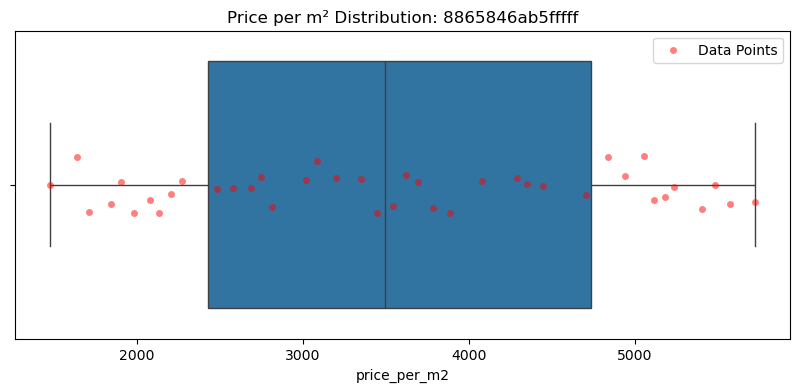

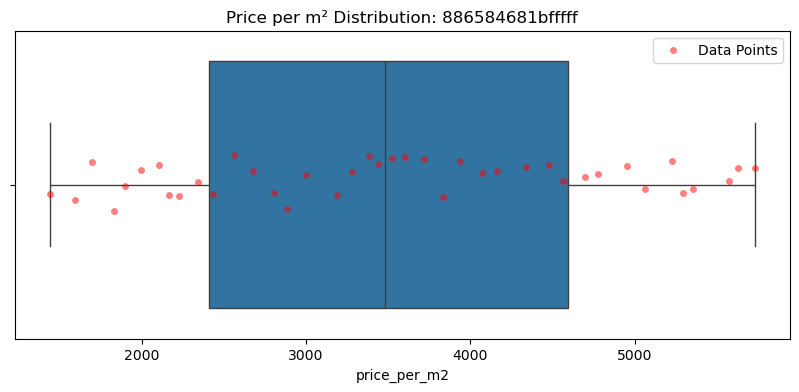

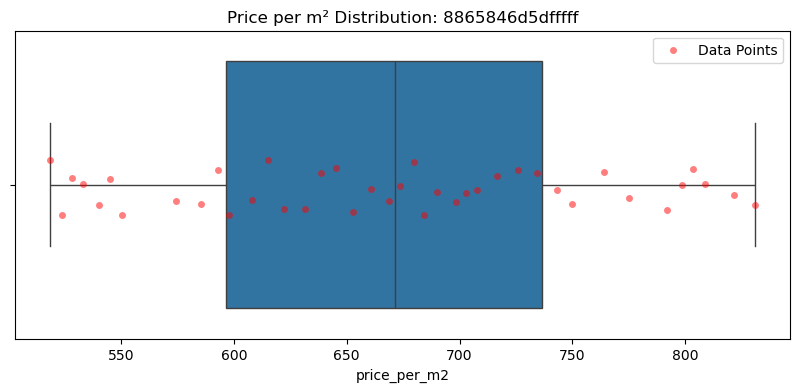

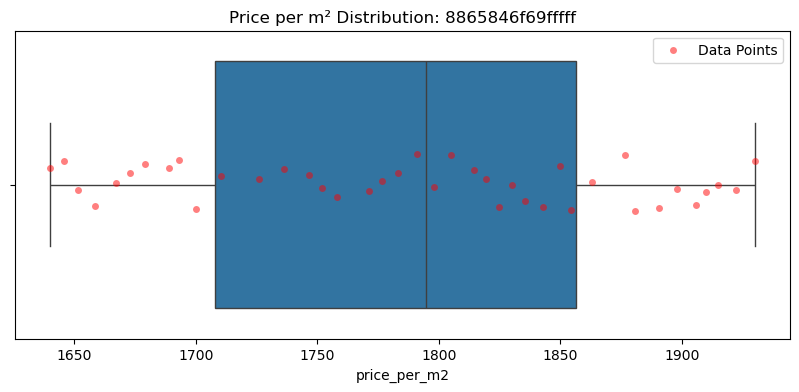

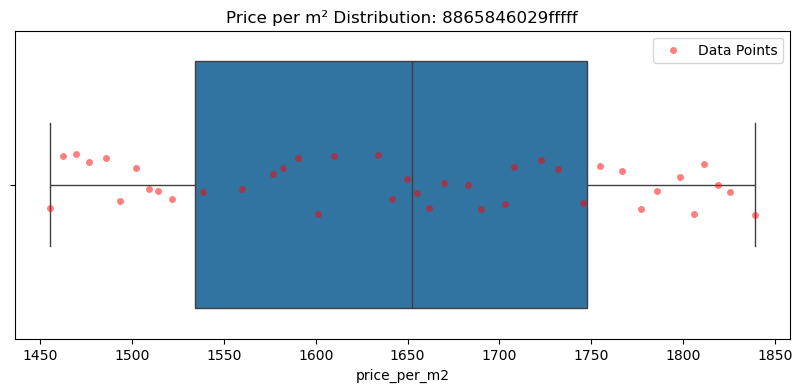

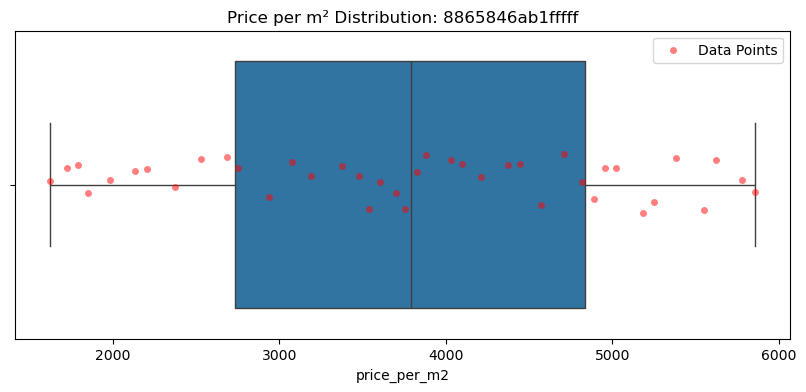

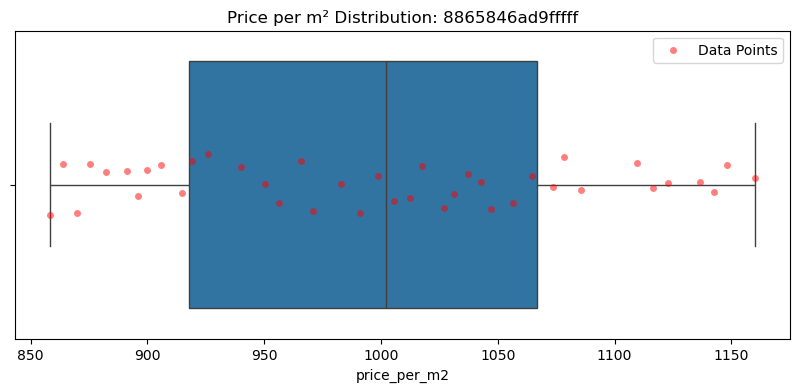

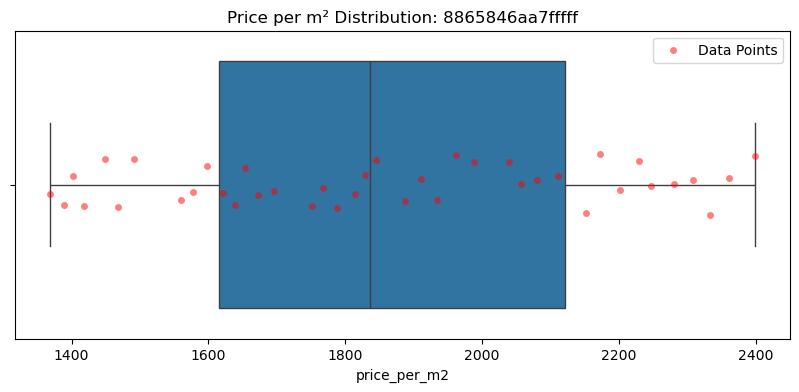

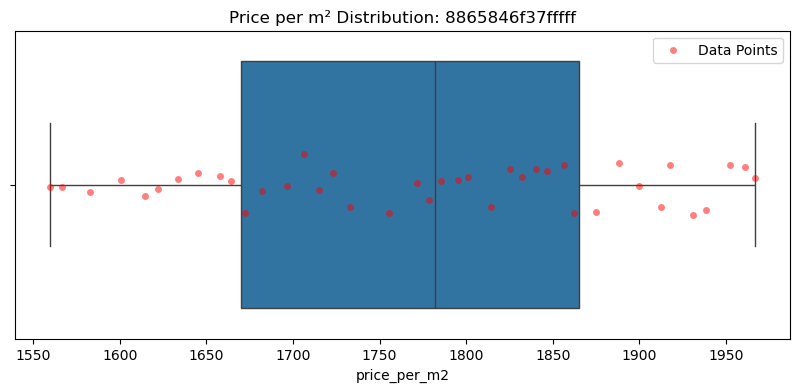

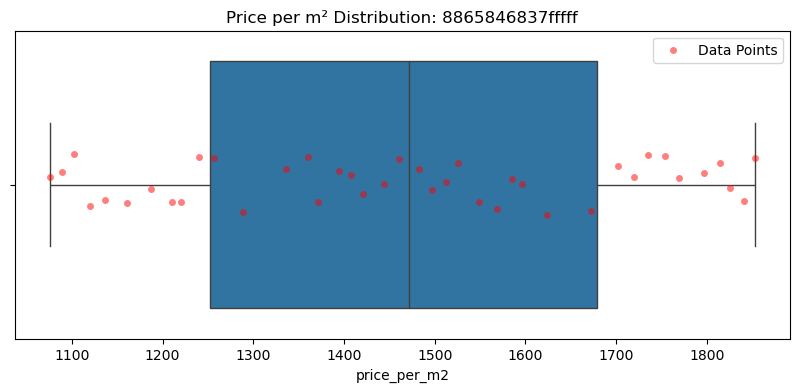

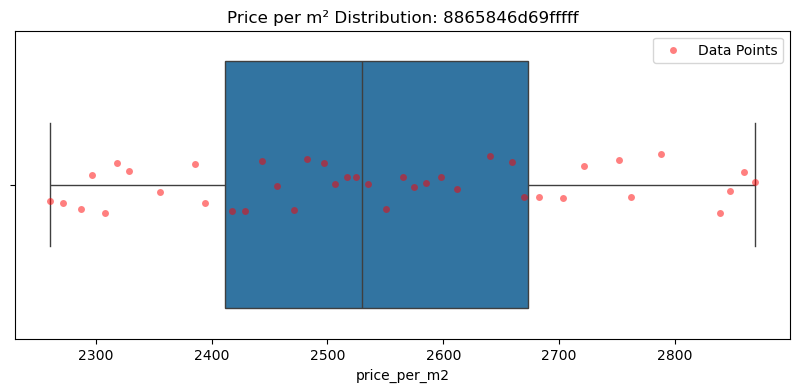

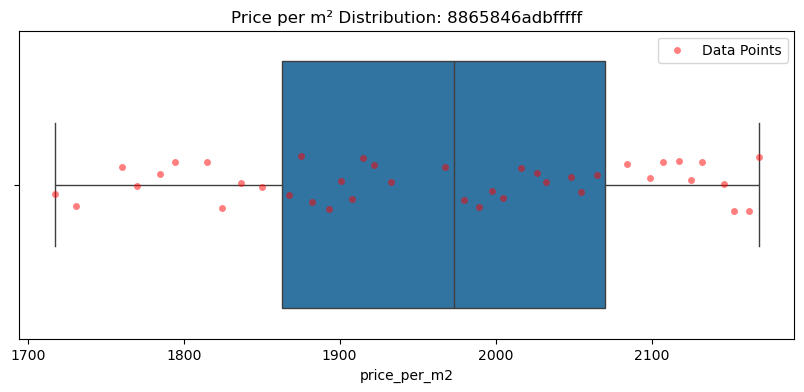

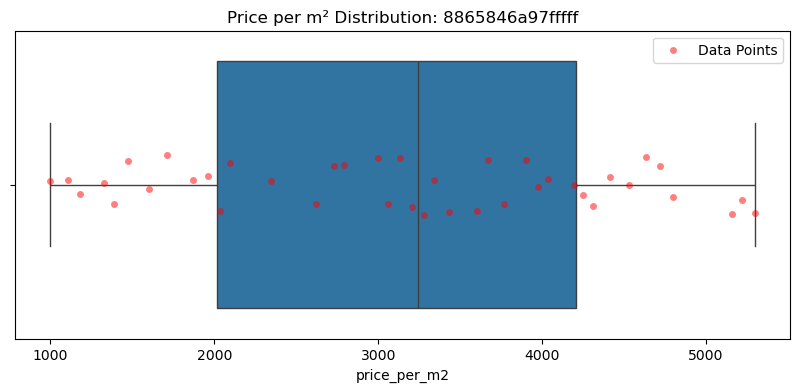

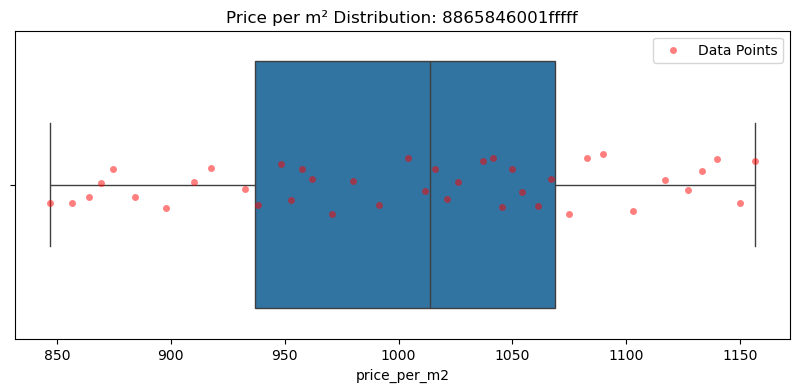

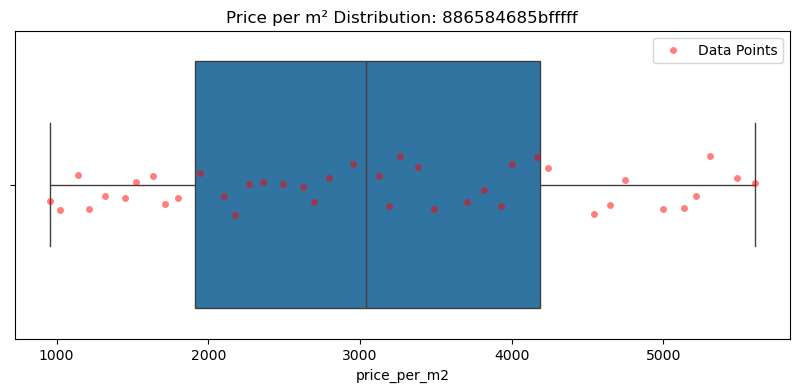

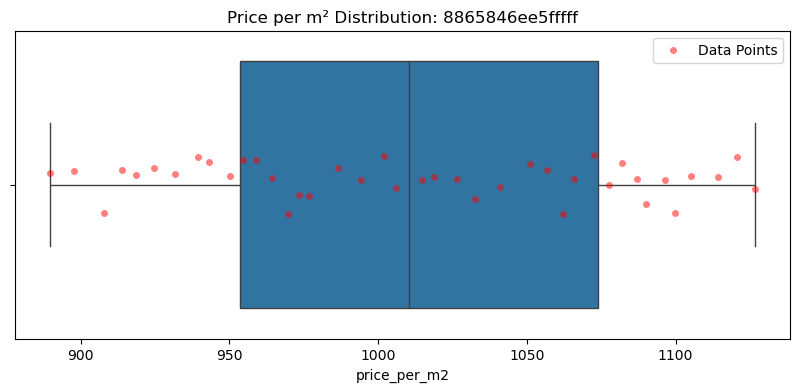

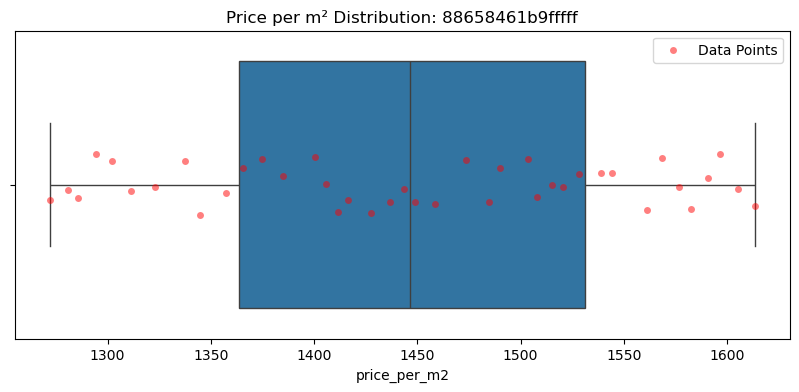

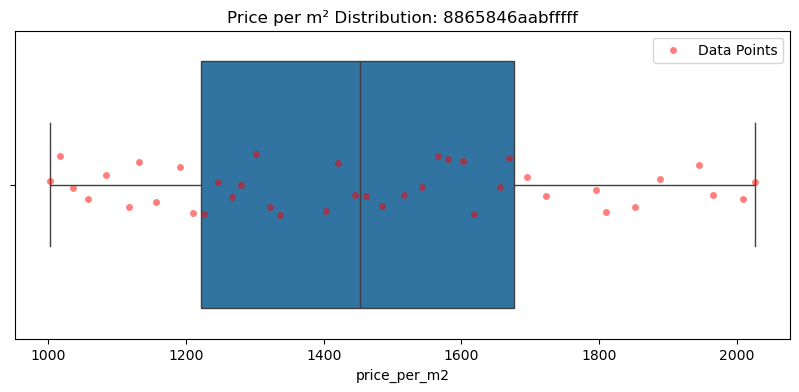

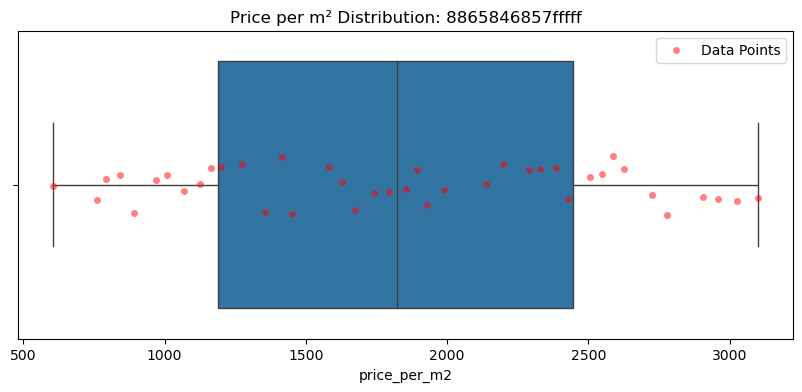

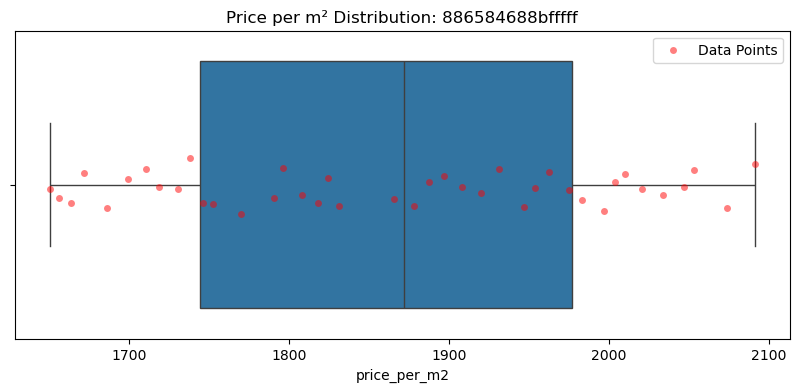

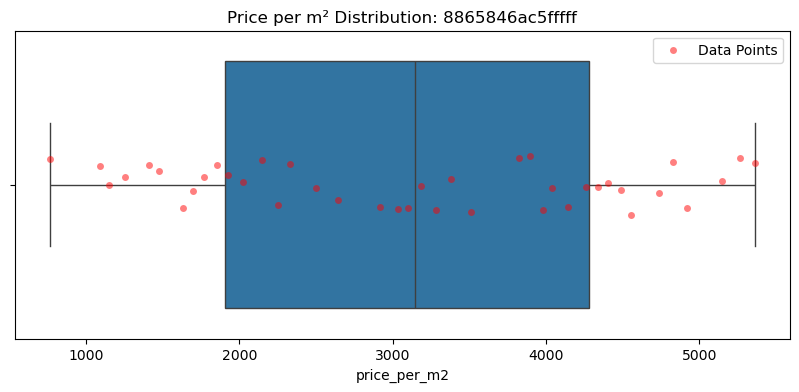

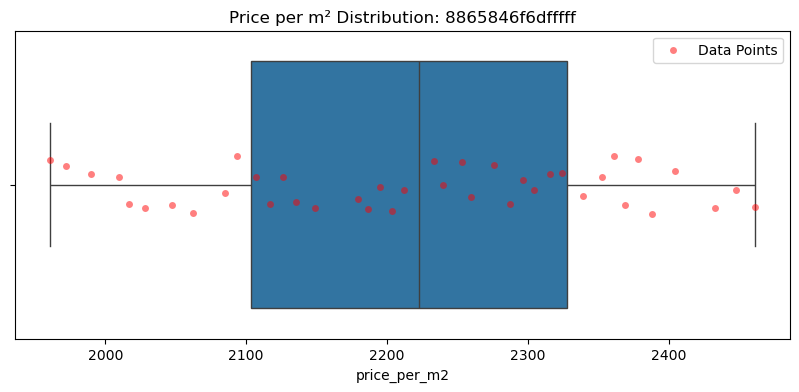

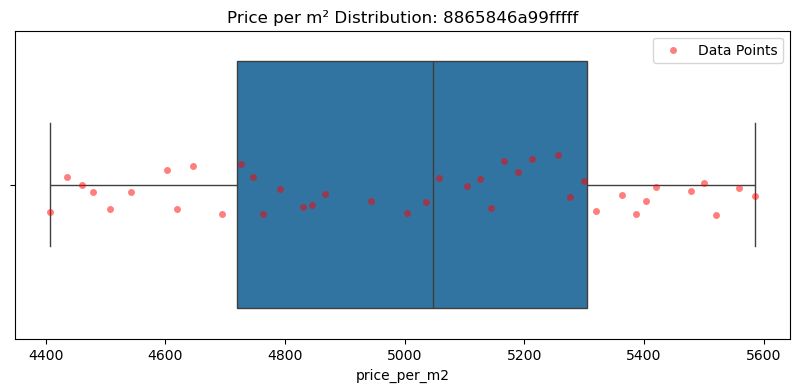

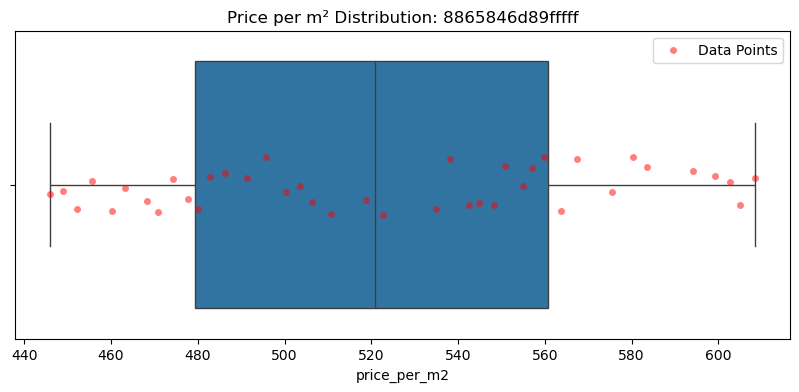

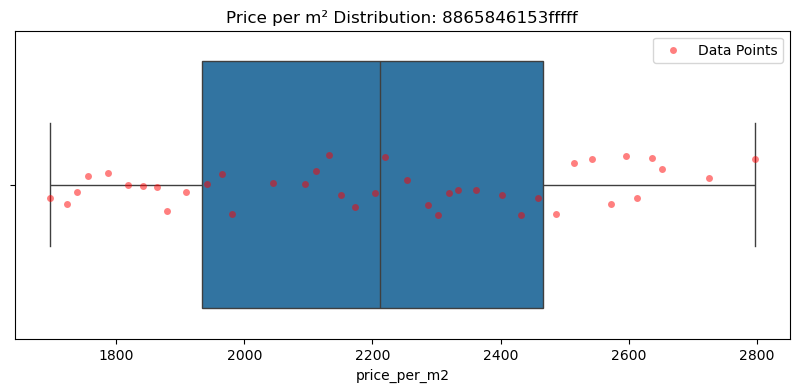

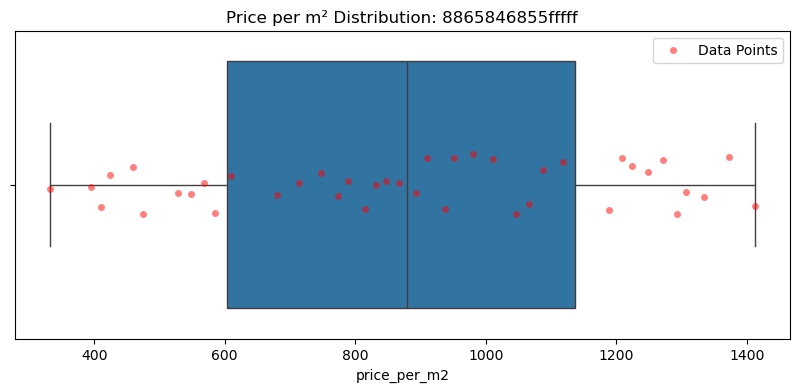

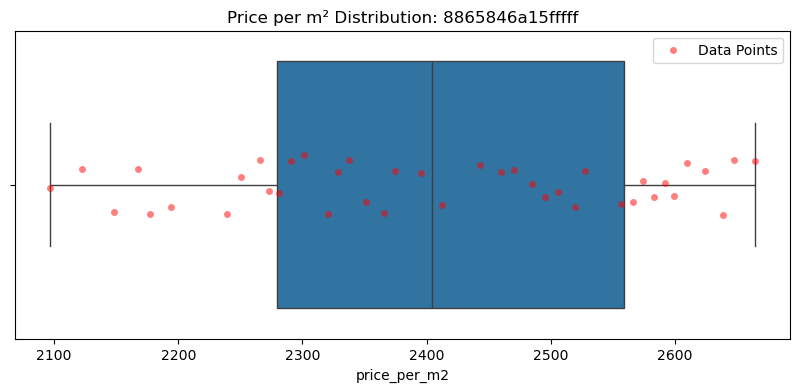

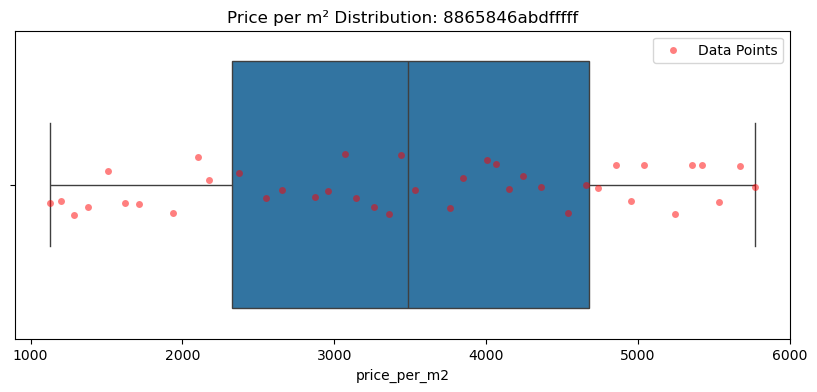

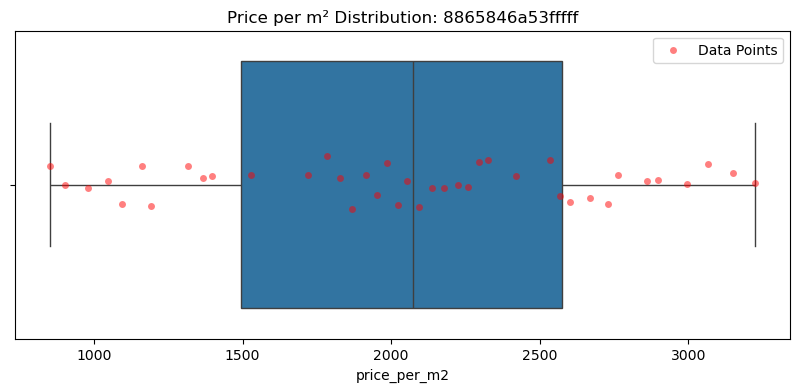

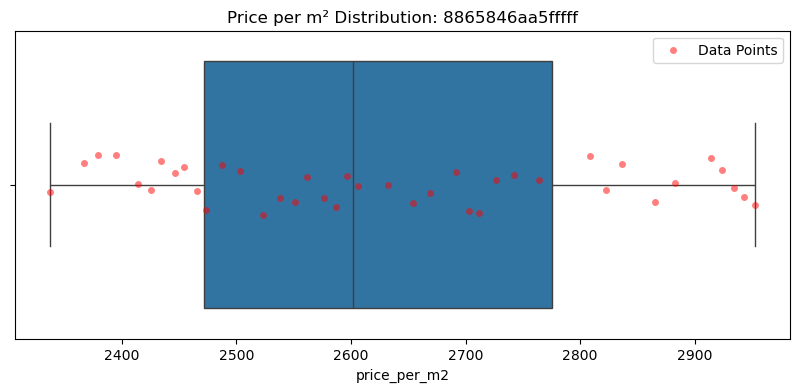

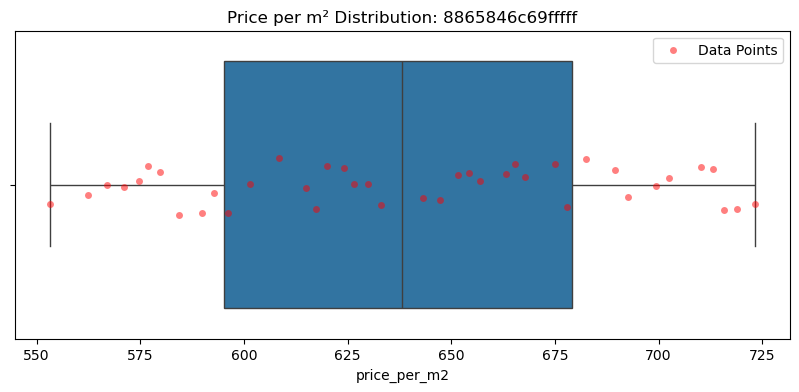

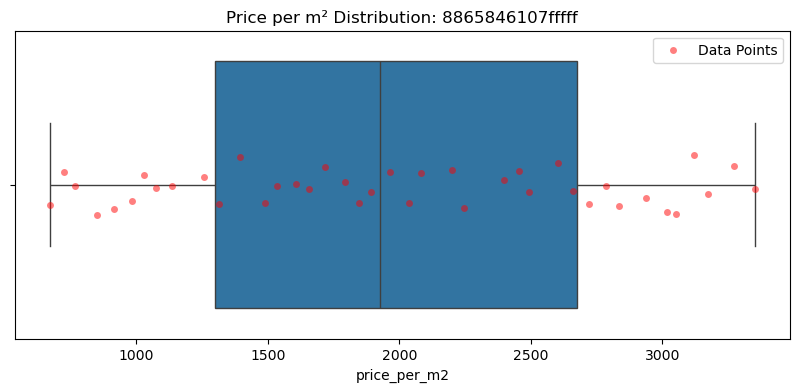

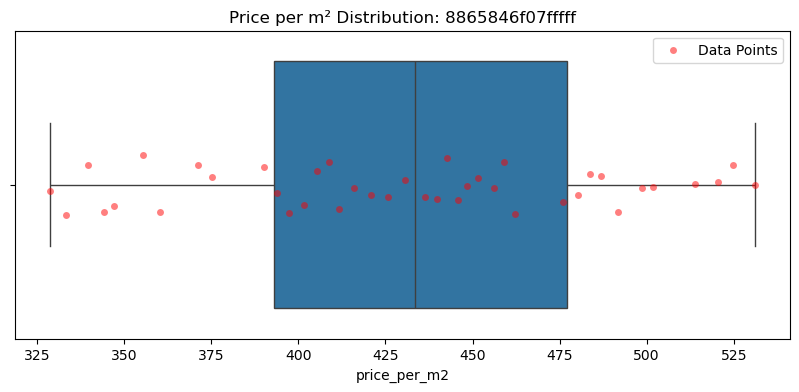

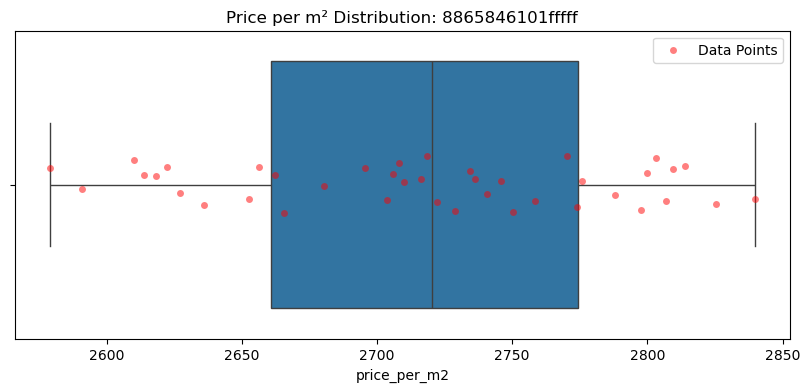

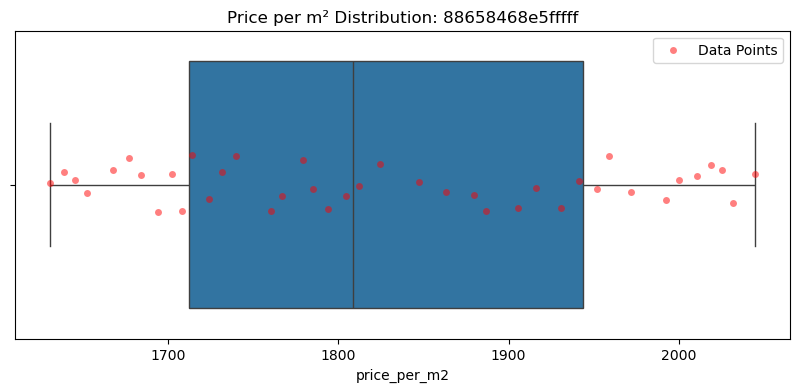

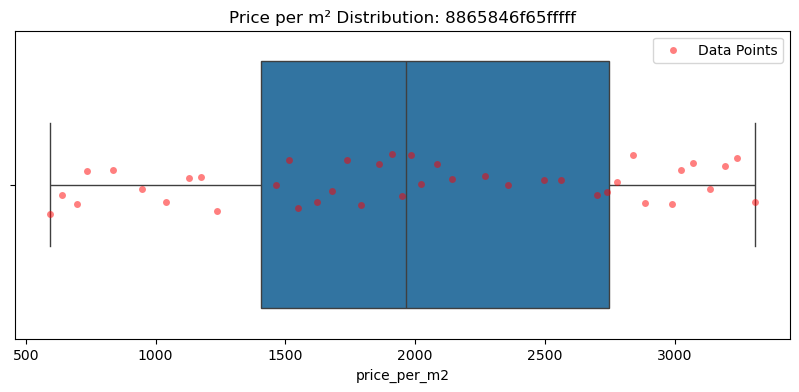

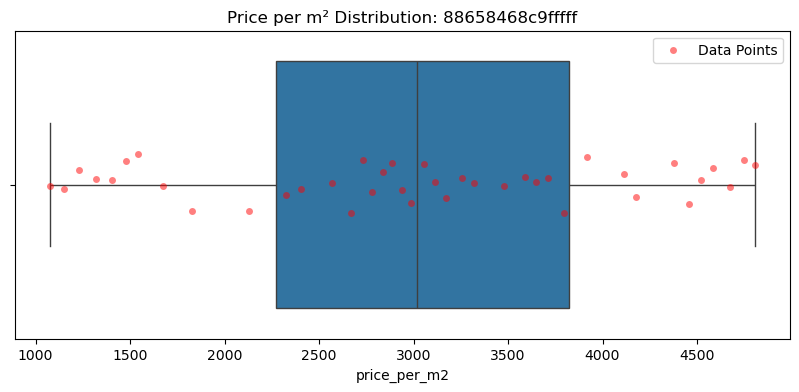

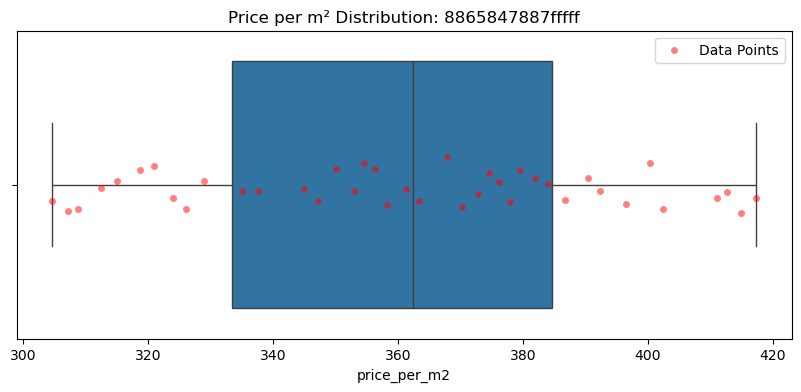

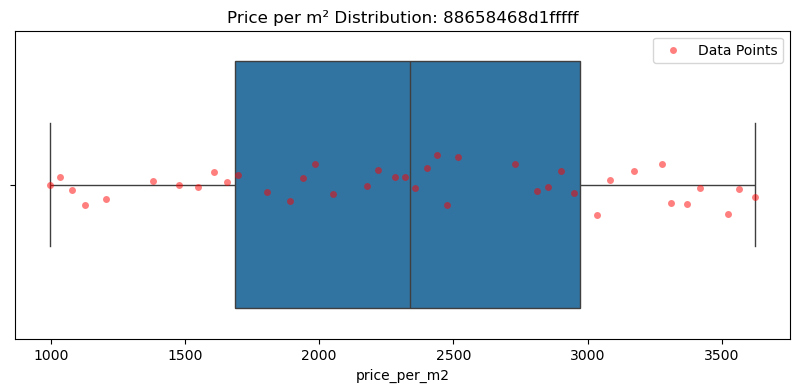

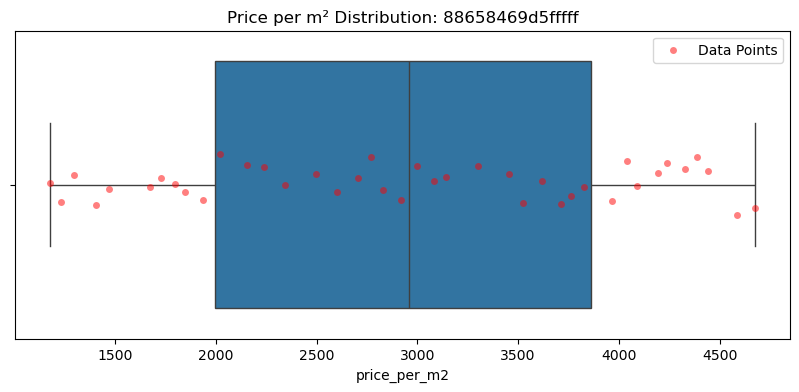

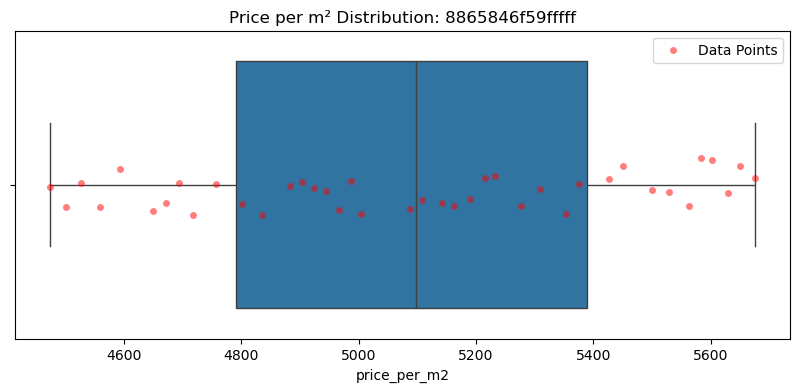

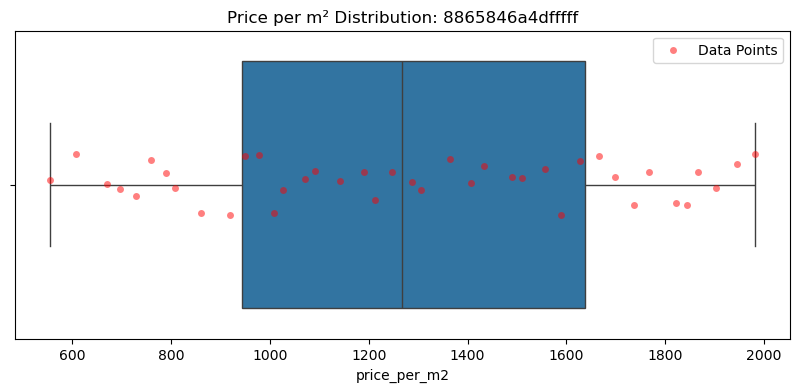

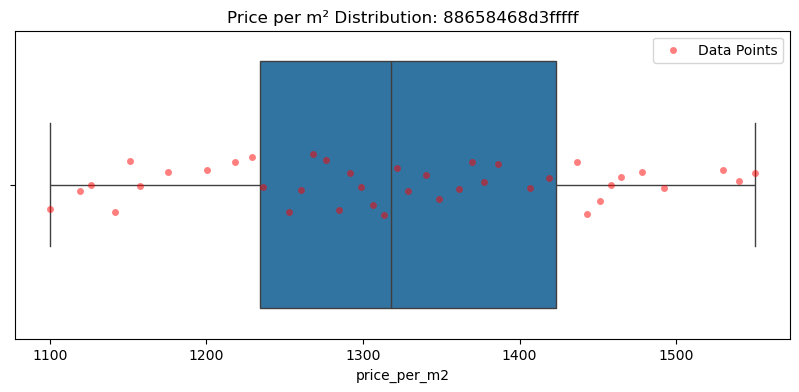

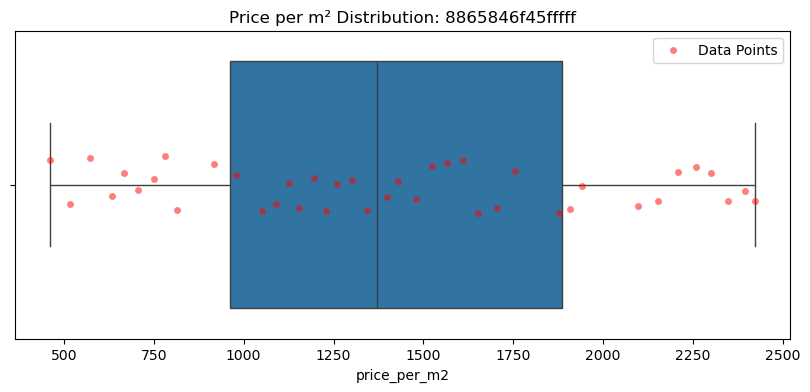

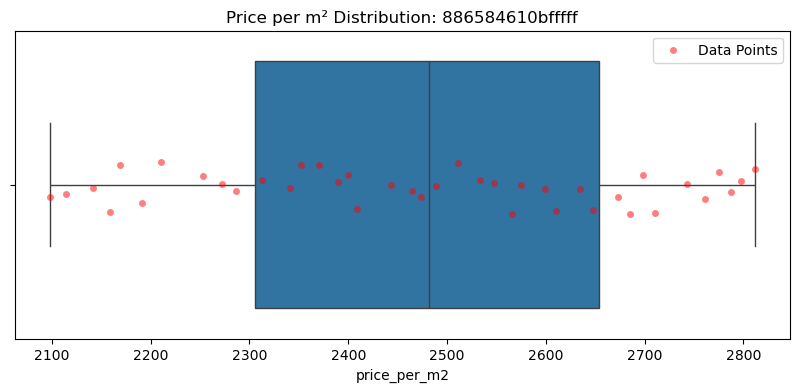

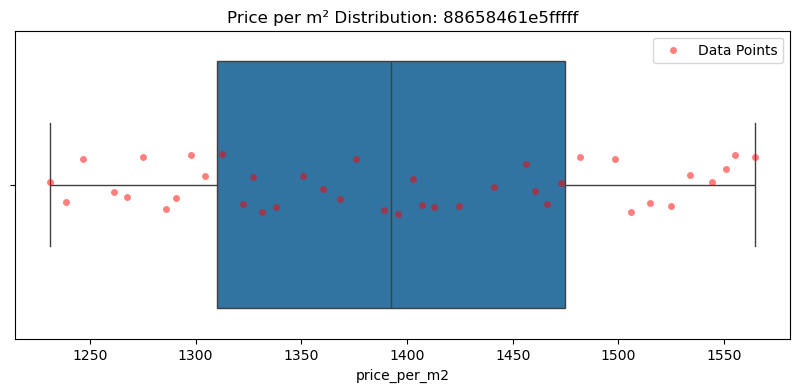

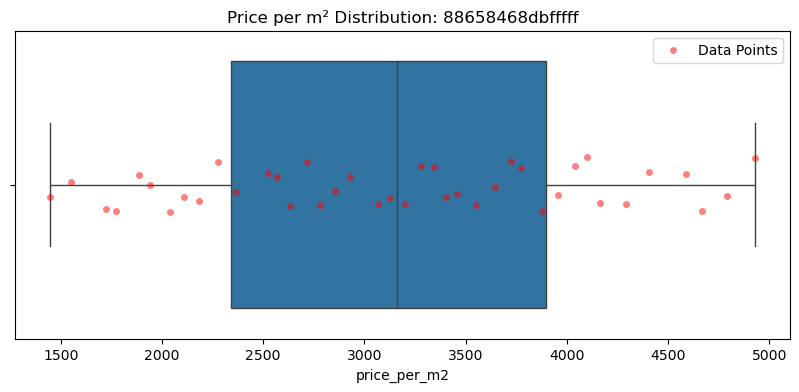

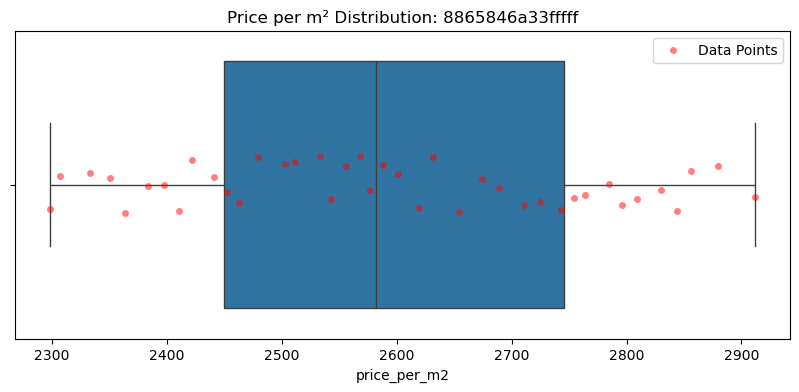

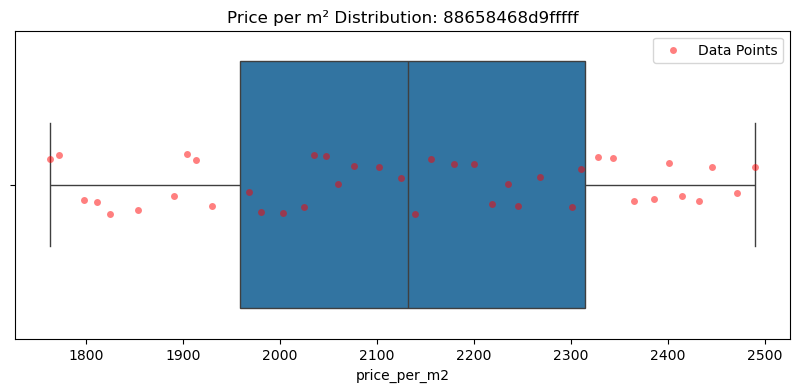

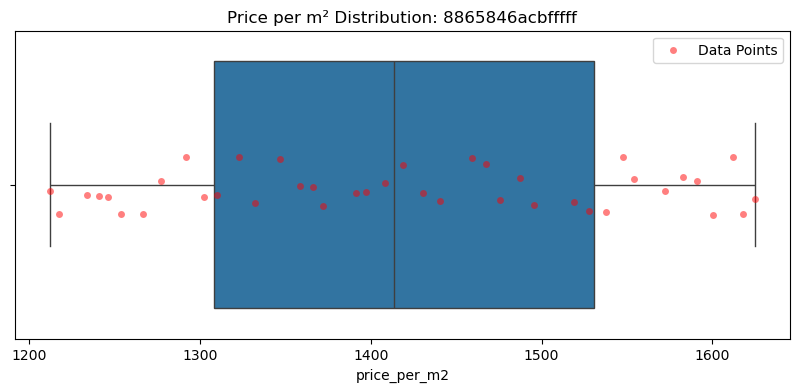

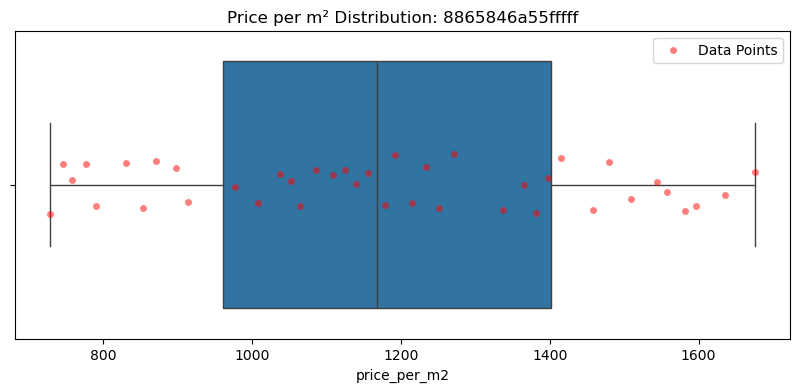

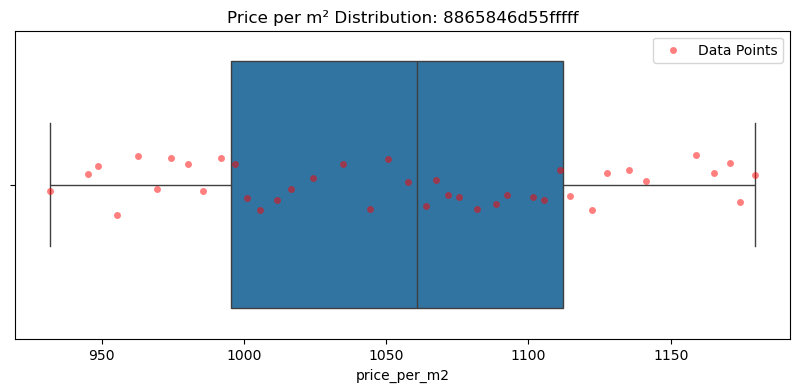

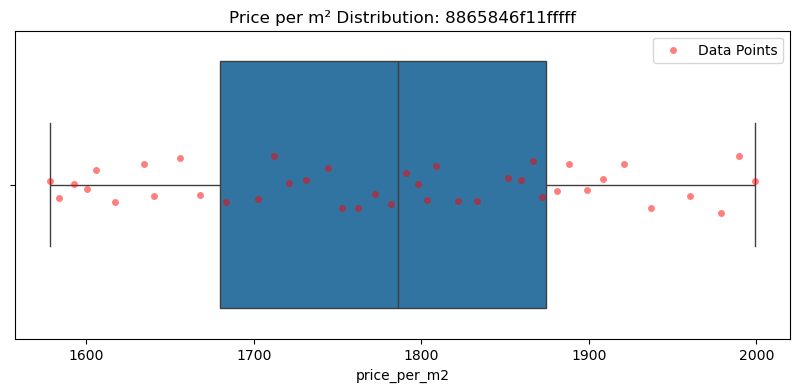

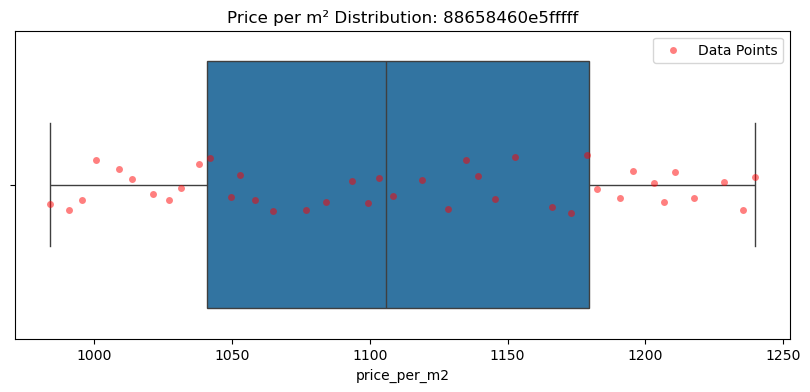

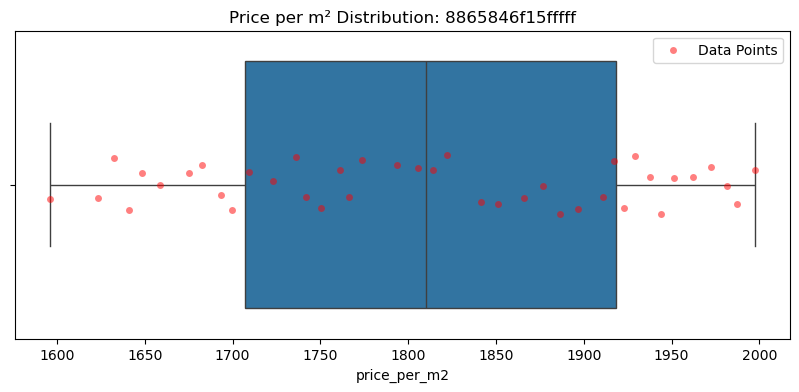

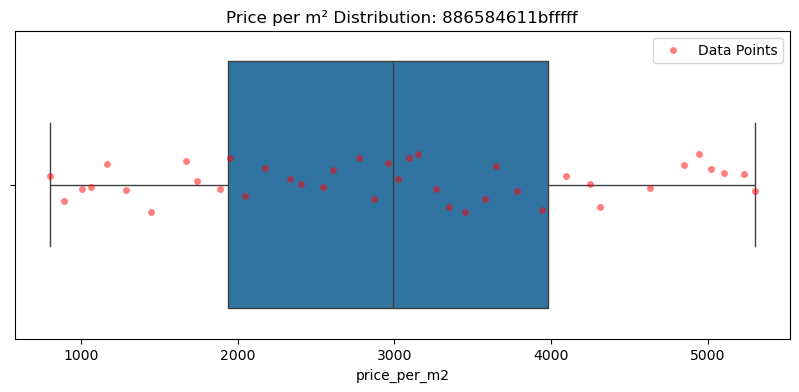

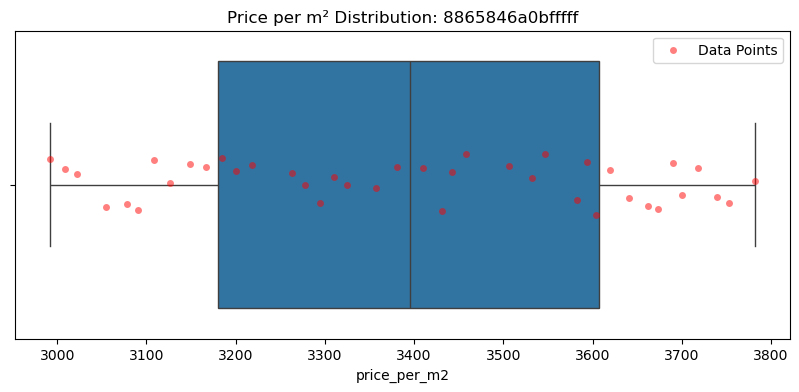

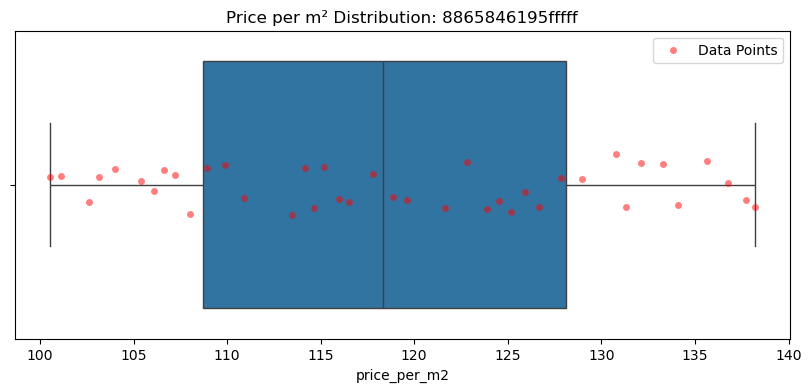

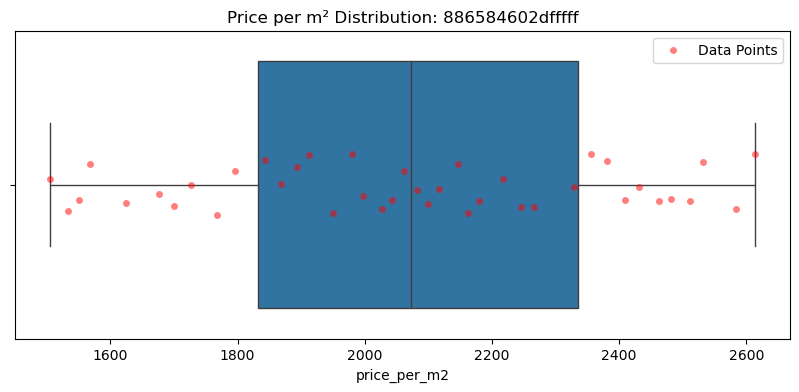

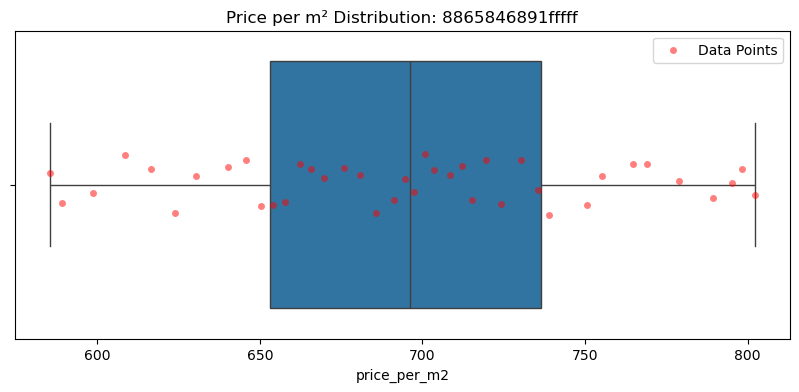

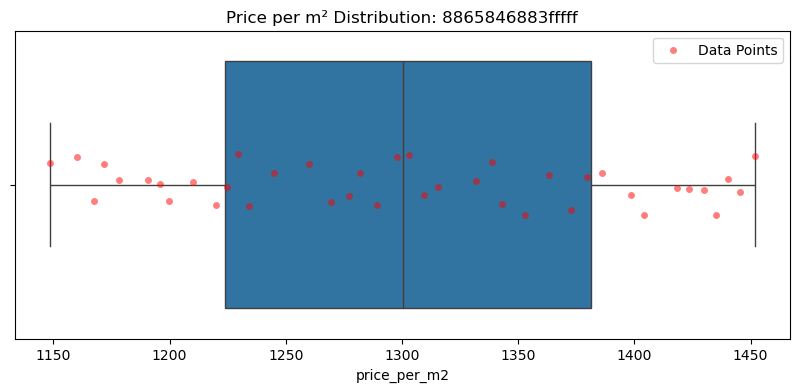

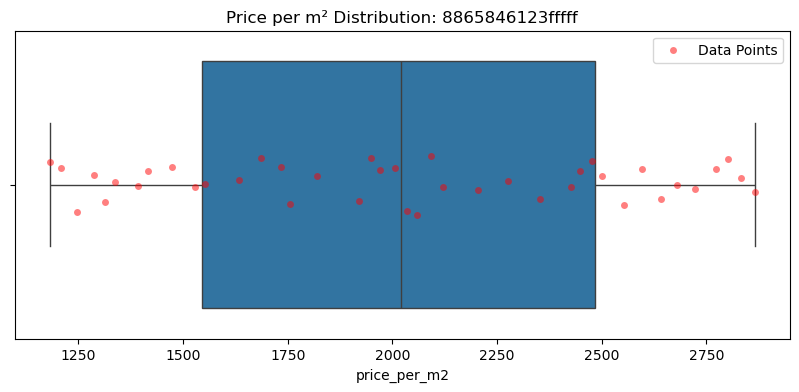

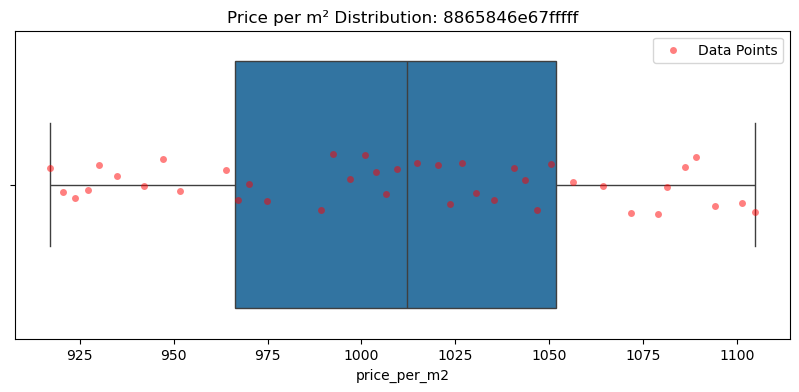

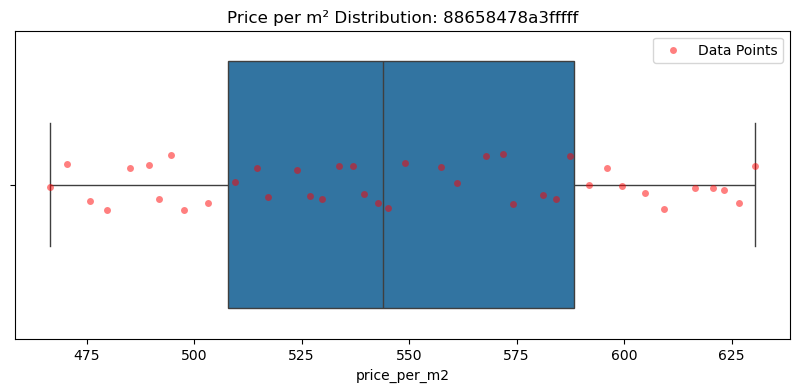

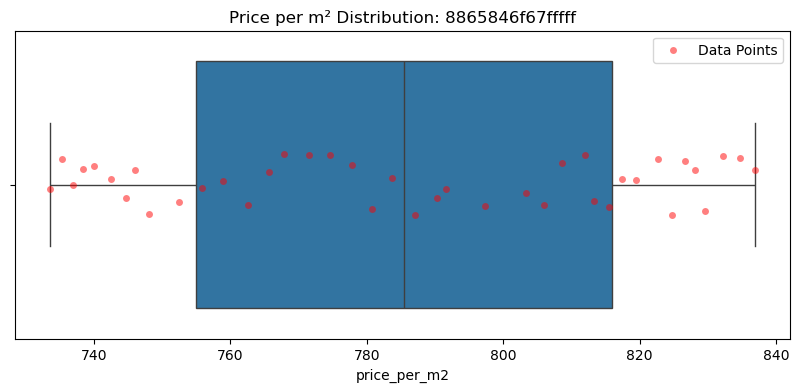

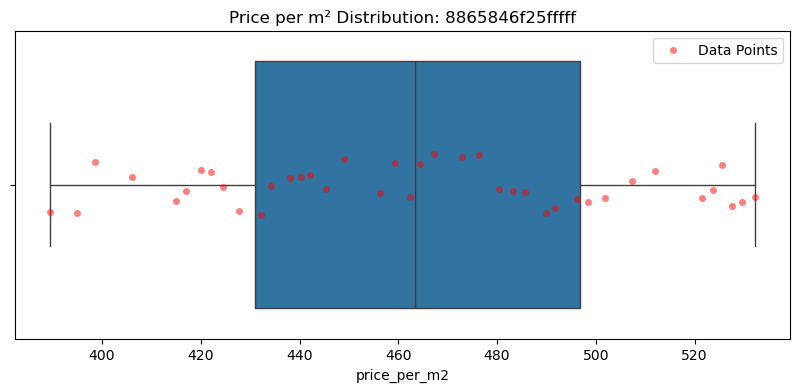

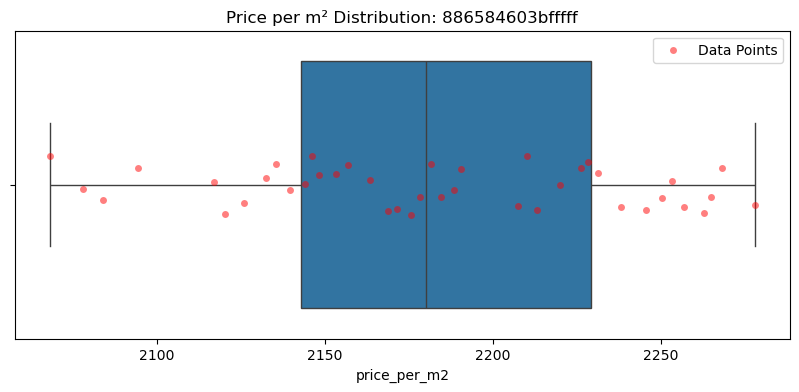

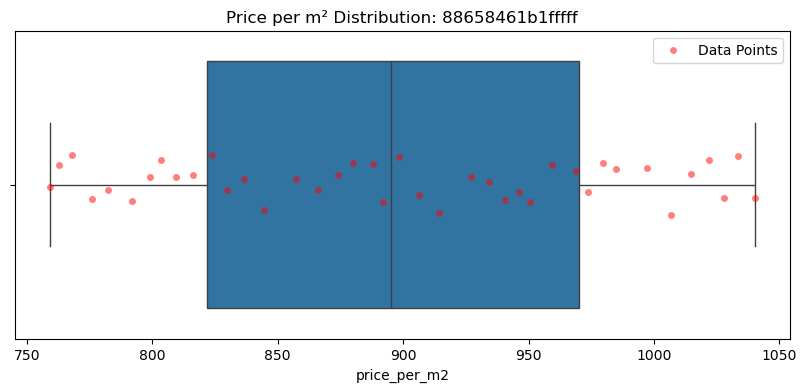

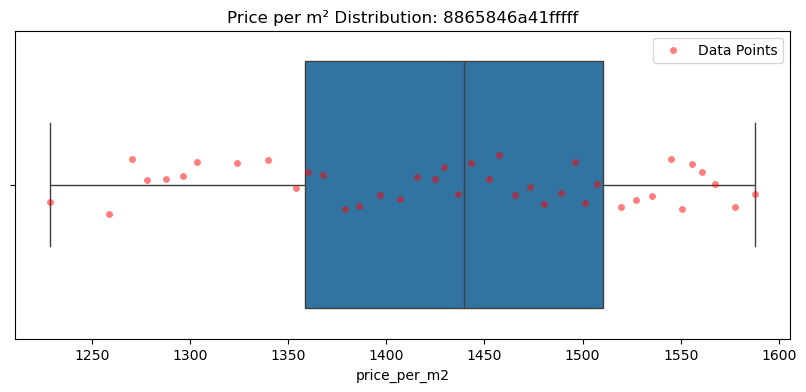

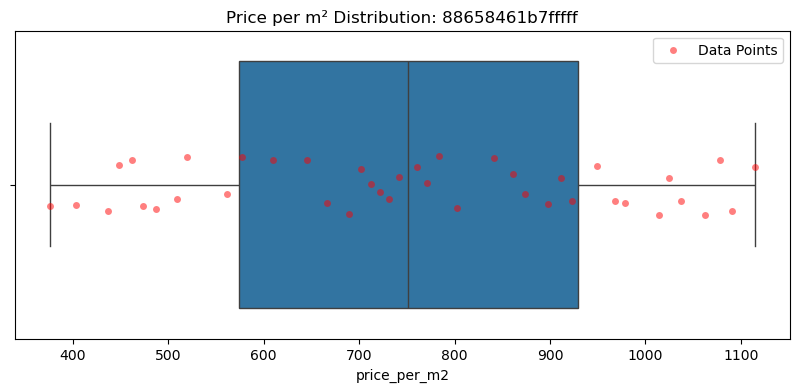

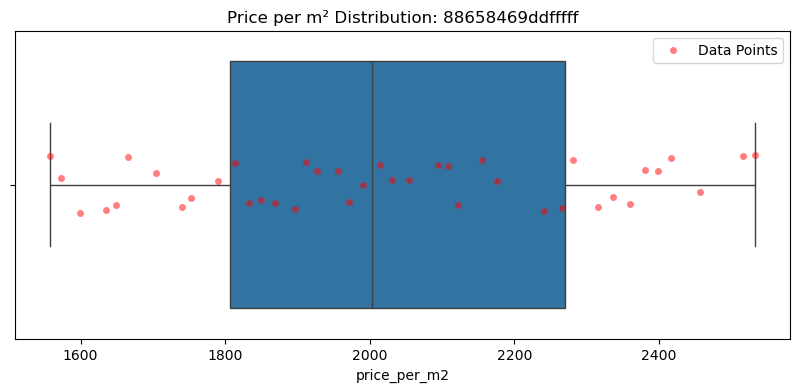

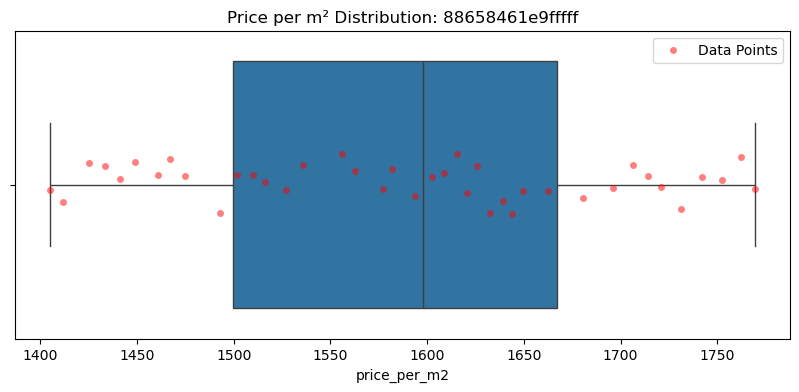

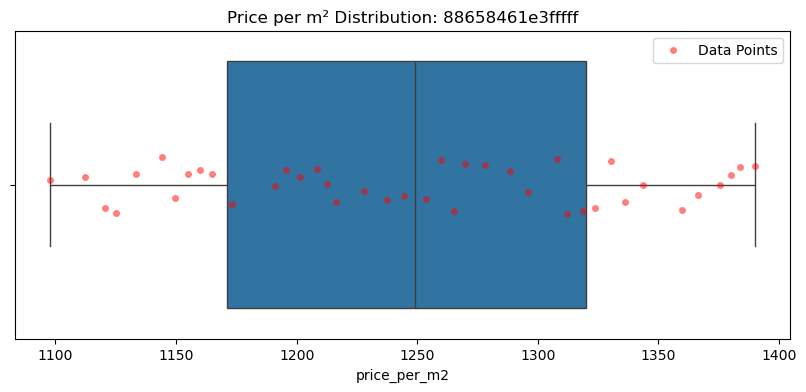

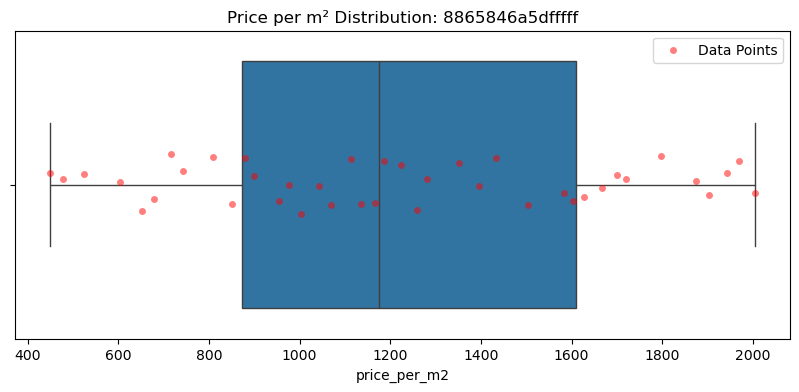

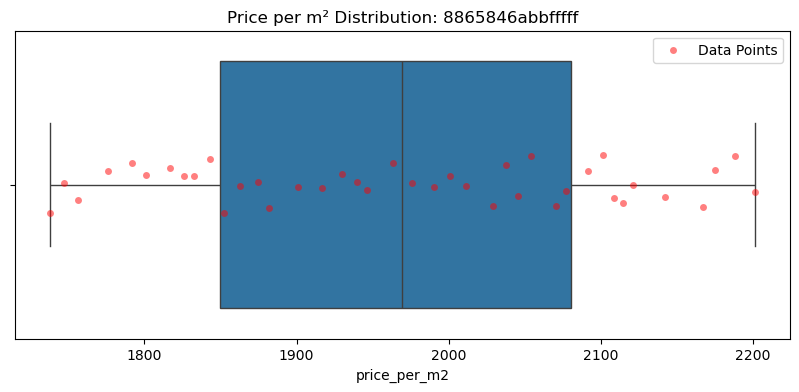

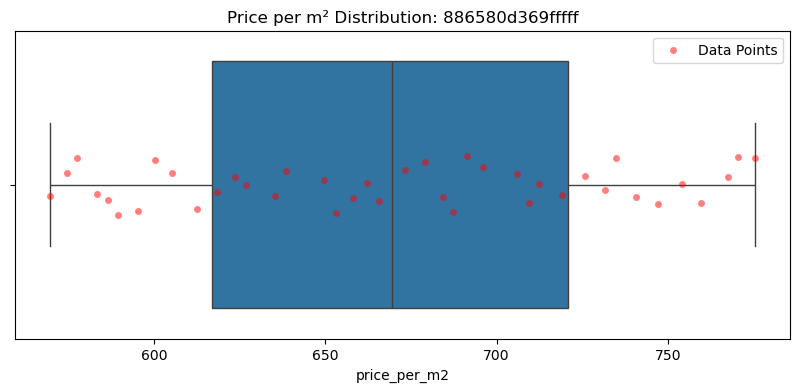

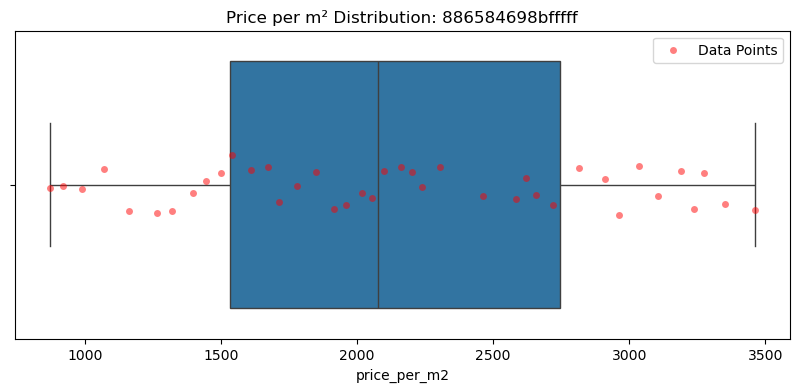

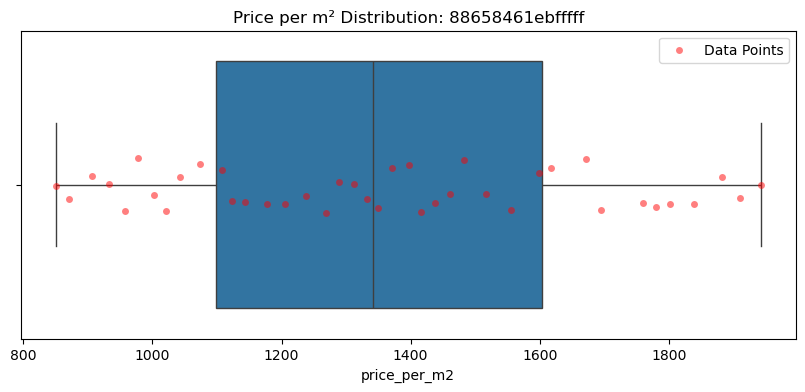

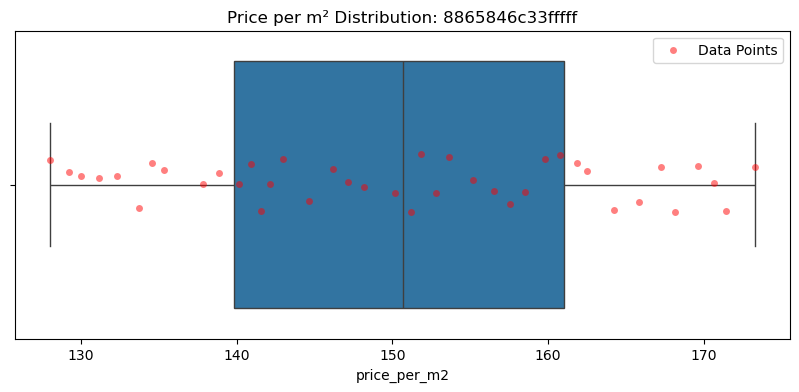

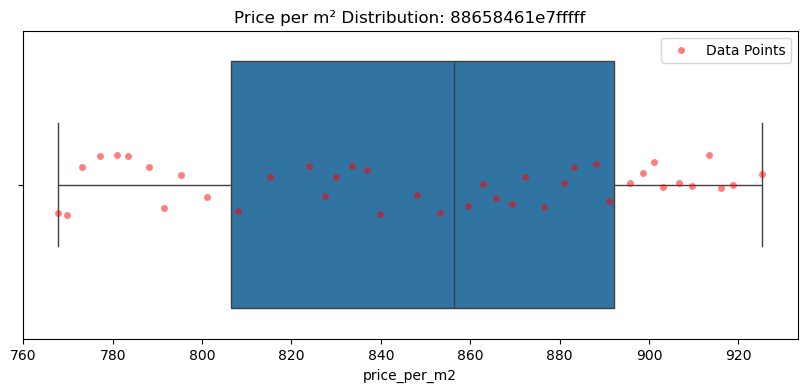

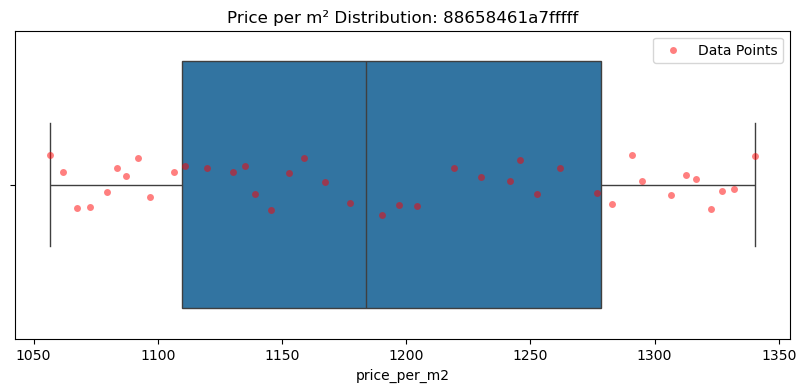

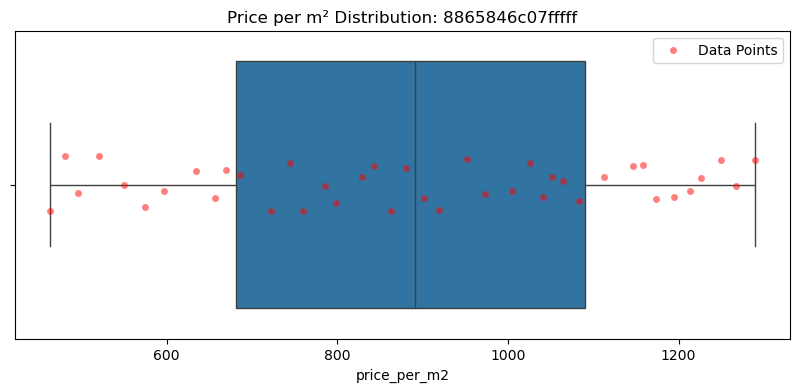

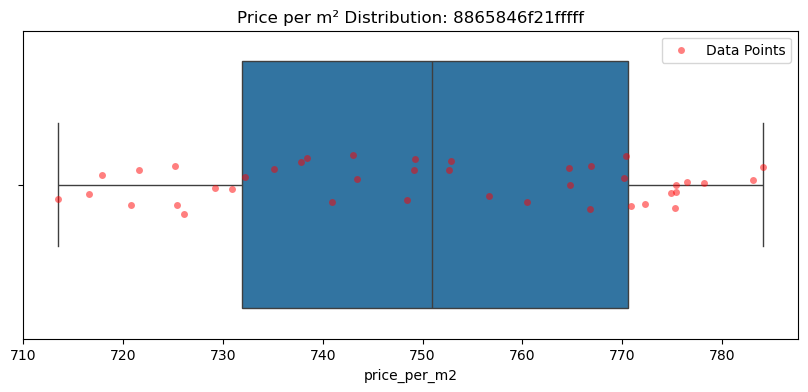

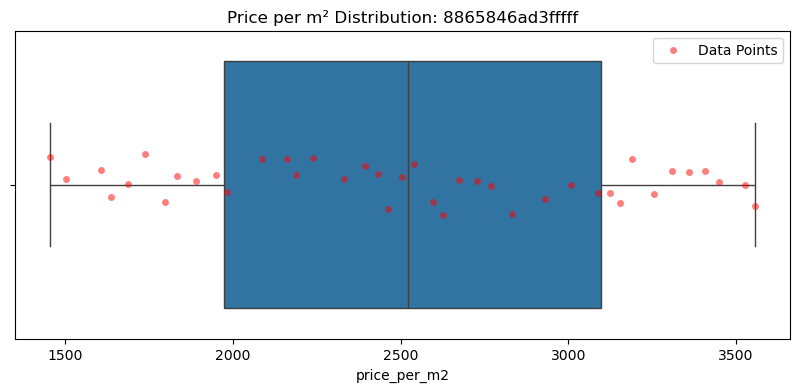

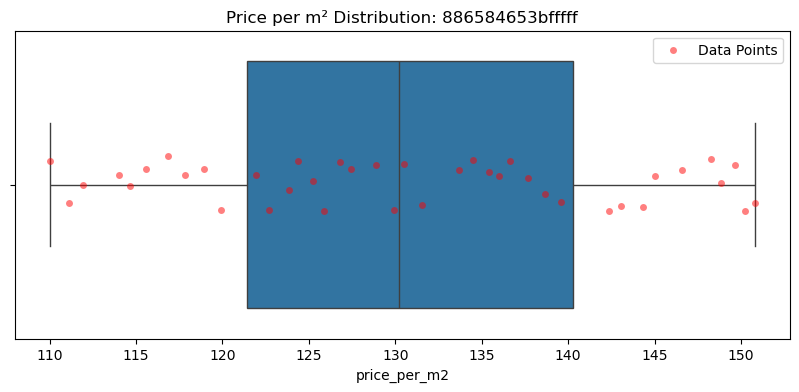

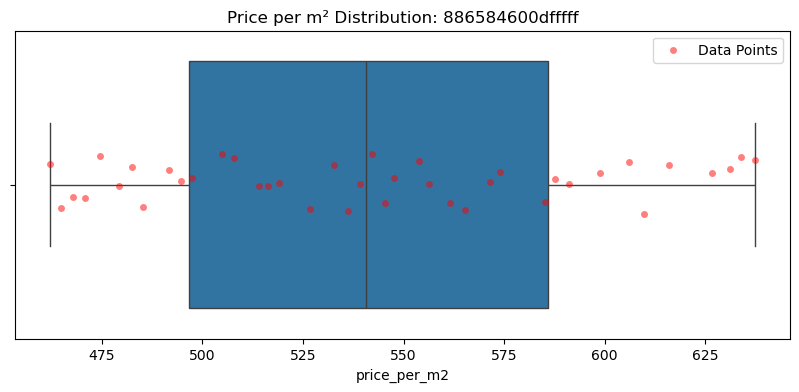

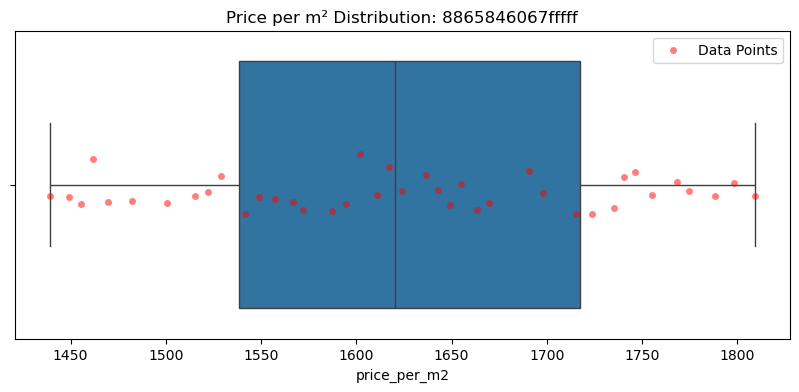

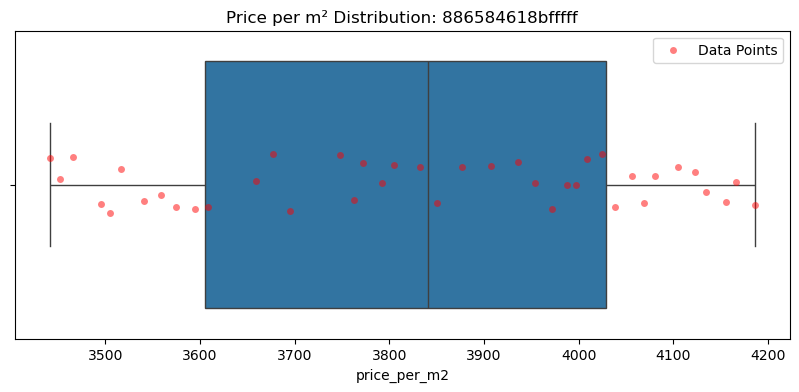

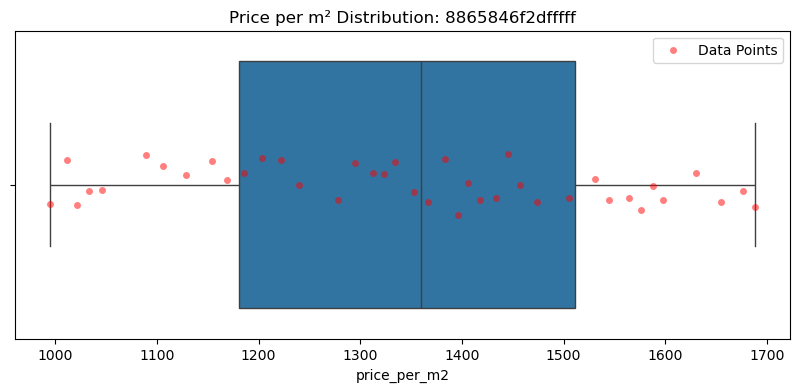

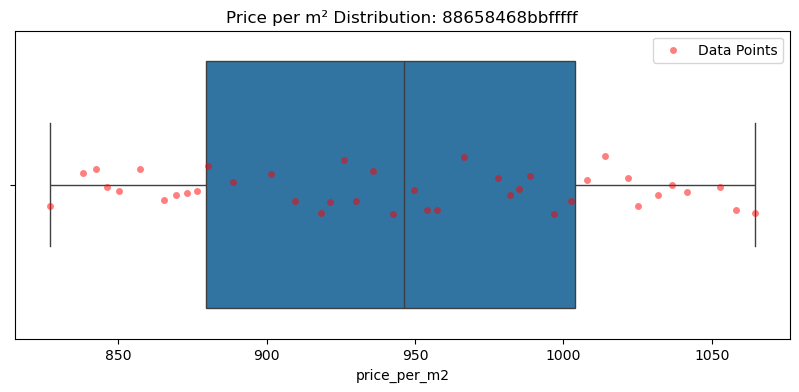

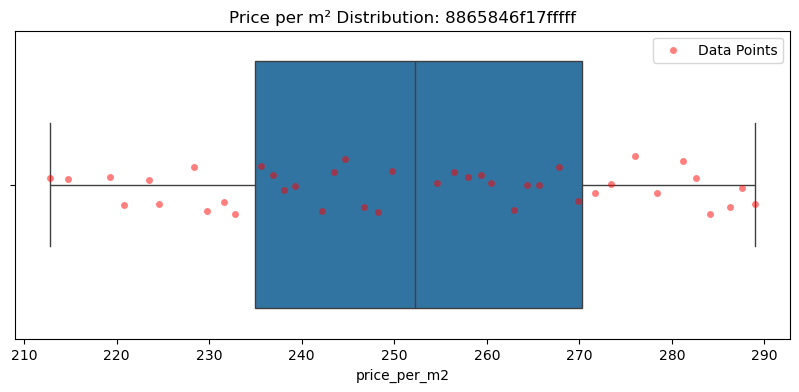

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the first 4 address_line_2 groups for plotting
groups = df['h_id'].unique()[:len(df['h_id'].unique())]

for addr in groups:
    subset = df[df['h_id'] == addr]
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=subset['price_per_m2'])
    sns.stripplot(x=subset['price_per_m2'], color='red', alpha=0.5, label='Data Points')
    plt.title(f'Price per m² Distribution: {addr}')
    plt.xlabel('price_per_m2')
    plt.legend()
    plt.show()

In [ ]:
df.to_csv('../../../data/raw/mockup/generated_data_10000.csv')